In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week, forecast_by_week, train_test_split, update_deepAR_parameters
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

In [2]:
config.train_start_time = datetime(1999,1,1,0,0,0)#datetime(2010,1,1,0,0,0)
config.train_end_time = datetime(2016,9,30,23,0,0)
config.test_end_time = datetime(2018,9,30,23,0,0)
overall_evaluation_df = pd.DataFrame()

data_splits_dict = {}
output_dict = {}

locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)

In [3]:
# Data split with no additional features and training start in 2010
#data_splits_dict["without_features_2001"] = list(train_test_split(config, df, False))
data_splits_dict["with_features_2001"] = list(train_test_split(config, df, True))

# Change the beginning of the training period
#config.train_start_time = datetime(2010,1,1,0,0,0)
#data_splits_dict["without_features_2010"] = list(train_test_split(config, df, False))
#data_splits_dict["with_features_2010"] = list(train_test_split(config, df, True))

In [4]:
def evaluate(config, train, test, configuration):
    deeparestimator = update_deepAR_parameters(configuration, config)
    forecasts, tss = model(train, test, deeparestimator)
    # Evaluation with the quantiles of the configuration and calculation of the mean_WIS
    evaluator = Evaluator(quantiles=configuration.quantiles)    
    agg_metrics = evaluator(tss, forecasts)[0]
    mean_WIS = agg_metrics["mean_absolute_QuantileLoss"]/(configuration.parameters["prediction_length"]*411)
    return mean_WIS

def objective(config, train, test, configuration):
    score = evaluate(config, train, test, configuration)
    session.report({"mean_WIS":score})

# GridSearch with dataset of 2001, and 3 * 2 * 3 * 2 * 3 * 2 * 2 = 512 parameter combinations
- num_cells [10, 20, 40]
- num_layers [3, 4]
- context_length [4, 26, 52]
- cell_type [lstm, gru]
- epochs [2, 8, 20]
- use_feat_static_real [False, True]
- use_feat_static_real [False, True]
- use_feat_static_real [TRUE]
- cardinality [2*411]

In [5]:
hp_search_space = {
    "num_cells": tune.grid_search([10, 20, 40]),
    "num_layers": tune.grid_search([3, 4]),
    "context_length":tune.grid_search([4, 26, 52]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([2, 8, 20]),
    "use_feat_static_real":tune.grid_search([False,True]),
    "use_feat_dynamic_real":tune.grid_search([False,True]),
    "use_feat_static_cat":True,
    "cardinality":[2]*411,
}
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]
configuration = Configuration()

tuner = tune.Tuner(
    tune.with_parameters(objective, train=train, test=test, configuration=configuration),
    tune_config=tune.TuneConfig(
        metric="mean_WIS",
        mode="min",
        max_concurrent_trials =2,
    ),
    param_space=hp_search_space,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result().config)

2023-03-25 20:16:32,350	INFO worker.py:1553 -- Started a local Ray instance.


100%|██████████| 50/50 [01:08<00:00,  1.36s/it, epoch=2/2, avg_epoch_loss=0.879]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 20:19:19.613650


100%|██████████| 50/50 [01:06<00:00,  1.33s/it, epoch=2/2, avg_epoch_loss=0.887]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 20:19:23.227889


 78%|███████▊  | 39/50 [00:56<00:16,  1.47s/it, epoch=2/20, avg_epoch_loss=0.738]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-25 20:19:23.680690


 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it, epoch=2/8, avg_epoch_loss=0.8]  


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 20:19:24.662680


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-25 20:19:25.875413


 70%|███████   | 35/50 [00:57<00:24,  1.63s/it, epoch=2/2, avg_epoch_loss=0.786]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 20:19:26.602995


100%|██████████| 50/50 [01:07<00:00,  1.36s/it, epoch=2/2, avg_epoch_loss=0.864]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-25 20:19:27.630951


 80%|████████  | 40/50 [01:06<00:13,  1.38s/it, epoch=2/8, avg_epoch_loss=0.749]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 20:19:27.977362


 76%|███████▌  | 38/50 [01:04<00:17,  1.45s/it, epoch=2/2, avg_epoch_loss=0.747]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 20:19:28.881836


 84%|████████▍ | 42/50 [01:04<00:12,  1.53s/it, epoch=2/8, avg_epoch_loss=0.77] 


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 20:19:30.361404


 92%|█████████▏| 46/50 [01:07<00:06,  1.51s/it, epoch=2/20, avg_epoch_loss=0.737]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 20:19:34.850017


 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it, epoch=3/8, avg_epoch_loss=0.743]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-25 20:19:36.363303


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-25 20:19:37.094185


 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it, epoch=3/8, avg_epoch_loss=0.735]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 20:19:39.428901


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 20:19:42.746796
(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 20:19:43.234245


 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it, epoch=3/8, avg_epoch_loss=0.771]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 20:19:50.490641


 14%|█▍        | 7/50 [00:10<01:07,  1.57s/it, epoch=3/20, avg_epoch_loss=0.772]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 20:19:51.610709


 64%|██████▍   | 32/50 [00:45<00:25,  1.43s/it, epoch=8/8, avg_epoch_loss=0.664]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 20:26:08.258134


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 20:26:09.147292


 60%|██████    | 30/50 [00:42<00:28,  1.42s/it, epoch=8/20, avg_epoch_loss=0.695]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 20:26:09.871493


 98%|█████████▊| 49/50 [01:05<00:01,  1.30s/it, epoch=8/8, avg_epoch_loss=0.714]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 20:26:12.380907


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it, epoch=8/8, avg_epoch_loss=0.664]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-25 20:26:13.872514


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 20:26:14.273015


 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it, epoch=9/20, avg_epoch_loss=0.888]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 20:26:19.886561


 16%|█▌        | 8/50 [00:20<00:57,  1.37s/it, epoch=9/20, avg_epoch_loss=0.604]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 20:26:27.505927


 30%|███       | 15/50 [00:21<00:50,  1.43s/it, epoch=9/20, avg_epoch_loss=0.603]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 20:26:27.775225


 94%|█████████▍| 47/50 [01:10<00:04,  1.53s/it, epoch=8/8, avg_epoch_loss=0.693]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 20:26:35.793301


 44%|████▍     | 22/50 [00:34<00:45,  1.62s/it, epoch=8/8, avg_epoch_loss=0.611]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 20:26:40.469529


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 20:26:54.183993


100%|██████████| 50/50 [01:18<00:00,  1.56s/it, epoch=8/8, avg_epoch_loss=0.709]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 20:27:05.475659


100%|██████████| 50/50 [01:15<00:00,  1.51s/it, epoch=8/8, avg_epoch_loss=0.661]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-25 20:27:10.071696


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 20:27:20.544229


 88%|████████▊ | 44/50 [01:08<00:09,  1.59s/it, epoch=8/20, avg_epoch_loss=0.645]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 20:27:23.189449


100%|██████████| 50/50 [01:23<00:00,  1.67s/it, epoch=8/8, avg_epoch_loss=0.621]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-25 20:27:49.246546


100%|██████████| 50/50 [01:21<00:00,  1.63s/it, epoch=8/8, avg_epoch_loss=0.618]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-25 20:27:57.391507


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874818) Ende umformen in Listen: 2023-03-25 20:29:41.383325


 94%|█████████▍| 47/50 [01:17<00:04,  1.62s/it, epoch=10/20, avg_epoch_loss=0.661]
Running evaluation: 41922it [00:04, 10419.19it/s]
 88%|████████▊ | 44/50 [01:11<00:09,  1.66s/it, epoch=11/20, avg_epoch_loss=0.672]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874642) Ende umformen in Listen: 2023-03-25 20:30:15.474041


 36%|███▌      | 18/50 [00:31<00:55,  1.74s/it, epoch=12/20, avg_epoch_loss=0.7]  
Running evaluation: 41922it [00:07, 5284.28it/s]
 76%|███████▌  | 38/50 [00:55<00:17,  1.49s/it, epoch=12/20, avg_epoch_loss=0.791]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)


 52%|█████▏    | 26/50 [00:58<00:59,  2.49s/it, epoch=12/20, avg_epoch_loss=0.676]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 70%|███████   | 35/50 [01:07<00:25,  1.71s/it, epoch=12/20, avg_epoch_loss=0.671]


(objective pid=3874854) Ende umformen in Listen: 2023-03-25 20:31:36.565583


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:10<01:04,  1.50s/it, epoch=13/20, avg_epoch_loss=0.736]
Running evaluation: 41922it [00:03, 12365.09it/s]
 24%|██▍       | 12/50 [00:34<01:50,  2.90s/it, epoch=12/20, avg_epoch_loss=0.596]
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:21<00:54,  1.50s/it, epoch=2/20, avg_epoch_loss=0.935]


(objective pid=3874852) Ende umformen in Listen: 2023-03-25 20:32:40.220588


Running evaluation: 0it [00:00, ?it/s]
 82%|████████▏ | 41/50 [01:15<00:14,  1.63s/it, epoch=13/20, avg_epoch_loss=0.69] 
Running evaluation: 41922it [00:04, 9409.09it/s]
 52%|█████▏    | 26/50 [00:46<00:43,  1.83s/it, epoch=14/20, avg_epoch_loss=0.722]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]
 82%|████████▏ | 41/50 [01:23<00:19,  2.13s/it, epoch=12/20, avg_epoch_loss=0.63] 


(objective pid=3874822) Ende umformen in Listen: 2023-03-25 20:33:34.689811


 40%|████      | 20/50 [00:32<00:44,  1.49s/it, epoch=14/20, avg_epoch_loss=0.734]
Running evaluation: 41922it [00:04, 9507.42it/s]
 50%|█████     | 25/50 [00:57<01:04,  2.57s/it, epoch=13/20, avg_epoch_loss=0.664]


(objective pid=3874820) Ende umformen in Listen: 2023-03-25 20:34:08.322717


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:39<01:47,  2.98s/it, epoch=14/20, avg_epoch_loss=0.694]
Running evaluation: 41922it [00:06, 6015.93it/s]
 82%|████████▏ | 41/50 [01:30<00:22,  2.47s/it, epoch=13/20, avg_epoch_loss=0.653]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [01:17<01:23,  3.35s/it, epoch=14/20, avg_epoch_loss=0.687]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:11<00:27,  1.72s/it, epoch=3/20, avg_epoch_loss=0.806]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874858) Ende umformen in Listen: 2023-03-25 20:35:20.208949


 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it, epoch=15/20, avg_epoch_loss=0.606]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 20:35:22.595878


 98%|█████████▊| 49/50 [01:31<00:01,  1.74s/it, epoch=13/20, avg_epoch_loss=0.621]
Running evaluation: 41922it [00:04, 10466.83it/s]
 62%|██████▏   | 31/50 [01:21<00:36,  1.91s/it, epoch=2/20, avg_epoch_loss=0.828]
Running evaluation: 41922it [00:05, 8152.46it/s]
 20%|██        | 10/50 [00:26<01:46,  2.65s/it, epoch=16/20, avg_epoch_loss=0.61]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 24%|██▍       | 12/50 [00:48<02:21,  3.72s/it, epoch=14/20, avg_epoch_loss=0.579]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [00:53<00:35,  1.71s/it, epoch=3/20, avg_epoch_loss=0.749]
Running

(objective pid=3874856) Ende umformen in Listen: 2023-03-25 20:36:53.406712


 78%|███████▊  | 39/50 [01:10<00:17,  1.61s/it, epoch=16/20, avg_epoch_loss=0.727]
Running evaluation: 41922it [00:04, 9282.48it/s]
 28%|██▊       | 14/50 [00:36<01:32,  2.57s/it, epoch=15/20, avg_epoch_loss=0.601]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:04,  1.49s/it, epoch=4/20, avg_epoch_loss=0.629]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 20:37:49.008574


 52%|█████▏    | 26/50 [00:56<00:43,  1.82s/it, epoch=16/20, avg_epoch_loss=0.654]
Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:34<00:01,  1.59s/it, epoch=1/2, avg_epoch_loss=0.998]
Running evaluation: 41922it [00:04, 9655.38it/s]
 24%|██▍       | 12/50 [00:21<01:08,  1.80s/it, epoch=2/2, avg_epoch_loss=0.955]


(objective pid=3874830) Ende umformen in Listen: 2023-03-25 20:38:16.855791


Running evaluation: 0it [00:00, ?it/s]
 24%|██▍       | 12/50 [00:47<02:40,  4.22s/it, epoch=1/2, avg_epoch_loss=1.08]
Running evaluation: 41922it [00:07, 5443.42it/s]
 96%|█████████▌| 48/50 [01:40<00:05,  2.50s/it, epoch=16/20, avg_epoch_loss=0.657]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:23<02:04,  2.97s/it, epoch=17/20, avg_epoch_loss=0.718]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [00:35<01:02,  1.94s/it, epoch=4/20, avg_epoch_loss=0.793]


(objective pid=3874829) Ende umformen in Listen: 2023-03-25 20:39:04.615876


Running evaluation: 0it [00:00, ?it/s]
 30%|███       | 15/50 [00:32<01:11,  2.05s/it, epoch=16/20, avg_epoch_loss=0.644]
Running evaluation: 41922it [00:05, 8082.37it/s]
 52%|█████▏    | 26/50 [00:46<00:40,  1.71s/it, epoch=18/20, avg_epoch_loss=0.699]


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 20:39:13.052416


Running evaluation: 0it [00:00, ?it/s]
 24%|██▍       | 12/50 [00:22<01:09,  1.83s/it, epoch=16/20, avg_epoch_loss=0.636]
Running evaluation: 41922it [00:07, 5702.80it/s]
 12%|█▏        | 6/50 [00:10<01:13,  1.68s/it, epoch=6/20, avg_epoch_loss=0.766]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 20:39:26.927476


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5447.73it/s]
 22%|██▏       | 11/50 [00:35<02:10,  3.34s/it, epoch=16/20, avg_epoch_loss=0.692]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-25 20:39:40.275849


 64%|██████▍   | 32/50 [01:46<00:46,  2.57s/it, epoch=16/20, avg_epoch_loss=0.644]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:47<00:44,  3.21s/it, epoch=16/20, avg_epoch_loss=0.648]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 20:39:50.094026


  4%|▍         | 2/50 [00:10<04:22,  5.47s/it, epoch=1/2, avg_epoch_loss=1.24]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 20:40:05.229888


Running evaluation: 0it [00:00, ?it/s]
 32%|███▏      | 16/50 [00:34<01:09,  2.04s/it, epoch=18/20, avg_epoch_loss=0.717]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 6814.83it/s]
 60%|██████    | 30/50 [01:48<01:05,  3.29s/it, epoch=1/2, avg_epoch_loss=0.999]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:41<04:29,  6.27s/it, epoch=1/2, avg_epoch_loss=1.03]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 20:40:35.673560


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [01:48<00:34,  2.68s/it, epoch=16/20, avg_epoch_loss=0.641]
Running evaluation: 41922it [00:10, 3835.05it/s]
 18%|█▊        | 9/50 [00:55<04:28,  6.54s/it, epoch=1/2, avg_epoch_loss=0.968]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:59<00:20,  2.51s/it, epoch=18/20, avg_epoch_loss=0.653]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [00:43<00:30,  1.43s/it, epoch=19/20, avg_epoch_loss=0.662]


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 20:41:49.960337


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [01:37<00:24,  1.90s/it, epoch=1/8, avg_epoch_loss=1.02]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 20:41:52.606820


Running evaluation: 41922it [00:03, 13720.15it/s]
 24%|██▍       | 12/50 [00:33<01:44,  2.74s/it, epoch=1/8, avg_epoch_loss=1.09]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 20:41:55.324520


 46%|████▌     | 23/50 [00:33<00:39,  1.46s/it, epoch=18/20, avg_epoch_loss=0.624]
Running evaluation: 41922it [00:05, 8346.88it/s]
 94%|█████████▍| 47/50 [01:32<00:05,  1.72s/it, epoch=5/20, avg_epoch_loss=0.736]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874864) Ende umformen in Listen: 2023-03-25 20:41:58.638333


 42%|████▏     | 21/50 [00:47<00:46,  1.60s/it, epoch=17/20, avg_epoch_loss=0.65]
Running evaluation: 13946it [00:10, 1312.63it/s]
 46%|████▌     | 23/50 [00:46<00:39,  1.46s/it, epoch=18/20, avg_epoch_loss=0.617]
Running evaluation: 41922it [00:10, 3923.84it/s]
 86%|████████▌ | 43/50 [01:35<00:22,  3.15s/it, epoch=19/20, avg_epoch_loss=0.691]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 74%|███████▍  | 37/50 [01:22<00:35,  2.75s/it, epoch=18/20, avg_epoch_loss=0.625]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
  6%|▌         | 3/50 [00:11<03:00,  3.84s/it, epoch=1/8, avg_epoch_loss=1.34]
(objective

(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 20:43:04.628912


 20%|██        | 10/50 [00:21<01:24,  2.11s/it, epoch=1/20, avg_epoch_loss=1.2]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-25 20:43:22.774306


 28%|██▊       | 14/50 [00:20<00:53,  1.48s/it, epoch=8/20, avg_epoch_loss=0.654]
Running evaluation: 41922it [00:03, 13488.95it/s]
 74%|███████▍  | 37/50 [01:31<00:28,  2.17s/it, epoch=19/20, avg_epoch_loss=0.634]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874832) Ende umformen in Listen: 2023-03-25 20:43:41.781510


100%|██████████| 50/50 [01:59<00:00,  2.38s/it, epoch=2/2, avg_epoch_loss=0.755]
Running evaluation: 41922it [00:07, 5894.92it/s]
 54%|█████▍    | 27/50 [00:43<00:39,  1.70s/it, epoch=20/20, avg_epoch_loss=0.631]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 20:43:49.242076


 82%|████████▏ | 41/50 [01:17<00:16,  1.84s/it, epoch=18/20, avg_epoch_loss=0.625]


(objective pid=3874892) Ende umformen in Listen: 2023-03-25 20:43:52.464630


Running evaluation: 0it [00:00, ?it/s]
 54%|█████▍    | 27/50 [00:46<00:42,  1.83s/it, epoch=19/20, avg_epoch_loss=0.641]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-25 20:43:55.701542


 66%|██████▌   | 33/50 [00:55<00:29,  1.74s/it, epoch=8/20, avg_epoch_loss=0.728]
Running evaluation: 41922it [00:07, 5284.60it/s]
 54%|█████▍    | 27/50 [01:00<00:42,  1.83s/it, epoch=19/20, avg_epoch_loss=0.633]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:39<00:39,  3.33s/it, epoch=18/20, avg_epoch_loss=0.628]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:43<00:14,  2.44s/it, epoch=2/8, avg_epoch_loss=0.84] 
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warnin

(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-25 20:44:46.628497


 92%|█████████▏| 46/50 [01:35<00:08,  2.18s/it, epoch=20/20, avg_epoch_loss=0.634]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 20:44:49.507638


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-25 20:44:51.444325


100%|██████████| 50/50 [01:41<00:00,  2.03s/it, epoch=20/20, avg_epoch_loss=0.64] 


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 20:44:55.476039


 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it, epoch=3/8, avg_epoch_loss=0.793]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874902) Ende umformen in Listen: 2023-03-25 20:45:05.565725


 82%|████████▏ | 41/50 [01:48<00:16,  1.87s/it, epoch=20/20, avg_epoch_loss=0.67] 
Running evaluation: 41922it [00:04, 9677.25it/s]
 26%|██▌       | 13/50 [00:37<01:47,  2.91s/it, epoch=1/20, avg_epoch_loss=1.12]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 20:45:14.711490


 62%|██████▏   | 31/50 [00:57<00:35,  1.88s/it, epoch=20/20, avg_epoch_loss=0.657]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-25 20:45:34.047002


 48%|████▊     | 24/50 [00:44<00:50,  1.96s/it, epoch=20/20, avg_epoch_loss=0.652]
Running evaluation: 41922it [00:06, 6260.02it/s]
 44%|████▍     | 22/50 [00:50<01:09,  2.50s/it, epoch=19/20, avg_epoch_loss=0.592]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
 82%|████████▏ | 41/50 [01:32<00:25,  2.83s/it, epoch=7/20, avg_epoch_loss=0.743]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 20:46:06.633839


Running evaluation: 0it [00:00, ?it/s]
 48%|████▊     | 24/50 [01:08<01:21,  3.14s/it, epoch=2/20, avg_epoch_loss=0.999]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 20:46:12.321240


 74%|███████▍  | 37/50 [01:23<00:26,  2.03s/it, epoch=1/20, avg_epoch_loss=0.941]
Running evaluation: 41922it [00:05, 7164.51it/s]
 24%|██▍       | 12/50 [00:24<01:16,  2.02s/it, epoch=4/8, avg_epoch_loss=0.851]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 26%|██▌       | 13/50 [00:48<02:14,  3.63s/it, epoch=19/20, avg_epoch_loss=0.59]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-25 20:46:29.647014


 66%|██████▌   | 33/50 [01:35<00:48,  2.88s/it, epoch=3/8, avg_epoch_loss=0.828]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-25 20:46:30.102057


 72%|███████▏  | 36/50 [01:10<00:28,  2.05s/it, epoch=4/8, avg_epoch_loss=0.737]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:22<00:57,  1.61s/it, epoch=3/8, avg_epoch_loss=0.697]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874869) Ende umformen in Listen: 2023-03-25 20:47:14.903095


 40%|████      | 20/50 [00:32<00:47,  1.58s/it, epoch=20/20, avg_epoch_loss=0.607]
Running evaluation: 41922it [00:03, 12303.79it/s]
 32%|███▏      | 16/50 [00:38<01:01,  1.80s/it, epoch=4/8, avg_epoch_loss=0.807]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-25 20:47:40.525010


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:26<00:00,  1.73s/it, epoch=20/20, avg_epoch_loss=0.628]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-25 20:48:13.133762


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874900) Ende umformen in Listen: 2023-03-25 20:48:34.314079


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 10269.94it/s]
 98%|█████████▊| 49/50 [01:15<00:01,  1.46s/it, epoch=5/8, avg_epoch_loss=0.822]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-25 20:48:40.329251


 66%|██████▌   | 33/50 [01:02<00:37,  2.18s/it, epoch=3/20, avg_epoch_loss=0.944]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 74%|███████▍  | 37/50 [01:11<00:25,  1.96s/it, epoch=9/20, avg_epoch_loss=0.654]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-25 20:49:26.335122


100%|██████████| 50/50 [01:34<00:00,  1.88s/it, epoch=20/20, avg_epoch_loss=0.633]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-25 20:49:30.895119


 62%|██████▏   | 31/50 [01:01<00:34,  1.84s/it, epoch=3/20, avg_epoch_loss=0.85] 
Running evaluation: 41922it [00:05, 8118.25it/s]
 22%|██▏       | 11/50 [00:36<02:14,  3.44s/it, epoch=1/2, avg_epoch_loss=1.15]
Running evaluation: 0it [00:00, ?it/s]
 40%|████      | 20/50 [00:36<00:57,  1.92s/it, epoch=3/20, avg_epoch_loss=0.737]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 20:49:53.592527


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:09, 4327.10it/s]
 34%|███▍      | 17/50 [00:34<01:08,  2.08s/it, epoch=4/20, avg_epoch_loss=0.864]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:04<00:19,  1.75s/it, epoch=12/20, avg_epoch_loss=0.662]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-25 20:50:12.238702


 14%|█▍        | 7/50 [00:35<02:26,  3.40s/it, epoch=4/20, avg_epoch_loss=0.859]
Running evaluation: 41922it [00:06, 6126.39it/s]
 40%|████      | 20/50 [00:59<01:40,  3.35s/it, epoch=5/8, avg_epoch_loss=0.765]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 20:50:25.143284


 72%|███████▏  | 36/50 [01:35<00:36,  2.59s/it, epoch=1/2, avg_epoch_loss=1.02]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 18%|█▊        | 9/50 [00:22<01:42,  2.51s/it, epoch=13/20, avg_epoch_loss=0.758]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [01:23<00:50,  2.40s/it, epoch=4/20, avg_epoch_loss=0.827]


(objective pid=3874896) Ende umformen in Listen: 2023-03-25 20:51:07.511287


Running evaluation: 0it [00:00, ?it/s]
 54%|█████▍    | 27/50 [01:01<00:49,  2.16s/it, epoch=11/20, avg_epoch_loss=0.656]
Running evaluation: 41922it [00:04, 8824.65it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 20:51:22.675381


 24%|██▍       | 12/50 [00:22<01:13,  1.93s/it, epoch=4/20, avg_epoch_loss=0.677]
Running evaluation: 41922it [00:05, 8039.54it/s]
 72%|███████▏  | 36/50 [01:54<00:46,  3.34s/it, epoch=10/20, avg_epoch_loss=0.694]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:40<00:00,  3.21s/it, epoch=4/8, avg_epoch_loss=0.712]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:22<00:07,  1.78s/it, epoch=13/20, avg_epoch_loss=0.608]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 20:52:17.232630


 92%|█████████▏| 46/50 [01:39<00:08,  2.05s/it, epoch=9/20, avg_epoch_loss=0.626]
Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it, epoch=5/8, avg_epoch_loss=0.719]


(objective pid=3874872) Ende umformen in Listen: 2023-03-25 20:52:26.505226


 12%|█▏        | 6/50 [00:10<01:19,  1.81s/it, epoch=10/20, avg_epoch_loss=0.607]
Running evaluation: 41922it [00:06, 6387.77it/s]
 66%|██████▌   | 33/50 [00:57<00:31,  1.85s/it, epoch=8/8, avg_epoch_loss=0.717]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 20:52:58.601053


 20%|██        | 10/50 [00:36<01:37,  2.43s/it, epoch=10/20, avg_epoch_loss=0.622]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 20:53:09.665910


 46%|████▌     | 23/50 [00:52<01:06,  2.48s/it, epoch=11/20, avg_epoch_loss=0.656]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:27<00:00,  1.74s/it, epoch=8/8, avg_epoch_loss=0.752]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 20:53:28.024462


 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it, epoch=6/20, avg_epoch_loss=0.816]


(objective pid=3874904) Ende umformen in Listen: 2023-03-25 20:54:10.857269


Running evaluation: 0it [00:00, ?it/s]
 18%|█▊        | 9/50 [00:11<00:50,  1.23s/it, epoch=7/20, avg_epoch_loss=0.818]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-25 20:54:13.460310


 52%|█████▏    | 26/50 [00:57<00:46,  1.92s/it, epoch=1/8, avg_epoch_loss=1.13]
Running evaluation: 41922it [00:03, 12466.87it/s]
 82%|████████▏ | 41/50 [01:09<00:15,  1.77s/it, epoch=13/20, avg_epoch_loss=0.709]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 20:54:45.906520


 88%|████████▊ | 44/50 [01:34<00:12,  2.05s/it, epoch=1/8, avg_epoch_loss=1.03]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 34%|███▍      | 17/50 [00:32<00:59,  1.81s/it, epoch=7/20, avg_epoch_loss=0.739]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 20:55:02.867875


 92%|█████████▏| 46/50 [01:26<00:06,  1.72s/it, epoch=12/20, avg_epoch_loss=0.645]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 20:55:18.255113


 78%|███████▊  | 39/50 [01:21<00:20,  1.85s/it, epoch=5/20, avg_epoch_loss=0.712]
Running evaluation: 41922it [00:03, 10967.10it/s]
 60%|██████    | 30/50 [00:57<00:40,  2.02s/it, epoch=8/8, avg_epoch_loss=0.638]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [01:04<01:24,  3.03s/it, epoch=1/8, avg_epoch_loss=1.06]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 20:55:58.211148


 22%|██▏       | 11/50 [00:21<01:14,  1.92s/it, epoch=12/20, avg_epoch_loss=0.65]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-25 20:56:08.392272


 34%|███▍      | 17/50 [00:33<00:57,  1.74s/it, epoch=8/20, avg_epoch_loss=0.784]
Running evaluation: 41922it [00:04, 9472.40it/s]
 56%|█████▌    | 28/50 [00:59<00:41,  1.89s/it, epoch=13/20, avg_epoch_loss=0.686]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874858) Ende umformen in Listen: 2023-03-25 20:56:28.951827


 80%|████████  | 40/50 [01:18<00:18,  1.84s/it, epoch=3/8, avg_epoch_loss=0.819]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 20:56:30.943311


 90%|█████████ | 45/50 [01:37<00:13,  2.63s/it, epoch=8/8, avg_epoch_loss=0.636]
Running evaluation: 41922it [00:07, 5273.06it/s]
 72%|███████▏  | 36/50 [01:15<00:31,  2.22s/it, epoch=8/20, avg_epoch_loss=0.736]
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [00:56<01:03,  2.55s/it, epoch=6/20, avg_epoch_loss=0.691]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 20:56:54.245510


 60%|██████    | 30/50 [01:13<00:46,  2.30s/it, epoch=8/20, avg_epoch_loss=0.749]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [00:32<00:54,  1.69s/it, epoch=4/8, avg_epoch_loss=0.823]


(objective pid=3874840) Ende umformen in Listen: 2023-03-25 20:57:38.761204


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:44<01:48,  3.01s/it, epoch=1/8, avg_epoch_loss=1.07]
Running evaluation: 41922it [00:04, 9128.89it/s]
 60%|██████    | 30/50 [00:50<00:36,  1.82s/it, epoch=9/20, avg_epoch_loss=0.736]
Running evaluation: 0it [00:00, ?it/s]
 20%|██        | 10/50 [00:23<01:37,  2.43s/it, epoch=8/20, avg_epoch_loss=0.664]


(objective pid=3874842) Ende umformen in Listen: 2023-03-25 20:58:15.582225


 10%|█         | 5/50 [00:10<01:38,  2.18s/it, epoch=18/20, avg_epoch_loss=0.543]
Running evaluation: 41922it [00:07, 5289.00it/s]
 62%|██████▏   | 31/50 [01:01<00:42,  2.24s/it, epoch=8/8, avg_epoch_loss=0.662]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [00:34<01:02,  1.94s/it, epoch=18/20, avg_epoch_loss=0.622]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874878) Ende umformen in Listen: 2023-03-25 20:58:57.120506


 72%|███████▏  | 36/50 [01:23<00:39,  2.86s/it, epoch=8/20, avg_epoch_loss=0.691]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 6430.34it/s]
 40%|████      | 20/50 [00:51<00:51,  1.72s/it, epoch=4/8, avg_epoch_loss=0.765]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 20:59:19.694775


 98%|█████████▊| 49/50 [01:49<00:02,  2.45s/it, epoch=9/20, avg_epoch_loss=0.714]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:06<00:12,  1.59s/it, epoch=8/20, avg_epoch_loss=0.663]


(objective pid=3874876) Ende umformen in Listen: 2023-03-25 21:00:48.385948


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:15<00:00,  1.50s/it, epoch=10/20, avg_epoch_loss=0.659]
Running evaluation: 41922it [00:05, 7048.24it/s]
 60%|██████    | 30/50 [00:58<00:30,  1.51s/it, epoch=6/8, avg_epoch_loss=0.803]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874907) Ende umformen in Listen: 2023-03-25 21:01:10.991718


  8%|▊         | 4/50 [00:11<02:13,  2.89s/it, epoch=9/20, avg_epoch_loss=0.594]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874856) Ende umformen in Listen: 2023-03-25 21:01:17.402723


 36%|███▌      | 18/50 [00:43<01:23,  2.60s/it, epoch=10/20, avg_epoch_loss=0.668]
Running evaluation: 41922it [00:11, 3555.05it/s]
 92%|█████████▏| 46/50 [01:23<00:09,  2.32s/it, epoch=10/20, avg_epoch_loss=0.786]
Running evaluation: 41922it [00:07, 5307.30it/s]
Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:17<00:00,  1.56s/it, epoch=6/8, avg_epoch_loss=0.732]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 21:01:26.233714


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:08, 5150.79it/s]
 64%|██████▍   | 32/50 [01:09<00:47,  2.62s/it, epoch=3/20, avg_epoch_loss=0.905]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
  4%|▍         | 2/50 [00:29<11:07, 13.91s/it, epoch=1/20, avg_epoch_loss=1.19]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
  6%|▌         | 3/50 [00:11<02:55,  3.73s/it, epoch=7/8, avg_epoch_loss=0.415]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objectiv

(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 21:02:59.379606


 64%|██████▍   | 32/50 [00:53<00:27,  1.53s/it, epoch=7/8, avg_epoch_loss=0.687]


(objective pid=3874844) Ende umformen in Listen: 2023-03-25 21:03:01.188578


Running evaluation: 0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [01:53<00:11,  1.98s/it, epoch=15/20, avg_epoch_loss=0.598]
Running evaluation: 41922it [00:03, 11170.99it/s]
 86%|████████▌ | 43/50 [01:35<00:12,  1.75s/it, epoch=6/8, avg_epoch_loss=0.707]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 21:03:09.979517


 20%|██        | 10/50 [00:22<01:29,  2.25s/it, epoch=11/20, avg_epoch_loss=0.6] 
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 24%|██▍       | 12/50 [00:21<01:04,  1.70s/it, epoch=7/8, avg_epoch_loss=0.678]
Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:24<00:01,  1.86s/it, epoch=12/20, avg_epoch_loss=0.746]


(objective pid=3874846) Ende umformen in Listen: 2023-03-25 21:03:46.823916


 88%|████████▊ | 44/50 [02:01<00:12,  2.05s/it, epoch=1/20, avg_epoch_loss=0.871]
Running evaluation: 41922it [00:03, 12074.45it/s]
 86%|████████▌ | 43/50 [01:16<00:12,  1.76s/it, epoch=8/8, avg_epoch_loss=0.719]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:27<00:00,  1.75s/it, epoch=8/8, avg_epoch_loss=0.716]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 21:04:37.988234


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 21:05:07.066829


 40%|████      | 20/50 [00:32<00:49,  1.65s/it, epoch=12/20, avg_epoch_loss=0.599]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 21:05:20.340135


100%|██████████| 50/50 [01:25<00:00,  1.70s/it, epoch=5/20, avg_epoch_loss=0.75] 
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-25 21:05:24.243882


 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it, epoch=20/20, avg_epoch_loss=0.65] 


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 21:05:24.827654


 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it, epoch=14/20, avg_epoch_loss=0.752]
Running evaluation: 41922it [00:03, 11368.47it/s]
 32%|███▏      | 16/50 [00:38<01:27,  2.58s/it, epoch=14/20, avg_epoch_loss=0.746]


(objective pid=3874880) Ende umformen in Listen: 2023-03-25 21:05:54.379412


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [01:07<00:21,  1.62s/it, epoch=20/20, avg_epoch_loss=0.654]
Running evaluation: 41922it [00:05, 7754.57it/s]
 30%|███       | 15/50 [00:32<01:16,  2.19s/it, epoch=3/20, avg_epoch_loss=0.777]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:11<01:24,  1.91s/it, epoch=19/20, avg_epoch_loss=0.63]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 21:06:18.203010


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-25 21:06:23.119924


  6%|▌         | 3/50 [00:10<02:50,  3.63s/it, epoch=13/20, avg_epoch_loss=0.648]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 21:06:44.042148


 70%|███████   | 35/50 [01:16<00:28,  1.88s/it, epoch=5/20, avg_epoch_loss=0.782]
Running evaluation: 41922it [00:04, 9525.87it/s]
 56%|█████▌    | 28/50 [00:45<00:34,  1.58s/it, epoch=14/20, avg_epoch_loss=0.733]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 21:07:28.650719


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [02:07<00:00,  2.54s/it, epoch=2/2, avg_epoch_loss=0.765]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 21:07:30.273685


 50%|█████     | 25/50 [01:06<01:03,  2.54s/it, epoch=13/20, avg_epoch_loss=0.624]
Running evaluation: 41922it [00:05, 7853.51it/s]
 62%|██████▏   | 31/50 [01:33<00:50,  2.65s/it, epoch=13/20, avg_epoch_loss=0.621]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 21:08:00.248948


 18%|█▊        | 9/50 [00:24<01:53,  2.76s/it, epoch=15/20, avg_epoch_loss=0.627]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:23<00:00,  1.67s/it, epoch=8/8, avg_epoch_loss=0.695]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 21:08:37.129577
(objective pid=3874869) Ende umformen in Listen: 2023-03-25 21:08:37.211846


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 21:08:38.501720


Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [01:58<00:04,  2.10s/it, epoch=18/20, avg_epoch_loss=0.579]
Running evaluation: 41922it [00:04, 8945.12it/s]
 56%|█████▌    | 28/50 [01:15<00:44,  2.01s/it, epoch=1/8, avg_epoch_loss=0.904]
Running evaluation: 41922it [00:09, 4650.81it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874848) Ende umformen in Listen: 2023-03-25 21:08:54.877329


 28%|██▊       | 14/50 [00:23<01:01,  1.70s/it, epoch=14/20, avg_epoch_loss=0.646]


(objective pid=3874830) Ende umformen in Listen: 2023-03-25 21:08:57.469297


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [01:29<00:29,  1.98s/it, epoch=1/8, avg_epoch_loss=0.882]
Running evaluation: 41922it [00:05, 7062.64it/s]
 94%|█████████▍| 47/50 [01:29<00:06,  2.24s/it, epoch=20/20, avg_epoch_loss=0.668]
Running evaluation: 41922it [00:08, 4943.87it/s]
 82%|████████▏ | 41/50 [01:55<00:25,  2.88s/it, epoch=1/8, avg_epoch_loss=0.885]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-25 21:09:27.285381


 90%|█████████ | 45/50 [01:59<00:19,  3.87s/it, epoch=7/8, avg_epoch_loss=0.629]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:20<01:24,  3.68s/it, epoch=8/20, avg_epoch_loss=0.712]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [02:28<00:16,  4.14s/it, epoch=1/8, avg_epoch_loss=0.884]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:40<00:

(objective pid=3874850) Ende umformen in Listen: 2023-03-25 21:10:01.559457


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 5991.28it/s]
 28%|██▊       | 14/50 [00:39<01:45,  2.94s/it, epoch=8/8, avg_epoch_loss=0.613]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-25 21:10:35.447388


 22%|██▏       | 11/50 [00:51<03:07,  4.80s/it, epoch=1/8, avg_epoch_loss=1.16]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:24<01:02,  1.74s/it, epoch=8/8, avg_epoch_loss=0.693]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-25 21:11:10.036300


100%|██████████| 50/50 [01:40<00:00,  2.01s/it, epoch=8/8, avg_epoch_loss=0.646]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 21:11:36.988556


 42%|████▏     | 21/50 [00:31<00:43,  1.50s/it, epoch=16/20, avg_epoch_loss=0.666]


(objective pid=3874829) Ende umformen in Listen: 2023-03-25 21:11:46.814722


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:10<01:03,  1.49s/it, epoch=2/8, avg_epoch_loss=0.828]
Running evaluation: 41922it [00:04, 8510.10it/s]
 26%|██▌       | 13/50 [00:30<01:32,  2.51s/it, epoch=2/8, avg_epoch_loss=0.81]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-25 21:12:11.679873


 22%|██▏       | 11/50 [00:38<02:20,  3.59s/it, epoch=6/20, avg_epoch_loss=0.678]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:31<00:00,  1.82s/it, epoch=20/20, avg_epoch_loss=0.604]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 21:12:31.594478


 82%|████████▏ | 41/50 [01:14<00:16,  1.82s/it, epoch=8/20, avg_epoch_loss=0.655]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 21:12:40.527132


 70%|███████   | 35/50 [00:53<00:22,  1.53s/it, epoch=18/20, avg_epoch_loss=0.693]
Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it, epoch=7/20, avg_epoch_loss=0.667]


(objective pid=3874886) Ende umformen in Listen: 2023-03-25 21:13:42.035271


 40%|████      | 20/50 [00:35<00:53,  1.78s/it, epoch=7/20, avg_epoch_loss=0.688]
Running evaluation: 41922it [00:03, 12845.43it/s]
 80%|████████  | 40/50 [01:13<00:22,  2.24s/it, epoch=19/20, avg_epoch_loss=0.657]
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:10<00:54,  1.30s/it, epoch=6/8, avg_epoch_loss=0.779]


(objective pid=3874884) Ende umformen in Listen: 2023-03-25 21:15:36.926116


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:11<00:59,  1.43s/it, epoch=17/20, avg_epoch_loss=0.642]
Running evaluation: 41922it [00:03, 12687.25it/s]
 16%|█▌        | 8/50 [00:22<00:59,  1.43s/it, epoch=17/20, avg_epoch_loss=0.629]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874900) Ende umformen in Listen: 2023-03-25 21:15:51.157703


 76%|███████▌  | 38/50 [00:58<00:20,  1.67s/it, epoch=11/20, avg_epoch_loss=0.664]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-25 21:15:53.155314
(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-25 21:15:53.732395


 82%|████████▏ | 41/50 [01:10<00:17,  1.98s/it, epoch=4/8, avg_epoch_loss=0.712]
Running evaluation: 41922it [00:07, 5754.64it/s]
Running evaluation: 41922it [00:06, 6332.22it/s]
 98%|█████████▊| 49/50 [01:43<00:02,  2.61s/it, epoch=8/20, avg_epoch_loss=0.652]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 21:16:28.311475


(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
 38%|███▊      | 19/50 [00:54<01:39,  3.20s/it, epoch=6/8, avg_epoch_loss=0.786]
Running evaluation: 1it [00:11, 11.88s/it]
Running evaluation: 41922it [00:11, 3494.13it/s]
 62%|██████▏   | 31/50 [01:19<00:59,  3.15s/it, epoch=20/20, avg_epoch_loss=0.656]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:41<00:41,  3.46s/it, epoch=4/8, avg_epoch_loss=0.687]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 21:16:53.105673


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [01:38<00:59,  3.98s/it, epoch=4/8, avg_epoch_loss=0.644]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [01:27<01:01,  2.92s/it, epoch=20/20, avg_epoch_loss=0.693]
Running evaluation: 41922it [00:07, 5842.31it/s]
 88%|████████▊ | 44/50 [02:03<00:18,  3.04s/it, epoch=3/20, avg_epoch_loss=0.673]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-25 21:17:38.132617


 12%|█▏        | 6/50 [00:10<01:20,  1.82s/it, epoch=7/8, avg_epoch_loss=0.776]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:18<00:00,  2.77s/it, epoch=20/20, avg_epoch_loss=0.748]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 21:17:52.126178


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 21:19:05.784129


100%|██████████| 50/50 [01:11<00:00,  1.43s/it, epoch=8/8, avg_epoch_loss=0.677]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 21:19:59.421810


 76%|███████▌  | 38/50 [01:05<00:20,  1.69s/it, epoch=6/8, avg_epoch_loss=0.644]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 21:20:05.423693


100%|██████████| 50/50 [01:20<00:00,  1.60s/it, epoch=20/20, avg_epoch_loss=0.623]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-25 21:20:06.788832


 74%|███████▍  | 37/50 [01:15<00:22,  1.70s/it, epoch=2/20, avg_epoch_loss=0.714]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 21:20:13.107547


 86%|████████▌ | 43/50 [01:14<00:11,  1.67s/it, epoch=6/8, avg_epoch_loss=0.642]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 21:20:20.113868


 84%|████████▍ | 42/50 [01:05<00:12,  1.57s/it, epoch=4/20, avg_epoch_loss=0.694]
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:10<01:13,  1.67s/it, epoch=11/20, avg_epoch_loss=0.576]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 21:20:38.637411


 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it, epoch=8/20, avg_epoch_loss=0.822]
Running evaluation: 41922it [00:05, 8196.73it/s]
 46%|████▌     | 23/50 [00:49<01:02,  2.32s/it, epoch=7/8, avg_epoch_loss=0.61] 
Running evaluation: 0it [00:00, ?it/s]
 76%|███████▌  | 38/50 [01:11<00:26,  2.21s/it, epoch=6/20, avg_epoch_loss=0.664]


(objective pid=3874642) Ende umformen in Listen: 2023-03-25 21:21:16.001731


 94%|█████████▍| 47/50 [01:26<00:06,  2.08s/it, epoch=11/20, avg_epoch_loss=0.624]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 18%|█▊        | 9/50 [00:22<01:40,  2.45s/it, epoch=5/20, avg_epoch_loss=0.562]
Running evaluation: 41922it [00:05, 8171.53it/s]
  8%|▊         | 4/50 [00:12<02:25,  3.16s/it, epoch=4/20, avg_epoch_loss=0.734]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it, epoch=17/20, avg_epoch_loss=0.733]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 21:22:20.037248


Running evaluation: 0it [00:00, ?it/s]
 92%|█████████▏| 46/50 [01:51<00:08,  2.08s/it, epoch=3/20, avg_epoch_loss=0.667]
Running evaluation: 41922it [00:06, 6519.57it/s]
 30%|███       | 15/50 [00:21<00:51,  1.47s/it, epoch=9/20, avg_epoch_loss=0.687]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 21:22:30.909139


  8%|▊         | 4/50 [00:10<01:59,  2.60s/it, epoch=4/20, avg_epoch_loss=0.627]
Running evaluation: 0it [00:00, ?it/s]
 30%|███       | 15/50 [00:37<01:35,  2.73s/it, epoch=8/8, avg_epoch_loss=0.619]


(objective pid=3874896) Ende umformen in Listen: 2023-03-25 21:22:46.305497


 86%|████████▌ | 43/50 [01:21<00:12,  1.82s/it, epoch=8/8, avg_epoch_loss=0.66] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-25 21:22:50.128711


 68%|██████▊   | 34/50 [01:30<00:40,  2.54s/it, epoch=1/2, avg_epoch_loss=1.01]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 21:22:52.595983


Running evaluation: 41922it [00:06, 6569.35it/s]
 34%|███▍      | 17/50 [00:36<01:16,  2.32s/it, epoch=12/20, avg_epoch_loss=0.635]
Running evaluation: 1it [00:10, 10.41s/it]
 32%|███▏      | 16/50 [00:45<01:43,  3.05s/it, epoch=15/20, avg_epoch_loss=0.645]
Running evaluation: 41922it [00:13, 3029.98it/s]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 40%|████      | 20/50 [00:54<01:39,  3.30s/it, epoch=12/20, avg_epoch_loss=0.639]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 21:23:18.781077


 32%|███▏      | 16/50 [00:56<02:10,  3.85s/it, epoch=6/20, avg_epoch_loss=0.711]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [01:24<00:56,  2.84s/it, epoch=15/20, avg_epoch_loss=0.669]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:03<00:00,  2.48s/it, epoch=8/8, avg_epoch_loss=0.635]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-25 21:24:13.986648


100%|██████████| 50/50 [02:06<00:00,  2.54s/it, epoch=8/8, avg_epoch_loss=0.641]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 21:24:26.320049


Running evaluation: 0it [00:00, ?it/s]
 72%|███████▏  | 36/50 [01:18<00:24,  1.72s/it, epoch=1/2, avg_epoch_loss=0.916]


(objective pid=3874818) Ende umformen in Listen: 2023-03-25 21:24:28.263233


 28%|██▊       | 14/50 [00:20<00:52,  1.46s/it, epoch=17/20, avg_epoch_loss=0.682]
Running evaluation: 41922it [00:04, 9785.03it/s]
 34%|███▍      | 17/50 [00:33<01:02,  1.89s/it, epoch=7/20, avg_epoch_loss=0.728]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 21:25:08.619391


100%|██████████| 50/50 [01:32<00:00,  1.85s/it, epoch=2/2, avg_epoch_loss=0.876]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:23<00:35,  2.53s/it, epoch=1/8, avg_epoch_loss=1.22]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 21:25:09.991881


 96%|█████████▌| 48/50 [01:45<00:05,  2.69s/it, epoch=13/20, avg_epoch_loss=0.61] 


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 21:25:11.434228


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7184.40it/s]
 58%|█████▊    | 29/50 [01:05<00:50,  2.40s/it, epoch=16/20, avg_epoch_loss=0.663]
Running evaluation: 41922it [00:06, 6895.00it/s]
  6%|▌         | 3/50 [00:10<02:48,  3.59s/it, epoch=1/8, avg_epoch_loss=1.63]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 21:25:24.185735


 30%|███       | 15/50 [00:33<01:17,  2.20s/it, epoch=11/20, avg_epoch_loss=0.679]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:36<00:57,  3.58s/it, epoch=7/20, avg_epoch_loss=0.703]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:23<00:29,  1.85s/it, epoch=19/20, avg_epoch_loss=0.694]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 21:26:39.692542


 24%|██▍       | 12/50 [00:23<01:13,  1.93s/it, epoch=6/20, avg_epoch_loss=0.626]
Running evaluation: 41922it [00:05, 7910.37it/s]
 28%|██▊       | 14/50 [00:22<00:58,  1.63s/it, epoch=8/20, avg_epoch_loss=0.689]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 21:26:59.317086


 46%|████▌     | 23/50 [00:46<00:56,  2.08s/it, epoch=14/20, avg_epoch_loss=0.605]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
 38%|███▊      | 19/50 [00:34<00:55,  1.78s/it, epoch=7/20, avg_epoch_loss=0.712]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 21:27:34.514920


 42%|████▏     | 21/50 [00:33<00:46,  1.59s/it, epoch=2/8, avg_epoch_loss=0.833]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-25 21:28:25.721269


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874872) Ende umformen in Listen: 2023-03-25 21:29:28.423190


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:11<01:08,  1.58s/it, epoch=12/20, avg_epoch_loss=0.79]
Running evaluation: 41922it [00:06, 6679.65it/s]
 30%|███       | 15/50 [00:42<01:44,  3.00s/it, epoch=10/20, avg_epoch_loss=0.656]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:29<00:00,  1.79s/it, epoch=20/20, avg_epoch_loss=0.677]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-25 21:30:10.082604
(objective pid=3874856) Ende umformen in Listen: 2023-03-25 21:30:10.278757


 82%|████████▏ | 41/50 [01:11<00:16,  1.86s/it, epoch=19/20, avg_epoch_loss=0.673]
Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:20<00:01,  1.75s/it, epoch=2/8, avg_epoch_loss=0.759]
Running evaluation: 41922it [00:07, 5812.82it/s]
 12%|█▏        | 6/50 [00:25<01:20,  1.82s/it, epoch=17/20, avg_epoch_loss=0.611]


(objective pid=3874904) Ende umformen in Listen: 2023-03-25 21:30:37.194581


Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874864) Ende umformen in Listen: 2023-03-25 21:30:38.439031


Running evaluation: 0it [00:00, ?it/s]
 92%|█████████▏| 46/50 [01:34<00:08,  2.13s/it, epoch=3/8, avg_epoch_loss=0.795]
Running evaluation: 41922it [00:07, 5783.72it/s]
 32%|███▏      | 16/50 [00:41<01:34,  2.78s/it, epoch=8/20, avg_epoch_loss=0.622]
Running evaluation: 41922it [00:07, 5522.83it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [01:26<00:47,  2.66s/it, epoch=17/20, avg_epoch_loss=0.6]  
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/c

(objective pid=3874834) Ende umformen in Listen: 2023-03-25 21:31:40.632438


 58%|█████▊    | 29/50 [01:33<00:54,  2.58s/it, epoch=1/8, avg_epoch_loss=0.966]
Running evaluation: 41922it [00:04, 9989.80it/s]
 20%|██        | 10/50 [00:26<01:50,  2.77s/it, epoch=13/20, avg_epoch_loss=0.69]
Running evaluation: 0it [00:00, ?it/s]
 86%|████████▌ | 43/50 [01:47<00:15,  2.15s/it, epoch=3/8, avg_epoch_loss=0.726]


(objective pid=3874854) Ende umformen in Listen: 2023-03-25 21:32:06.121520


 12%|█▏        | 6/50 [00:32<04:02,  5.51s/it, epoch=1/20, avg_epoch_loss=1.05]
Running evaluation: 41922it [00:08, 4816.27it/s]
 44%|████▍     | 22/50 [01:12<01:33,  3.33s/it, epoch=4/8, avg_epoch_loss=0.687]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 21:32:16.535014


 10%|█         | 5/50 [00:11<01:42,  2.28s/it, epoch=9/20, avg_epoch_loss=0.635]


(objective pid=3874852) Ende umformen in Listen: 2023-03-25 21:32:19.039958


Running evaluation: 0it [00:00, ?it/s]
 78%|███████▊  | 39/50 [02:08<00:37,  3.40s/it, epoch=20/20, avg_epoch_loss=0.64] 
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 96%|█████████▌| 48/50 [02:49<00:08,  4.17s/it, epoch=16/20, avg_epoch_loss=0.632]
Running evaluation: 41922it [00:09, 4519.19it/s]
 94%|█████████▍| 47/50 [01:32<00:06,  2.10s/it, epoch=15/20, avg_epoch_loss=0.695]
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [01:31<01:11,  3.38s/it, epoch=13/20, avg_epoch_loss=0.653]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-25 21:33:12.189601


 30%|███       | 15/50 [01:31<03:17,  5.64s/it, epoch=1/20, avg_epoch_loss=1.06]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
 52%|█████▏    | 26/50 [00:57<00:47,  1.96s/it, epoch=1/20, avg_epoch_loss=0.978]
Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it, epoch=12/20, avg_epoch_loss=0.681]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 21:34:14.803447


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 8157.30it/s]
 12%|█▏        | 6/50 [00:11<01:24,  1.91s/it, epoch=8/8, avg_epoch_loss=0.731]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 21:34:39.098123


Running evaluation: 0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [01:17<00:12,  2.07s/it, epoch=5/8, avg_epoch_loss=0.722]
Running evaluation: 41922it [00:09, 4248.49it/s]
 48%|████▊     | 24/50 [01:00<00:54,  2.08s/it, epoch=10/20, avg_epoch_loss=0.595]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [01:51<00:09,  3.08s/it, epoch=10/20, avg_epoch_loss=0.608]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874846) Ende umformen in Listen: 2023-03-25 21:35:57.246955


Running evaluation: 0it [00:00, ?it/s]
 18%|█▊        | 9/50 [00:32<01:34,  2.32s/it, epoch=1/2, avg_epoch_loss=1.07]
Running evaluation: 41922it [00:05, 8332.45it/s]
 28%|██▊       | 14/50 [00:33<01:25,  2.38s/it, epoch=1/2, avg_epoch_loss=1.08]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 21:36:03.012107


 28%|██▊       | 14/50 [00:34<01:04,  1.78s/it, epoch=11/20, avg_epoch_loss=0.648]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874892) Ende umformen in Listen: 2023-03-25 21:36:05.515721


 10%|█         | 5/50 [00:11<01:43,  2.30s/it, epoch=3/20, avg_epoch_loss=0.83]
Running evaluation: 41922it [00:06, 6292.86it/s]
 28%|██▊       | 14/50 [00:42<01:52,  3.12s/it, epoch=3/20, avg_epoch_loss=0.839]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:18<00:27,  2.26s/it, epoch=3/20, avg_epoch_loss=0.875]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-25 21:37:36.761220


 30%|███       | 15/50 [00:21<00:48,  1.40s/it, epoch=2/2, avg_epoch_loss=0.771]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 21:37:40.186566


 84%|████████▍ | 42/50 [01:19<00:12,  1.62s/it, epoch=1/2, avg_epoch_loss=0.951]


(objective pid=3874832) Ende umformen in Listen: 2023-03-25 21:38:07.706645


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:11<00:57,  1.38s/it, epoch=8/8, avg_epoch_loss=0.693]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 21:38:11.088756


 98%|█████████▊| 49/50 [01:18<00:01,  1.62s/it, epoch=3/20, avg_epoch_loss=0.742]
Running evaluation: 41922it [00:05, 7859.97it/s]
 64%|██████▍   | 32/50 [01:01<00:39,  2.18s/it, epoch=4/20, avg_epoch_loss=0.794]


(objective pid=3874844) Ende umformen in Listen: 2023-03-25 21:38:40.255803


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:28<00:00,  1.76s/it, epoch=2/2, avg_epoch_loss=0.841]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:22<00:12,  2.04s/it, epoch=12/20, avg_epoch_loss=0.596]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 21:38:47.527210


 22%|██▏       | 11/50 [00:21<01:15,  1.93s/it, epoch=2/2, avg_epoch_loss=0.87]
Running evaluation: 41922it [00:07, 5322.52it/s]
 48%|████▊     | 24/50 [01:09<01:14,  2.85s/it, epoch=4/20, avg_epoch_loss=0.724]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:07,  1.56s/it, epoch=14/20, avg_epoch_loss=0.58]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 21:39:46.309060


100%|██████████| 50/50 [01:48<00:00,  2.17s/it, epoch=8/8, avg_epoch_loss=0.737]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 21:39:50.609304


 58%|█████▊    | 29/50 [00:53<00:36,  1.75s/it, epoch=8/8, avg_epoch_loss=0.652]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-25 21:39:52.089432


 78%|███████▊  | 39/50 [01:04<00:16,  1.52s/it, epoch=20/20, avg_epoch_loss=0.618]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-25 21:40:03.171161


100%|██████████| 50/50 [01:44<00:00,  2.10s/it, epoch=2/2, avg_epoch_loss=0.768]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 21:40:07.423363


100%|██████████| 50/50 [02:05<00:00,  2.52s/it, epoch=20/20, avg_epoch_loss=0.655]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-25 21:40:10.368363


 62%|██████▏   | 31/50 [00:44<00:27,  1.44s/it, epoch=5/20, avg_epoch_loss=0.755]
Running evaluation: 41922it [00:07, 5350.19it/s]
100%|██████████| 50/50 [01:30<00:00,  1.81s/it, epoch=20/20, avg_epoch_loss=0.613]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-25 21:40:30.484233


 24%|██▍       | 12/50 [00:34<01:15,  1.99s/it, epoch=5/20, avg_epoch_loss=0.673]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 21:40:42.802916


 94%|█████████▍| 47/50 [01:47<00:08,  2.77s/it, epoch=13/20, avg_epoch_loss=0.61] 
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
 86%|████████▌ | 43/50 [01:08<00:11,  1.68s/it, epoch=6/20, avg_epoch_loss=0.769]


(objective pid=3874820) Ende umformen in Listen: 2023-03-25 21:40:47.712348


Running evaluation: 0it [00:00, ?it/s]
 24%|██▍       | 12/50 [00:21<01:06,  1.76s/it, epoch=16/20, avg_epoch_loss=0.688]
Running evaluation: 11945it [00:11, 1080.93it/s]
Running evaluation: 41922it [00:11, 3784.64it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 21:41:07.245460


Running evaluation: 0it [00:00, ?it/s]
 10%|█         | 5/50 [00:10<01:35,  2.12s/it, epoch=19/20, avg_epoch_loss=0.655]
Running evaluation: 1it [00:10, 10.88s/it]
 18%|█▊        | 9/50 [00:27<02:13,  3.26s/it, epoch=14/20, avg_epoch_loss=0.624]
Running evaluation: 41922it [00:14, 2820.25it/s]
 24%|██▍       | 12/50 [00:44<02:32,  4.02s/it, epoch=2/2, avg_epoch_loss=0.771]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 21:42:00.197190


 38%|███▊      | 19/50 [01:08<01:50,  3.56s/it, epoch=2/2, avg_epoch_loss=0.743]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)


(objective pid=3874642) Ende umformen in Listen: 2023-03-25 21:42:03.248629


 66%|██████▌   | 33/50 [01:38<00:53,  3.16s/it, epoch=7/8, avg_epoch_loss=0.679]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8654.49it/s]
 12%|█▏        | 6/50 [00:11<01:22,  1.87s/it, epoch=8/20, avg_epoch_loss=0.838]
Running evaluation: 41922it [00:06, 6446.09it/s]
 50%|█████     | 25/50 [01:19<01:09,  2.78s/it, epoch=2/2, avg_epoch_loss=0.759]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 21:42:13.778922


 10%|█         | 5/50 [00:29<01:35,  2.13s/it, epoch=6/20, avg_epoch_loss=0.674]
Running evaluation: 1it [00:10, 10.14s/it]
Running evaluation: 41922it [00:10, 4073.92it/s]
 36%|███▌      | 18/50 [00:59<01:57,  3.67s/it, epoch=6/20, avg_epoch_loss=0.669]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 18%|█▊        | 9/50 [00:52<04:08,  6.05s/it, epoch=1/8, avg_epoch_loss=1.14]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [02:07<00:13,  3.30s/it, epoch=15/20, avg_epoch_loss=0.637]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874822) Ende umformen in Listen: 2023-03-25 21:43:07.871753


 44%|████▍     | 22/50 [01:10<01:32,  3.32s/it, epoch=6/20, avg_epoch_loss=0.672]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:18,  1.79s/it, epoch=8/20, avg_epoch_loss=0.799]
Running evaluation: 41922it [00:04, 9027.36it/s]
 86%|████████▌ | 43/50 [01:51<00:15,  2.18s/it, epoch=7/20, avg_epoch_loss=0.751]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 21:43:44.251218


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:04<00:17,  1.59s/it, epoch=8/20, avg_epoch_loss=0.774]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 21:44:05.953275


 92%|█████████▏| 46/50 [01:16<00:06,  1.59s/it, epoch=16/20, avg_epoch_loss=0.624]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 21:44:31.457978


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 21:44:37.313917


 64%|██████▍   | 32/50 [00:55<00:30,  1.71s/it, epoch=15/20, avg_epoch_loss=0.625]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874880) Ende umformen in Listen: 2023-03-25 21:44:44.295623


 76%|███████▌  | 38/50 [00:54<00:17,  1.45s/it, epoch=8/20, avg_epoch_loss=0.743]
Running evaluation: 41922it [00:05, 8139.50it/s]
 78%|███████▊  | 39/50 [01:07<00:19,  1.78s/it, epoch=18/20, avg_epoch_loss=0.641]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
 56%|█████▌    | 28/50 [00:43<00:33,  1.50s/it, epoch=3/8, avg_epoch_loss=0.735]
Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:23<02:00,  2.88s/it, epoch=1/20, avg_epoch_loss=1.58]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 21:45:54.901725


 40%|████      | 20/50 [00:33<00:49,  1.66s/it, epoch=8/20, avg_epoch_loss=0.699]
Running evaluation: 41922it [00:04, 9487.83it/s]
 48%|████▊     | 24/50 [00:35<00:39,  1.50s/it, epoch=10/20, avg_epoch_loss=0.73] 


(objective pid=3874902) Ende umformen in Listen: 2023-03-25 21:46:04.305106


 12%|█▏        | 6/50 [00:12<01:32,  2.10s/it, epoch=16/20, avg_epoch_loss=0.626]
Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [01:14<00:30,  2.05s/it, epoch=2/8, avg_epoch_loss=0.853]
Running evaluation: 1it [00:10, 10.37s/it]
Running evaluation: 41922it [00:10, 3994.67it/s]
 44%|████▍     | 22/50 [00:48<01:02,  2.25s/it, epoch=18/20, avg_epoch_loss=0.6]  
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:32<00:28,  2.90s/it, epoch=10/20, avg_epoch_loss=0.724]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
 70%|███████   | 35/50 [01:34<00:33,  2.26s/it, epoch=8/20

(objective pid=3874858) Ende umformen in Listen: 2023-03-25 21:47:21.892997
(objective pid=3874840) Ende umformen in Listen: 2023-03-25 21:47:22.496458


Running evaluation: 0it [00:00, ?it/s]
 62%|██████▏   | 31/50 [00:52<00:29,  1.57s/it, epoch=10/20, avg_epoch_loss=0.707]
Running evaluation: 41922it [00:04, 8487.65it/s]
Running evaluation: 41922it [00:05, 7335.20it/s]
 12%|█▏        | 6/50 [00:11<01:25,  1.94s/it, epoch=3/20, avg_epoch_loss=0.599]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-25 21:47:38.151530


 70%|███████   | 35/50 [01:12<00:35,  2.39s/it, epoch=10/20, avg_epoch_loss=0.688]
Running evaluation: 41922it [00:09, 4436.03it/s]
 44%|████▍     | 22/50 [00:52<01:09,  2.49s/it, epoch=3/20, avg_epoch_loss=0.74] 
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
 56%|█████▌    | 28/50 [01:03<00:49,  2.25s/it, epoch=3/20, avg_epoch_loss=0.734]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:16<00:35,  2.24s/it, epoch=3/20, avg_epoch_loss=0.752]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warnin

(objective pid=3874871) Ende umformen in Listen: 2023-03-25 21:48:58.365981


 16%|█▌        | 8/50 [00:24<02:07,  3.05s/it, epoch=1/20, avg_epoch_loss=1.15]
Running evaluation: 41922it [00:04, 9733.37it/s]
 16%|█▌        | 8/50 [00:23<02:04,  2.96s/it, epoch=1/2, avg_epoch_loss=1.13]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 21:49:10.734672


 16%|█▌        | 8/50 [00:23<00:59,  1.42s/it, epoch=2/20, avg_epoch_loss=0.866]
Running evaluation: 41922it [00:05, 7607.85it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-25 21:49:47.965904


 58%|█████▊    | 29/50 [01:10<00:51,  2.45s/it, epoch=4/8, avg_epoch_loss=0.662]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:10<00:53,  1.27s/it, epoch=13/20, avg_epoch_loss=0.896]


(objective pid=3874896) Ende umformen in Listen: 2023-03-25 21:50:29.901721


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:21<00:56,  1.57s/it, epoch=18/20, avg_epoch_loss=0.562]
Running evaluation: 41922it [00:07, 5420.69it/s]
 14%|█▍        | 7/50 [00:10<01:03,  1.47s/it, epoch=3/20, avg_epoch_loss=0.813]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-25 21:50:38.818758


 28%|██▊       | 14/50 [00:36<00:55,  1.53s/it, epoch=20/20, avg_epoch_loss=0.617]
Running evaluation: 41922it [00:07, 5970.36it/s]
  6%|▌         | 3/50 [00:11<02:58,  3.80s/it, epoch=2/20, avg_epoch_loss=0.661]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 21:50:51.599842


Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:22<01:19,  1.80s/it, epoch=5/20, avg_epoch_loss=0.663]
Running evaluation: 1it [00:11, 11.35s/it]
 50%|█████     | 25/50 [01:15<00:51,  2.08s/it, epoch=1/2, avg_epoch_loss=0.993]
Running evaluation: 41922it [00:11, 3631.61it/s]
 58%|█████▊    | 29/50 [01:04<00:56,  2.69s/it, epoch=13/20, avg_epoch_loss=0.8]  
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:55<02:02,  3.61s/it, epoch=5/8, avg_epoch_loss=0.663]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:25<02:32,  3.54s/it, epoch=11/20, a

(objective pid=3874818) Ende umformen in Listen: 2023-03-25 21:51:41.344373


 14%|█▍        | 7/50 [00:11<01:11,  1.67s/it, epoch=11/20, avg_epoch_loss=0.574]
Running evaluation: 41922it [00:06, 6376.17it/s]
 20%|██        | 10/50 [00:44<02:13,  3.34s/it, epoch=12/20, avg_epoch_loss=0.729]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 46%|████▌     | 23/50 [00:47<00:52,  1.95s/it, epoch=7/8, avg_epoch_loss=0.716]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-25 21:52:17.162666


 52%|█████▏    | 26/50 [01:13<01:10,  2.92s/it, epoch=5/8, avg_epoch_loss=0.668]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-25 21:52:41.286517


100%|██████████| 50/50 [01:43<00:00,  2.08s/it, epoch=1/2, avg_epoch_loss=0.935]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 21:53:15.174011


100%|██████████| 50/50 [01:21<00:00,  1.63s/it, epoch=2/2, avg_epoch_loss=0.733]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 21:53:31.306073


 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it, epoch=2/8, avg_epoch_loss=0.707]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-25 21:54:04.925634


 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it, epoch=2/8, avg_epoch_loss=0.741]
Running evaluation: 0it [00:00, ?it/s]
 44%|████▍     | 22/50 [00:30<00:38,  1.39s/it, epoch=7/20, avg_epoch_loss=0.665]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 21:54:16.085647


 28%|██▊       | 14/50 [00:20<00:53,  1.48s/it, epoch=7/8, avg_epoch_loss=0.629]
Running evaluation: 41922it [00:05, 7714.36it/s]
 14%|█▍        | 7/50 [00:22<01:03,  1.49s/it, epoch=13/20, avg_epoch_loss=0.642]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 21:54:35.428262


100%|██████████| 50/50 [01:22<00:00,  1.64s/it, epoch=15/20, avg_epoch_loss=0.702]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 21:54:48.434238


 70%|███████   | 35/50 [01:03<00:31,  2.09s/it, epoch=7/20, avg_epoch_loss=0.72] 


(objective pid=3874878) Ende umformen in Listen: 2023-03-25 21:54:49.358650


Running evaluation: 0it [00:00, ?it/s]
 92%|█████████▏| 46/50 [01:22<00:08,  2.09s/it, epoch=7/8, avg_epoch_loss=0.69]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [00:54<00:31,  1.75s/it, epoch=14/20, avg_epoch_loss=0.69] 
Running evaluation: 41922it [00:06, 6084.93it/s]
 74%|███████▍  | 37/50 [01:08<00:24,  1.91s/it, epoch=7/8, avg_epoch_loss=0.619]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 21:55:09.805052


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:33<00:00,  1.87s/it, epoch=2/2, avg_epoch_loss=0.702]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 21:55:10.681274


 18%|█▊        | 9/50 [00:28<02:20,  3.42s/it, epoch=13/20, avg_epoch_loss=0.621]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874869) Ende umformen in Listen: 2023-03-25 21:55:17.211075


Running evaluation: 41922it [00:07, 5418.28it/s]
 82%|████████▏ | 41/50 [01:40<00:23,  2.66s/it, epoch=5/20, avg_epoch_loss=0.712]
Running evaluation: 41922it [00:09, 4248.75it/s]
 16%|█▌        | 8/50 [00:35<02:14,  3.20s/it, epoch=1/8, avg_epoch_loss=1.25]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 21:55:34.026442


 70%|███████   | 35/50 [01:22<00:29,  1.95s/it, epoch=13/20, avg_epoch_loss=0.669]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 21:55:42.431281


  4%|▍         | 2/50 [00:10<04:02,  5.06s/it, epoch=5/20, avg_epoch_loss=0.627]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-25 21:56:04.323454


 84%|████████▍ | 42/50 [01:52<00:26,  3.25s/it, epoch=13/20, avg_epoch_loss=0.671]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:35<01:12,  2.13s/it, epoch=7/20, avg_epoch_loss=0.711]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [01:21<00:39,  2.20s/it, epoch=8/8, avg_epoch_loss=0.614]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 21:56:24.860038


 12%|█▏        | 6/50 [00:11<01:21,  1.86s/it, epoch=8/8, avg_epoch_loss=0.702]
Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [00:56<00:34,  1.73s/it, epoch=3/8, avg_epoch_loss=0.809]


(objective pid=3874842) Ende umformen in Listen: 2023-03-25 21:56:42.710160


 26%|██▌       | 13/50 [00:36<01:39,  2.68s/it, epoch=1/8, avg_epoch_loss=1.19]
Running evaluation: 41922it [00:04, 8780.95it/s]
100%|██████████| 50/50 [01:50<00:00,  2.22s/it, epoch=8/8, avg_epoch_loss=0.654]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 21:56:54.579022


 74%|███████▍  | 37/50 [01:23<00:29,  2.28s/it, epoch=5/20, avg_epoch_loss=0.681]


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 21:57:19.798320


Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [01:13<00:46,  2.33s/it, epoch=1/8, avg_epoch_loss=0.987]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [01:54<00:07,  2.38s/it, epoch=15/20, avg_epoch_loss=0.642]
Running evaluation: 41922it [00:06, 6418.19it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]
 76%|███████▌  | 38/50 [01:13<00:23,  1.95s/it, epoch=14/20, avg_epoch_loss=0.603]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 21:57:59.815652


 58%|█████▊    | 29/50 [01:46<01:18,  3.71s/it, epoch=1/8, avg_epoch_loss=0.863]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [00:55<00:36,  1.84s/it, epoch=9/20, avg_epoch_loss=0.656]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 21:58:06.320182


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 21:58:06.921310


Running evaluation: 41922it [00:07, 5815.97it/s]
 78%|███████▊  | 39/50 [01:51<00:31,  2.88s/it, epoch=16/20, avg_epoch_loss=0.666]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874830) Ende umformen in Listen: 2023-03-25 21:58:53.264389


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it, epoch=8/20, avg_epoch_loss=0.65]
Running evaluation: 41922it [00:05, 7874.15it/s]
 46%|████▌     | 23/50 [00:51<01:06,  2.45s/it, epoch=10/20, avg_epoch_loss=0.739]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:09<00:24,  1.77s/it, epoch=8/20, avg_epoch_loss=0.649]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874892) Ende umformen in Listen: 2023-03-25 21:59:57.027955


 92%|█████████▏| 46/50 [01:30<00:07,  1.80s/it, epoch=9/20, avg_epoch_loss=0.712]
Running evaluation: 41922it [00:07, 5381.13it/s]
 10%|█         | 5/50 [00:11<01:41,  2.26s/it, epoch=3/8, avg_epoch_loss=0.72]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:11<01:08,  1.60s/it, epoch=8/20, avg_epoch_loss=0.574]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874846) Ende umformen in Listen: 2023-03-25 22:01:25.209031


 66%|██████▌   | 33/50 [00:57<00:28,  1.69s/it, epoch=3/8, avg_epoch_loss=0.641]
Running evaluation: 41922it [00:06, 6262.97it/s]
 88%|████████▊ | 44/50 [01:09<00:08,  1.45s/it, epoch=11/20, avg_epoch_loss=0.624]


(objective pid=3874848) Ende umformen in Listen: 2023-03-25 22:01:37.588287


 12%|█▏        | 6/50 [00:10<01:20,  1.83s/it, epoch=3/8, avg_epoch_loss=0.77]
Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [00:46<00:31,  1.56s/it, epoch=8/20, avg_epoch_loss=0.625]
Running evaluation: 41922it [00:06, 6410.96it/s]
 12%|█▏        | 6/50 [00:23<02:51,  3.90s/it, epoch=12/20, avg_epoch_loss=0.603]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:54<00:56,  2.03s/it, epoch=12/20, avg_epoch_loss=0.748]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 22:02:42.020916


100%|██████████| 50/50 [01:22<00:00,  1.64s/it, epoch=10/20, avg_epoch_loss=0.693]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 22:03:28.109049


 28%|██▊       | 14/50 [00:20<00:52,  1.47s/it, epoch=11/20, avg_epoch_loss=0.678]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 22:03:49.451032


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8792.94it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-25 22:04:41.395160


100%|██████████| 50/50 [01:28<00:00,  1.76s/it, epoch=8/8, avg_epoch_loss=0.729]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 22:05:01.956290
(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 22:05:02.188656


 16%|█▌        | 8/50 [00:11<01:01,  1.47s/it, epoch=15/20, avg_epoch_loss=0.569]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874829) Ende umformen in Listen: 2023-03-25 22:06:09.119540


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7668.01it/s]
 56%|█████▌    | 28/50 [00:47<00:37,  1.71s/it, epoch=3/20, avg_epoch_loss=0.654]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874850) Ende umformen in Listen: 2023-03-25 22:06:15.245749


 42%|████▏     | 21/50 [00:30<00:41,  1.44s/it, epoch=5/20, avg_epoch_loss=0.664]
Running evaluation: 41922it [00:06, 6096.91it/s]
 28%|██▊       | 14/50 [00:32<00:56,  1.56s/it, epoch=8/8, avg_epoch_loss=0.728]
Running evaluation: 0it [00:00, ?it/s]
 80%|████████  | 40/50 [01:00<00:15,  1.57s/it, epoch=7/8, avg_epoch_loss=0.639]


(objective pid=3874872) Ende umformen in Listen: 2023-03-25 22:06:25.302455


 44%|████▍     | 22/50 [00:38<00:52,  1.86s/it, epoch=15/20, avg_epoch_loss=0.615]
Running evaluation: 1it [00:10, 10.50s/it]
 22%|██▏       | 11/50 [00:24<01:29,  2.28s/it, epoch=20/20, avg_epoch_loss=0.588]
Running evaluation: 41922it [00:10, 3967.52it/s]
 54%|█████▍    | 27/50 [01:19<01:25,  3.70s/it, epoch=8/8, avg_epoch_loss=0.71]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
  8%|▊         | 4/50 [00:11<02:14,  2.92s/it, epoch=5/20, avg_epoch_loss=0.739]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 90%|█████████ | 45/50 [01:33<00:12,  2.47s/it, epoch=14/20, avg_epoch_loss=0.713]
(objective pid=3

(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 22:07:43.718326


100%|██████████| 50/50 [01:56<00:00,  2.32s/it, epoch=8/8, avg_epoch_loss=0.718]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 22:07:49.360555


 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it, epoch=15/20, avg_epoch_loss=0.578]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874876) Ende umformen in Listen: 2023-03-25 22:07:50.865121


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-25 22:07:54.078450


 52%|█████▏    | 26/50 [00:46<00:40,  1.67s/it, epoch=5/20, avg_epoch_loss=0.68] 
Running evaluation: 41922it [00:05, 7241.78it/s]
 42%|████▏     | 21/50 [00:33<00:47,  1.65s/it, epoch=8/8, avg_epoch_loss=0.692]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-25 22:08:07.353939


 76%|███████▌  | 38/50 [01:26<00:31,  2.62s/it, epoch=5/20, avg_epoch_loss=0.69] 
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
 70%|███████   | 35/50 [01:15<00:24,  1.67s/it, epoch=1/2, avg_epoch_loss=1.03]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874844) Ende umformen in Listen: 2023-03-25 22:08:36.817356


 46%|████▌     | 23/50 [00:53<01:05,  2.44s/it, epoch=14/20, avg_epoch_loss=0.594]
Running evaluation: 41922it [00:05, 7804.77it/s]
100%|██████████| 50/50 [01:50<00:00,  2.21s/it, epoch=8/8, avg_epoch_loss=0.615]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 22:08:49.251640


 56%|█████▌    | 28/50 [01:06<00:54,  2.49s/it, epoch=14/20, avg_epoch_loss=0.602]


(objective pid=3874832) Ende umformen in Listen: 2023-03-25 22:08:54.861941


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 22:08:59.772703


 46%|████▌     | 23/50 [00:33<00:39,  1.47s/it, epoch=8/20, avg_epoch_loss=0.672]
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:22<02:39,  3.62s/it, epoch=1/2, avg_epoch_loss=1.11]


(objective pid=3874907) Ende umformen in Listen: 2023-03-25 22:09:02.674571


 78%|███████▊  | 39/50 [01:27<00:25,  2.30s/it, epoch=4/20, avg_epoch_loss=0.644]
Running evaluation: 41922it [00:08, 4689.27it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:08, 4893.87it/s]
 82%|████████▏ | 41/50 [01:46<00:26,  2.98s/it, epoch=14/20, avg_epoch_loss=0.619]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:55<00:20,  2.61s/it, epoch=14/20, avg_epoch_loss=0.643]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas

(objective pid=3874820) Ende umformen in Listen: 2023-03-25 22:10:07.702867


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5576.37it/s]
 50%|█████     | 25/50 [01:17<01:02,  2.50s/it, epoch=5/20, avg_epoch_loss=0.615]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-25 22:10:28.218948


 80%|████████  | 40/50 [01:34<00:22,  2.27s/it, epoch=16/20, avg_epoch_loss=0.659]
Running evaluation: 18250it [00:13, 1318.66it/s]
Running evaluation: 41922it [00:13, 3023.07it/s]
 56%|█████▌    | 28/50 [01:05<00:57,  2.60s/it, epoch=7/20, avg_epoch_loss=0.666]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 22:10:48.850687


 58%|█████▊    | 29/50 [01:02<00:49,  2.37s/it, epoch=17/20, avg_epoch_loss=0.613]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:54<00:08,  2.19s/it, epoch=8/20, avg_epoch_loss=0.731]
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 22:11:16.215986


 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it, epoch=14/20, avg_epoch_loss=0.65]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 22:11:38.729949


 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it, epoch=14/20, avg_epoch_loss=0.644]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-25 22:11:43.100086


 14%|█▍        | 7/50 [00:22<01:09,  1.62s/it, epoch=18/20, avg_epoch_loss=0.651]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-25 22:11:56.023525


 56%|█████▌    | 28/50 [00:44<00:34,  1.58s/it, epoch=6/20, avg_epoch_loss=0.623]
Running evaluation: 0it [00:00, ?it/s]
 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it, epoch=2/8, avg_epoch_loss=0.925]


(objective pid=3874871) Ende umformen in Listen: 2023-03-25 22:12:10.024287


 42%|████▏     | 21/50 [00:35<00:49,  1.70s/it, epoch=6/20, avg_epoch_loss=0.6]  
Running evaluation: 41922it [00:05, 8129.30it/s]
  6%|▌         | 3/50 [00:10<02:36,  3.33s/it, epoch=10/20, avg_epoch_loss=0.814]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-25 22:12:50.988233


 80%|████████  | 40/50 [01:19<00:23,  2.38s/it, epoch=14/20, avg_epoch_loss=0.624]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:34<00:43,  1.55s/it, epoch=2/8, avg_epoch_loss=0.86] 


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 22:13:32.675660


 70%|███████   | 35/50 [00:56<00:24,  1.63s/it, epoch=7/20, avg_epoch_loss=0.638]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-25 22:13:57.059021


 64%|██████▍   | 32/50 [00:44<00:25,  1.42s/it, epoch=3/8, avg_epoch_loss=0.801]
Running evaluation: 41922it [00:05, 7659.57it/s]
 96%|█████████▌| 48/50 [01:40<00:05,  2.71s/it, epoch=7/20, avg_epoch_loss=0.634]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 56%|█████▌    | 28/50 [00:43<00:34,  1.55s/it, epoch=8/20, avg_epoch_loss=0.641]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 22:15:27.534185


 56%|█████▌    | 28/50 [00:44<00:35,  1.59s/it, epoch=2/8, avg_epoch_loss=0.795]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874642) Ende umformen in Listen: 2023-03-25 22:15:33.814844


 80%|████████  | 40/50 [00:53<00:13,  1.35s/it, epoch=12/20, avg_epoch_loss=0.707]
Running evaluation: 41922it [00:05, 7445.90it/s]
 96%|█████████▌| 48/50 [01:15<00:02,  1.48s/it, epoch=3/8, avg_epoch_loss=0.812]


(objective pid=3874856) Ende umformen in Listen: 2023-03-25 22:15:42.152574


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 22:15:50.579765


Running evaluation: 41922it [00:08, 4966.75it/s]
 72%|███████▏  | 36/50 [00:57<00:23,  1.70s/it, epoch=20/20, avg_epoch_loss=0.657]
Running evaluation: 41922it [00:08, 4667.44it/s]
 42%|████▏     | 21/50 [01:01<01:36,  3.33s/it, epoch=12/20, avg_epoch_loss=0.904]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [01:07<01:22,  3.30s/it, epoch=10/20, avg_epoch_loss=0.647]


(objective pid=3874904) Ende umformen in Listen: 2023-03-25 22:16:31.167876


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:53<02:32,  4.23s/it, epoch=11/20, avg_epoch_loss=0.657]
Running evaluation: 1it [00:10, 10.99s/it]
Running evaluation: 41922it [00:11, 3791.66it/s]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
  4%|▍         | 2/50 [00:11<04:33,  5.70s/it, epoch=1/20, avg_epoch_loss=0.996]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
 34%|███▍      | 17/50 [01:03<01:51,  3.36s/it, epoch=4/8, avg_epoch_loss=0.749]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-25 22:16:53.017240


 60%|██████    | 30/50 [01:28<00:48,  2.44s/it, epoch=5/8, avg_epoch_loss=0.751]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 98%|█████████▊| 49/50 [01:35<00:01,  1.61s/it, epoch=1/20, avg_epoch_loss=0.986]


(objective pid=3874896) Ende umformen in Listen: 2023-03-25 22:18:27.732081


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7422.46it/s]
 14%|█▍        | 7/50 [00:10<01:05,  1.53s/it, epoch=2/20, avg_epoch_loss=0.907]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 22:18:44.528493


 26%|██▌       | 13/50 [00:28<01:25,  2.32s/it, epoch=10/20, avg_epoch_loss=0.661]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874884) Ende umformen in Listen: 2023-03-25 22:18:50.610973


 12%|█▏        | 6/50 [00:10<01:15,  1.72s/it, epoch=12/20, avg_epoch_loss=0.558]
Running evaluation: 41922it [00:06, 6115.41it/s]
 68%|██████▊   | 34/50 [01:17<00:39,  2.44s/it, epoch=5/8, avg_epoch_loss=0.758]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:22<00:34,  2.43s/it, epoch=6/8, avg_epoch_loss=0.808]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 22:19:22.103671


Running evaluation: 0it [00:00, ?it/s]
  6%|▌         | 3/50 [00:11<03:06,  3.97s/it, epoch=1/20, avg_epoch_loss=1.19]
Running evaluation: 41922it [00:09, 4366.90it/s]
 60%|██████    | 30/50 [01:17<00:51,  2.55s/it, epoch=4/8, avg_epoch_loss=0.703]
(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [01:21<00:48,  2.57s/it, epoch=10/20, avg_epoch_loss=0.641]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-25 22:19:43.719619


 82%|████████▏ | 41/50 [01:18<00:15,  1.75s/it, epoch=14/20, avg_epoch_loss=0.689]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:20<00:53,  1.49s/it, epoch=13/20, avg_epoch_loss=0.583]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874886) Ende umformen in Listen: 2023-03-25 22:21:00.942828


 60%|██████    | 30/50 [00:42<00:28,  1.41s/it, epoch=3/20, avg_epoch_loss=0.798]
Running evaluation: 41922it [00:07, 5691.36it/s]
 28%|██▊       | 14/50 [00:35<01:38,  2.73s/it, epoch=8/8, avg_epoch_loss=0.764]
Running evaluation: 0it [00:00, ?it/s]
 30%|███       | 15/50 [00:36<01:33,  2.67s/it, epoch=16/20, avg_epoch_loss=0.658]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 22:21:34.258181


 96%|█████████▌| 48/50 [01:35<00:04,  2.41s/it, epoch=19/20, avg_epoch_loss=0.616]
Running evaluation: 41922it [00:07, 5906.62it/s]
 88%|████████▊ | 44/50 [01:32<00:16,  2.72s/it, epoch=5/8, avg_epoch_loss=0.672]
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 70%|███████   | 35/50 [01:08<00:34,  2.28s/it, epoch=14/20, avg_epoch_loss=0.632]
Running evaluation: 0it [00:00, ?it/s]
 62%|██████▏   | 31/50 [01:23<00:48,  2.53s/it, epoch=3/20, avg_epoch_loss=0.842]


(objective pid=3874834) Ende umformen in Listen: 2023-03-25 22:22:08.547808


 52%|█████▏    | 26/50 [01:01<01:06,  2.76s/it, epoch=20/20, avg_epoch_loss=0.577]
Running evaluation: 41922it [00:07, 5665.68it/s]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [01:22<00:46,  2.32s/it, epoch=8/8, avg_epoch_loss=0.836]


(objective pid=3874864) Ende umformen in Listen: 2023-03-25 22:22:22.673745


Running evaluation: 0it [00:00, ?it/s]
 20%|██        | 10/50 [00:23<01:36,  2.42s/it, epoch=6/8, avg_epoch_loss=0.668]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 22:22:26.028058


 90%|█████████ | 45/50 [01:30<00:10,  2.19s/it, epoch=14/20, avg_epoch_loss=0.652]
Running evaluation: 41922it [00:08, 4992.47it/s]
 12%|█▏        | 6/50 [00:24<02:57,  4.03s/it, epoch=1/2, avg_epoch_loss=1.11]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 22:22:45.339465


 84%|████████▍ | 42/50 [01:55<00:26,  3.30s/it, epoch=8/8, avg_epoch_loss=0.835]
Running evaluation: 41922it [00:09, 4489.79it/s]
 68%|██████▊   | 34/50 [01:54<01:00,  3.79s/it, epoch=2/20, avg_epoch_loss=0.761]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [01:25<00:51,  2.86s/it, epoch=2/2, avg_epoch_loss=0.831]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 86%|████████▌ | 43/50 [02:02<00:21,  3.07s/it, epoch=4/20, avg_epoch_loss=0.806]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-25 22:23:17.697370


 56%|█████▌    | 28/50 [01:33<01:00,  2.74s/it, epoch=1/2, avg_epoch_loss=0.945]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-25 22:23:27.272297


 46%|████▌     | 23/50 [01:05<01:10,  2.62s/it, epoch=8/8, avg_epoch_loss=0.745]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 22:23:32.706655


Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [02:27<00:05,  2.69s/it, epoch=2/20, avg_epoch_loss=0.743]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 22:23:39.302957


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:07, 5939.35it/s]
  6%|▌         | 3/50 [00:10<02:40,  3.41s/it, epoch=3/20, avg_epoch_loss=0.706]
Running evaluation: 1it [00:10, 10.41s/it]
100%|██████████| 50/50 [02:03<00:00,  2.47s/it, epoch=2/2, avg_epoch_loss=0.814]
Running evaluation: 41922it [00:14, 2903.66it/s]
 76%|███████▌  | 38/50 [01:36<00:30,  2.50s/it, epoch=14/20, avg_epoch_loss=0.616]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 22:23:54.628419


 50%|█████     | 25/50 [01:06<01:15,  3.04s/it, epoch=17/20, avg_epoch_loss=0.712]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-25 22:24:16.236254


 84%|████████▍ | 42/50 [02:07<00:20,  2.57s/it, epoch=1/2, avg_epoch_loss=0.893]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:39<00:45,  3.24s/it, epoch=4/20, avg_epoch_loss=0.748]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 22:24:51.590242


 98%|█████████▊| 49/50 [01:28<00:01,  1.59s/it, epoch=5/20, avg_epoch_loss=0.729]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-25 22:25:19.227686
(objective pid=3874829) Ende umformen in Listen: 2023-03-25 22:25:19.448552


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8869.62it/s]
 72%|███████▏  | 36/50 [01:22<00:33,  2.37s/it, epoch=1/8, avg_epoch_loss=0.946]
Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:22<02:00,  2.87s/it, epoch=2/2, avg_epoch_loss=0.683]


(objective pid=3874905) Ende umformen in Listen: 2023-03-25 22:25:57.852217


 78%|███████▊  | 39/50 [01:08<00:19,  1.78s/it, epoch=16/20, avg_epoch_loss=0.663]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-25 22:25:59.720667


 32%|███▏      | 16/50 [00:42<01:34,  2.79s/it, epoch=6/20, avg_epoch_loss=0.713]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:11<01:21,  1.85s/it, epoch=16/20, avg_epoch_loss=0.612]
Running evaluation: 41922it [00:07, 5797.32it/s]
 36%|███▌      | 18/50 [00:48<01:20,  2.51s/it, epoch=2/2, avg_epoch_loss=0.699]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 22:26:11.811473


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it, epoch=19/20, avg_epoch_loss=0.63]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 22:27:06.456851


 14%|█▍        | 7/50 [00:21<01:05,  1.51s/it, epoch=6/20, avg_epoch_loss=0.732]
Running evaluation: 0it [00:00, ?it/s]
 30%|███       | 15/50 [00:21<00:49,  1.41s/it, epoch=6/20, avg_epoch_loss=0.727]


(objective pid=3874818) Ende umformen in Listen: 2023-03-25 22:27:09.467921


 98%|█████████▊| 49/50 [01:43<00:01,  1.87s/it, epoch=4/20, avg_epoch_loss=0.668]
Running evaluation: 41922it [00:05, 7254.06it/s]
 22%|██▏       | 11/50 [00:37<02:15,  3.48s/it, epoch=1/8, avg_epoch_loss=0.968]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-25 22:27:22.931211


 48%|████▊     | 24/50 [00:47<00:37,  1.45s/it, epoch=7/20, avg_epoch_loss=0.777]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 22:27:28.324871


 80%|████████  | 40/50 [01:30<00:18,  1.81s/it, epoch=1/8, avg_epoch_loss=0.92] 
Running evaluation: 41922it [00:05, 7184.20it/s]
 78%|███████▊  | 39/50 [01:36<00:32,  2.97s/it, epoch=17/20, avg_epoch_loss=0.602]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 22:28:05.115871


(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:22<01:54,  2.74s/it, epoch=3/8, avg_epoch_loss=0.841]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:00<00:55,  2.42s/it, epoch=19/20, avg_epoch_loss=0.696]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 22:28:14.016747


 70%|███████   | 35/50 [00:56<00:23,  1.60s/it, epoch=15/20, avg_epoch_loss=0.574]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 22:29:25.519444


 14%|█▍        | 7/50 [00:21<01:07,  1.56s/it, epoch=18/20, avg_epoch_loss=0.661]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-25 22:29:39.320286


 42%|████▏     | 21/50 [00:32<00:45,  1.58s/it, epoch=6/20, avg_epoch_loss=0.666]
Running evaluation: 41922it [00:04, 9116.74it/s]
 32%|███▏      | 16/50 [00:34<01:16,  2.26s/it, epoch=16/20, avg_epoch_loss=0.58] 


(objective pid=3874852) Ende umformen in Listen: 2023-03-25 22:30:14.874877


Running evaluation: 0it [00:00, ?it/s]
 10%|█         | 5/50 [00:11<01:41,  2.26s/it, epoch=9/20, avg_epoch_loss=0.706]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-25 22:30:17.657228


 26%|██▌       | 13/50 [00:37<01:22,  2.22s/it, epoch=9/20, avg_epoch_loss=0.873]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:12<00:22,  2.01s/it, epoch=6/20, avg_epoch_loss=0.67] 


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 22:30:18.667926


 68%|██████▊   | 34/50 [01:04<00:31,  2.00s/it, epoch=18/20, avg_epoch_loss=0.634]
Running evaluation: 41922it [00:08, 4698.18it/s]
 24%|██▍       | 12/50 [00:46<01:38,  2.59s/it, epoch=2/8, avg_epoch_loss=0.717]


(objective pid=3874872) Ende umformen in Listen: 2023-03-25 22:30:46.946307


Running evaluation: 0it [00:00, ?it/s]
 52%|█████▏    | 26/50 [00:45<00:41,  1.72s/it, epoch=9/20, avg_epoch_loss=0.69] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874854) Ende umformen in Listen: 2023-03-25 22:30:51.863868


 64%|██████▍   | 32/50 [01:21<00:50,  2.82s/it, epoch=8/20, avg_epoch_loss=0.715]
Running evaluation: 41922it [00:09, 4276.20it/s]
 24%|██▍       | 12/50 [00:36<01:59,  3.15s/it, epoch=1/20, avg_epoch_loss=0.991]
Running evaluation: 41922it [00:06, 6079.11it/s]
 98%|█████████▊| 49/50 [02:09<00:03,  3.86s/it, epoch=6/20, avg_epoch_loss=0.666]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
 86%|████████▌ | 43/50 [02:01<00:24,  3.45s/it, epoch=9/20, avg_epoch_loss=0.789]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:21<02:38,  3.60s/it, epoch=7/20, avg_epoch_loss=0.667]
(objective 

(objective pid=3874850) Ende umformen in Listen: 2023-03-25 22:31:51.477677


 36%|███▌      | 18/50 [00:44<01:07,  2.11s/it, epoch=20/20, avg_epoch_loss=0.581]
Running evaluation: 41922it [00:05, 7575.70it/s]
 68%|██████▊   | 34/50 [01:40<00:39,  2.48s/it, epoch=3/8, avg_epoch_loss=0.712]


(objective pid=3874880) Ende umformen in Listen: 2023-03-25 22:32:01.149174


  8%|▊         | 4/50 [00:12<02:26,  3.18s/it, epoch=1/20, avg_epoch_loss=0.814]
Running evaluation: 0it [00:00, ?it/s]
 10%|█         | 5/50 [00:10<01:36,  2.14s/it, epoch=9/20, avg_epoch_loss=0.733]
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:11<01:27,  1.98s/it, epoch=10/20, avg_epoch_loss=0.712]


(objective pid=3874822) Ende umformen in Listen: 2023-03-25 22:32:04.450400


 50%|█████     | 25/50 [00:56<00:49,  1.97s/it, epoch=20/20, avg_epoch_loss=0.574]
Running evaluation: 41922it [00:08, 5232.48it/s]
 86%|████████▌ | 43/50 [01:51<00:15,  2.15s/it, epoch=1/20, avg_epoch_loss=0.898]
Running evaluation: 1it [00:10, 10.67s/it]
Running evaluation: 41922it [00:10, 3842.74it/s]
 46%|████▌     | 23/50 [01:13<01:31,  3.39s/it, epoch=7/20, avg_epoch_loss=0.655]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 22%|██▏       | 11/50 [00:24<01:29,  2.29s/it, epoch=3/8, avg_epoch_loss=0.673]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:46<00:30,  2.51s/it, e

(objective pid=3874868) Ende umformen in Listen: 2023-03-25 22:33:13.554336


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:10<01:07,  1.56s/it, epoch=8/20, avg_epoch_loss=0.716]
Running evaluation: 41922it [00:06, 6031.94it/s]
 86%|████████▌ | 43/50 [01:35<00:13,  1.96s/it, epoch=10/20, avg_epoch_loss=0.696]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 22:33:29.028011


 86%|████████▌ | 43/50 [01:46<00:16,  2.40s/it, epoch=9/20, avg_epoch_loss=0.699]


(objective pid=3874900) Ende umformen in Listen: 2023-03-25 22:33:40.205367


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:38<02:16,  3.26s/it, epoch=1/20, avg_epoch_loss=0.934]
Running evaluation: 41922it [00:08, 4947.26it/s]
 44%|████▍     | 22/50 [00:53<01:17,  2.79s/it, epoch=6/8, avg_epoch_loss=0.674]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [02:22<00:07,  2.59s/it, epoch=3/8, avg_epoch_loss=0.67] 
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:05,  1.51s/it, epoch=5/8, avg_epoch_loss=0.745]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-25 22:34:49.475232


 86%|████████▌ | 43/50 [01:16<00:10,  1.49s/it, epoch=1/2, avg_epoch_loss=0.913]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874878) Ende umformen in Listen: 2023-03-25 22:35:28.067889


 70%|███████   | 35/50 [00:52<00:22,  1.50s/it, epoch=12/20, avg_epoch_loss=0.699]
Running evaluation: 41922it [00:05, 7922.60it/s]
 74%|███████▍  | 37/50 [00:59<00:22,  1.71s/it, epoch=6/8, avg_epoch_loss=0.709]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 22:36:36.661950


 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it, epoch=4/20, avg_epoch_loss=0.805]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 22:36:57.786827


 68%|██████▊   | 34/50 [00:43<00:20,  1.28s/it, epoch=4/20, avg_epoch_loss=0.684]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 22:37:20.179379


100%|██████████| 50/50 [01:09<00:00,  1.39s/it, epoch=8/8, avg_epoch_loss=0.688]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 22:37:27.722015


 84%|████████▍ | 42/50 [00:55<00:10,  1.36s/it, epoch=4/20, avg_epoch_loss=0.72] 


(objective pid=3874832) Ende umformen in Listen: 2023-03-25 22:37:32.188729


Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [01:07<00:02,  1.36s/it, epoch=13/20, avg_epoch_loss=0.698]
Running evaluation: 41922it [00:05, 7195.90it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874907) Ende umformen in Listen: 2023-03-25 22:37:40.712239


100%|██████████| 50/50 [01:20<00:00,  1.62s/it, epoch=2/2, avg_epoch_loss=0.77] 


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 22:37:46.212495


 70%|███████   | 35/50 [00:59<00:27,  1.85s/it, epoch=10/20, avg_epoch_loss=0.624]
Running evaluation: 41922it [00:09, 4373.94it/s]
 84%|████████▍ | 42/50 [01:32<00:23,  2.92s/it, epoch=10/20, avg_epoch_loss=0.621]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [01:44<00:08,  2.79s/it, epoch=10/20, avg_epoch_loss=0.619]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-25 22:38:56.902417


 98%|█████████▊| 49/50 [01:34<00:01,  1.81s/it, epoch=4/20, avg_epoch_loss=0.668]


(objective pid=3874902) Ende umformen in Listen: 2023-03-25 22:38:59.859738


Running evaluation: 0it [00:00, ?it/s]
 78%|███████▊  | 39/50 [01:22<00:17,  1.62s/it, epoch=5/20, avg_epoch_loss=0.765]
Running evaluation: 41922it [00:07, 5782.80it/s]
 88%|████████▊ | 44/50 [01:40<00:11,  1.96s/it, epoch=6/8, avg_epoch_loss=0.607]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874876) Ende umformen in Listen: 2023-03-25 22:39:12.646704


 14%|█▍        | 7/50 [00:12<01:14,  1.73s/it, epoch=5/20, avg_epoch_loss=0.604]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 22:39:14.020989


 22%|██▏       | 11/50 [00:47<02:03,  3.17s/it, epoch=1/2, avg_epoch_loss=1.04]
Running evaluation: 41922it [00:07, 5541.01it/s]
 30%|███       | 15/50 [00:49<01:55,  3.29s/it, epoch=1/2, avg_epoch_loss=1.03]
Running evaluation: 41922it [00:10, 4003.53it/s]
 88%|████████▊ | 44/50 [01:51<00:15,  2.59s/it, epoch=8/8, avg_epoch_loss=0.693]


(objective pid=3874844) Ende umformen in Listen: 2023-03-25 22:39:42.087487


Running evaluation: 0it [00:00, ?it/s]
 48%|████▊     | 24/50 [00:59<01:17,  3.00s/it, epoch=5/20, avg_epoch_loss=0.741]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 22:39:48.436208


 58%|█████▊    | 29/50 [01:20<00:52,  2.49s/it, epoch=4/20, avg_epoch_loss=0.646]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 22:39:50.851331


 96%|█████████▌| 48/50 [02:01<00:05,  2.58s/it, epoch=8/8, avg_epoch_loss=0.694]
Running evaluation: 1it [00:11, 11.87s/it]
 52%|█████▏    | 26/50 [01:09<01:20,  3.35s/it, epoch=5/20, avg_epoch_loss=0.732]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 22:39:58.520119


 20%|██        | 10/50 [00:22<01:29,  2.23s/it, epoch=6/20, avg_epoch_loss=0.901]
Running evaluation: 41922it [00:19, 2102.90it/s]
 72%|███████▏  | 36/50 [01:52<01:04,  4.61s/it, epoch=4/20, avg_epoch_loss=0.649]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [01:44<01:06,  3.34s/it, epoch=1/2, avg_epoch_loss=0.815]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:52<00:39,  3.25s/it, epoch=5/20, avg_epoch_loss=0.722]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning:

(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 22:40:52.853146


 12%|█▏        | 6/50 [00:10<01:14,  1.69s/it, epoch=2/2, avg_epoch_loss=0.787]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874842) Ende umformen in Listen: 2023-03-25 22:41:17.334586


 46%|████▌     | 23/50 [00:33<00:39,  1.46s/it, epoch=16/20, avg_epoch_loss=0.717]
Running evaluation: 41922it [00:06, 6741.96it/s]
 40%|████      | 20/50 [00:46<00:55,  1.85s/it, epoch=6/20, avg_epoch_loss=0.684]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:20<02:01,  2.83s/it, epoch=1/8, avg_epoch_loss=1.21]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 22:42:24.245500


 10%|█         | 5/50 [00:10<01:30,  2.01s/it, epoch=6/20, avg_epoch_loss=0.609]
Running evaluation: 41922it [00:05, 7277.41it/s]
 14%|█▍        | 7/50 [00:10<01:04,  1.50s/it, epoch=17/20, avg_epoch_loss=0.602]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874886) Ende umformen in Listen: 2023-03-25 22:42:35.849237


 90%|█████████ | 45/50 [01:27<00:10,  2.12s/it, epoch=6/20, avg_epoch_loss=0.696]
Running evaluation: 41922it [00:05, 7493.82it/s]
 26%|██▌       | 13/50 [00:41<02:05,  3.40s/it, epoch=6/20, avg_epoch_loss=0.636]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 22:43:01.372032


 28%|██▊       | 14/50 [00:45<02:07,  3.54s/it, epoch=2/8, avg_epoch_loss=0.787]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-25 22:43:06.564777


 18%|█▊        | 9/50 [00:30<02:21,  3.46s/it, epoch=8/20, avg_epoch_loss=0.737]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 42%|████▏     | 21/50 [01:12<01:50,  3.82s/it, epoch=1/8, avg_epoch_loss=0.965]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 22:43:16.480355


 26%|██▌       | 13/50 [00:40<01:52,  3.04s/it, epoch=8/20, avg_epoch_loss=0.734]
Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [01:09<00:48,  2.41s/it, epoch=2/8, avg_epoch_loss=0.796]


(objective pid=3874869) Ende umformen in Listen: 2023-03-25 22:43:20.198032


(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:26<00:23,  2.31s/it, epoch=2/8, avg_epoch_loss=0.761]
Running evaluation: 41922it [00:04, 10403.90it/s]
100%|██████████| 50/50 [02:01<00:00,  2.44s/it, epoch=8/8, avg_epoch_loss=0.626]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 22:43:58.991971


 52%|█████▏    | 26/50 [00:56<00:50,  2.12s/it, epoch=7/20, avg_epoch_loss=0.663]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:21<00:54,  1.51s/it, epoch=4/8, avg_epoch_loss=0.741]


(objective pid=3874820) Ende umformen in Listen: 2023-03-25 22:45:21.997655


Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-25 22:45:22.400780


Running evaluation: 0it [00:00, ?it/s]
 32%|███▏      | 16/50 [00:21<00:44,  1.31s/it, epoch=2/20, avg_epoch_loss=0.943]
Running evaluation: 41922it [00:05, 8318.84it/s]
Running evaluation: 41922it [00:05, 7183.64it/s]
 12%|█▏        | 6/50 [00:23<02:53,  3.94s/it, epoch=15/20, avg_epoch_loss=0.645]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:44<02:00,  3.33s/it, epoch=2/20, avg_epoch_loss=0.787]
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 22:47:42.904259


100%|██████████| 50/50 [01:04<00:00,  1.29s/it, epoch=11/20, avg_epoch_loss=0.671]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874858) Ende umformen in Listen: 2023-03-25 22:48:10.181386


 70%|███████   | 35/50 [00:53<00:23,  1.56s/it, epoch=10/20, avg_epoch_loss=0.658]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 22:48:10.872136


 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it, epoch=19/20, avg_epoch_loss=0.671]
Running evaluation: 41922it [00:04, 9188.20it/s]
 56%|█████▌    | 28/50 [00:52<00:46,  2.10s/it, epoch=2/20, avg_epoch_loss=0.751]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874840) Ende umformen in Listen: 2023-03-25 22:48:39.358189


 28%|██▊       | 14/50 [00:39<01:19,  2.20s/it, epoch=4/20, avg_epoch_loss=0.642]
Running evaluation: 41922it [00:07, 5590.56it/s]
 60%|██████    | 30/50 [01:02<00:45,  2.28s/it, epoch=9/20, avg_epoch_loss=0.654]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [00:50<00:55,  2.20s/it, epoch=6/8, avg_epoch_loss=0.657]
Running evaluation: 0it [00:00, ?it/s]
  8%|▊         | 4/50 [00:13<02:32,  3.32s/it, epoch=4/8, avg_epoch_loss=0.634]


(objective pid=3874834) Ende umformen in Listen: 2023-03-25 22:49:03.369890


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:09, 4644.58it/s]
 98%|█████████▊| 49/50 [01:42<00:02,  2.50s/it, epoch=19/20, avg_epoch_loss=0.652]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
 82%|████████▏ | 41/50 [01:42<00:23,  2.63s/it, epoch=12/20, avg_epoch_loss=0.719]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 40%|████      | 20/50 [00:44<01:03,  2.10s/it, epoch=6/8, avg_epoch_loss=0.705]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 22:49:57.289016


 22%|██▏       | 11/50 [00:21<01:14,  1.90s/it, epoch=5/8, avg_epoch_loss=0.675]
Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it, epoch=7/8, avg_epoch_loss=0.769]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 22:50:05.502276


 16%|█▌        | 8/50 [00:10<00:54,  1.31s/it, epoch=5/20, avg_epoch_loss=0.841]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 22:50:11.956359


 52%|█████▏    | 26/50 [00:42<00:37,  1.58s/it, epoch=7/8, avg_epoch_loss=0.733]
Running evaluation: 41922it [00:07, 5346.39it/s]
 60%|██████    | 30/50 [00:57<00:37,  1.89s/it, epoch=6/8, avg_epoch_loss=0.729]
Running evaluation: 41922it [00:07, 5244.70it/s]
 90%|█████████ | 45/50 [02:02<00:14,  2.82s/it, epoch=4/8, avg_epoch_loss=0.629]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 96%|█████████▌| 48/50 [01:33<00:04,  2.12s/it, epoch=7/8, avg_epoch_loss=0.728]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:33<00:00,  1.88s/it, epoch=13/20, avg_epoch_loss=0.696]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 22:51:21.672221


 58%|█████▊    | 29/50 [00:57<00:35,  1.69s/it, epoch=1/2, avg_epoch_loss=1.32]


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 22:51:55.913306


Running evaluation: 0it [00:00, ?it/s]
 32%|███▏      | 16/50 [00:20<00:44,  1.30s/it, epoch=14/20, avg_epoch_loss=0.605]
Running evaluation: 41922it [00:06, 6295.06it/s]
 52%|█████▏    | 26/50 [00:47<00:49,  2.07s/it, epoch=14/20, avg_epoch_loss=0.635]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-25 22:52:29.596736


 62%|██████▏   | 31/50 [01:05<00:46,  2.44s/it, epoch=4/20, avg_epoch_loss=0.666]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:42<00:00,  2.05s/it, epoch=1/2, avg_epoch_loss=1.21]
(objective pid=3874836) 
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-25 22:52:58.498749


 42%|████▏     | 21/50 [00:34<00:49,  1.69s/it, epoch=8/8, avg_epoch_loss=0.684]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 22:53:18.120852


 64%|██████▍   | 32/50 [00:41<00:23,  1.33s/it, epoch=7/20, avg_epoch_loss=0.749]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 22:53:47.231801


 94%|█████████▍| 47/50 [01:16<00:04,  1.57s/it, epoch=13/20, avg_epoch_loss=0.642]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 22:53:48.039044


Running evaluation: 0it [00:00, ?it/s]
 76%|███████▌  | 38/50 [01:06<00:17,  1.44s/it, epoch=15/20, avg_epoch_loss=0.691]
Running evaluation: 41922it [00:04, 9183.72it/s]
 48%|████▊     | 24/50 [00:44<00:48,  1.87s/it, epoch=12/20, avg_epoch_loss=0.617]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 22:53:58.081877


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 22:54:09.920822


 56%|█████▌    | 28/50 [00:57<00:37,  1.70s/it, epoch=3/20, avg_epoch_loss=0.666]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 22:54:11.332270


 94%|█████████▍| 47/50 [01:23<00:06,  2.30s/it, epoch=7/20, avg_epoch_loss=0.763]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-25 22:54:28.913815


 94%|█████████▍| 47/50 [01:25<00:06,  2.27s/it, epoch=15/20, avg_epoch_loss=0.718]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8884.03it/s]
 20%|██        | 10/50 [00:21<01:24,  2.11s/it, epoch=13/20, avg_epoch_loss=0.623]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 22:55:09.663106


 12%|█▏        | 6/50 [00:37<04:45,  6.49s/it, epoch=1/2, avg_epoch_loss=1.36]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7029.27it/s]
 56%|█████▌    | 28/50 [01:16<00:59,  2.69s/it, epoch=16/20, avg_epoch_loss=0.691]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:32<00:26,  2.40s/it, epoch=7/8, avg_epoch_loss=0.611]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-25 22:55:54.910273


 10%|█         | 5/50 [00:12<01:51,  2.47s/it, epoch=1/8, avg_epoch_loss=1.61]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 22:56:06.432237


 72%|███████▏  | 36/50 [01:18<00:25,  1.86s/it, epoch=6/20, avg_epoch_loss=0.628]
Running evaluation: 41922it [00:06, 6330.24it/s]
 98%|█████████▊| 49/50 [01:47<00:01,  1.76s/it, epoch=16/20, avg_epoch_loss=0.667]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 22:56:21.213880


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 22:56:22.787935


 18%|█▊        | 9/50 [00:36<02:47,  4.10s/it, epoch=8/8, avg_epoch_loss=0.667]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
 52%|█████▏    | 26/50 [00:59<00:51,  2.15s/it, epoch=1/8, avg_epoch_loss=1.24]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-25 22:56:54.393129


 36%|███▌      | 18/50 [00:33<00:56,  1.76s/it, epoch=7/20, avg_epoch_loss=0.705]
Running evaluation: 41922it [00:06, 6950.72it/s]
  6%|▌         | 3/50 [00:10<02:43,  3.49s/it, epoch=5/20, avg_epoch_loss=0.65]


(objective pid=3874864) Ende umformen in Listen: 2023-03-25 22:57:11.054070


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:08, 4798.06it/s]
 52%|█████▏    | 26/50 [01:11<00:58,  2.44s/it, epoch=8/8, avg_epoch_loss=0.623]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-25 22:57:28.097668


 32%|███▏      | 16/50 [00:42<01:36,  2.85s/it, epoch=2/2, avg_epoch_loss=1.07]


(objective pid=3874892) Ende umformen in Listen: 2023-03-25 22:57:34.526986


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [01:18<00:26,  2.01s/it, epoch=16/20, avg_epoch_loss=0.649]
Running evaluation: 41922it [00:09, 4449.50it/s]
 60%|██████    | 30/50 [01:21<01:06,  3.31s/it, epoch=7/20, avg_epoch_loss=0.699]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 82%|████████▏ | 41/50 [01:44<00:27,  3.05s/it, epoch=14/20, avg_epoch_loss=0.637]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:32<01:20,  2.23s/it, epoch=2/8, avg_epoch_loss=1.09]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dt

(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-25 22:58:40.177539


 28%|██▊       | 14/50 [00:21<00:55,  1.53s/it, epoch=8/20, avg_epoch_loss=0.631]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 22:58:55.611895


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 22:59:04.079619


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 22:59:07.286696


 32%|███▏      | 16/50 [00:42<01:26,  2.53s/it, epoch=1/8, avg_epoch_loss=1.26]
Running evaluation: 41922it [00:06, 6713.38it/s]
 58%|█████▊    | 29/50 [00:52<00:29,  1.42s/it, epoch=17/20, avg_epoch_loss=0.671]


(objective pid=3874830) Ende umformen in Listen: 2023-03-25 22:59:19.722128


Running evaluation: 0it [00:00, ?it/s]
 44%|████▍     | 22/50 [00:53<01:02,  2.23s/it, epoch=1/8, avg_epoch_loss=1.28]
Running evaluation: 41922it [00:06, 6372.01it/s]
 20%|██        | 10/50 [00:35<02:22,  3.56s/it, epoch=3/8, avg_epoch_loss=1.03]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:40<00:21,  2.67s/it, epoch=15/20, avg_epoch_loss=0.612]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [00:54<00:15,  1.41s/it, epoch=4/8, avg_epoch_loss=0.931]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874856) Ende umformen in Listen: 2023-03-25 23:01:46.369168


 46%|████▌     | 23/50 [00:33<00:39,  1.45s/it, epoch=3/8, avg_epoch_loss=1.08]
Running evaluation: 41922it [00:06, 6325.60it/s]
100%|██████████| 50/50 [01:19<00:00,  1.60s/it, epoch=2/8, avg_epoch_loss=0.97] 
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874822) Ende umformen in Listen: 2023-03-25 23:01:53.073920


 44%|████▍     | 22/50 [00:32<00:40,  1.46s/it, epoch=19/20, avg_epoch_loss=0.622]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-25 23:01:54.625652


 68%|██████▊   | 34/50 [01:09<00:26,  1.68s/it, epoch=7/20, avg_epoch_loss=0.601]
Running evaluation: 41922it [00:08, 4906.90it/s]
 44%|████▍     | 22/50 [00:59<01:22,  2.94s/it, epoch=10/20, avg_epoch_loss=0.646]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-25 23:02:38.957521


 76%|███████▌  | 38/50 [01:32<00:38,  3.18s/it, epoch=7/20, avg_epoch_loss=0.586]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874642) Ende umformen in Listen: 2023-03-25 23:02:40.823658


 96%|█████████▌| 48/50 [01:32<00:04,  2.20s/it, epoch=3/8, avg_epoch_loss=1.04]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:02, 15153.43it/s]
 34%|███▍      | 17/50 [00:46<01:31,  2.77s/it, epoch=5/8, avg_epoch_loss=0.831]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-25 23:03:02.119291


 14%|█▍        | 7/50 [00:22<02:13,  3.10s/it, epoch=1/20, avg_epoch_loss=1.44]


(objective pid=3874829) Ende umformen in Listen: 2023-03-25 23:03:09.569017


Running evaluation: 0it [00:00, ?it/s]
 10%|█         | 5/50 [00:10<01:35,  2.12s/it, epoch=8/20, avg_epoch_loss=0.531]
Running evaluation: 1it [00:14, 14.85s/it]
Running evaluation: 41922it [00:14, 2806.60it/s]
 74%|███████▍  | 37/50 [01:23<00:24,  1.90s/it, epoch=4/8, avg_epoch_loss=1.23]
Running evaluation: 1it [00:10, 10.55s/it]
Running evaluation: 41922it [00:10, 3909.27it/s]
 12%|█▏        | 6/50 [00:38<03:06,  4.24s/it, epoch=13/20, avg_epoch_loss=0.841]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [01:24<00:50,  2.67s/it, epoch=1/20, avg_epoch_loss=1.67]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return 

(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 23:04:41.352223


 36%|███▌      | 18/50 [00:31<00:57,  1.79s/it, epoch=9/20, avg_epoch_loss=0.627]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-25 23:05:28.029418


 44%|████▍     | 22/50 [00:34<00:43,  1.56s/it, epoch=2/20, avg_epoch_loss=1.22]


(objective pid=3874878) Ende umformen in Listen: 2023-03-25 23:06:21.812455


Running evaluation: 0it [00:00, ?it/s]
 46%|████▌     | 23/50 [00:34<00:40,  1.52s/it, epoch=3/20, avg_epoch_loss=1.06]
Running evaluation: 41922it [00:05, 7985.87it/s]
 42%|████▏     | 21/50 [00:46<00:48,  1.69s/it, epoch=15/20, avg_epoch_loss=0.637]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 23:06:48.298616


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874848) Ende umformen in Listen: 2023-03-25 23:06:58.650304


 32%|███▏      | 16/50 [00:37<01:19,  2.32s/it, epoch=10/20, avg_epoch_loss=0.641]
Running evaluation: 1it [00:12, 12.03s/it]
Running evaluation: 41922it [00:12, 3447.20it/s]
 74%|███████▍  | 37/50 [01:23<00:36,  2.83s/it, epoch=19/20, avg_epoch_loss=0.585]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [00:50<02:11,  3.77s/it, epoch=10/20, avg_epoch_loss=0.574]
Running evaluation: 1it [00:10, 10.69s/it]
Running evaluation: 41922it [00:10, 3858.30it/s]
 32%|███▏      | 16/50 [00:49<01:19,  2.32s/it, epoch=10/20, avg_epoch_loss=0.625]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-25 23:07:12.183144


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:09, 4464.85it/s]
 44%|████▍     | 22/50 [01:31<02:21,  5.04s/it, epoch=10/20, avg_epoch_loss=0.615]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:19<01:20,  3.52s/it, epoch=13/20, avg_epoch_loss=0.67] 
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [01:22<01:07,  3.36s/it, epoch=3/20, avg_epoch_loss=1.15]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(obj

(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 23:08:55.334689


 28%|██▊       | 14/50 [00:22<00:56,  1.58s/it, epoch=11/20, avg_epoch_loss=0.604]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-25 23:09:08.881720
(objective pid=3874900) Ende umformen in Listen: 2023-03-25 23:09:09.021421


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 8370.85it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-25 23:09:26.125116


 62%|██████▏   | 31/50 [01:01<00:41,  2.18s/it, epoch=17/20, avg_epoch_loss=0.589]


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 23:09:46.959873


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:34<02:07,  3.03s/it, epoch=17/20, avg_epoch_loss=0.69] 
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [00:49<00:43,  1.88s/it, epoch=5/20, avg_epoch_loss=0.958]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 23:09:51.502190


Running evaluation: 41922it [00:05, 8027.05it/s]
 66%|██████▌   | 33/50 [01:13<00:42,  2.49s/it, epoch=5/20, avg_epoch_loss=0.935]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:38<00:00,  1.97s/it, epoch=2/2, avg_epoch_loss=0.954]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 23:10:49.190700


 14%|█▍        | 7/50 [00:11<01:11,  1.67s/it, epoch=12/20, avg_epoch_loss=0.627]


(objective pid=3874904) Ende umformen in Listen: 2023-03-25 23:10:51.990828


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it, epoch=6/20, avg_epoch_loss=0.948]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-25 23:10:56.024353


 68%|██████▊   | 34/50 [00:54<00:24,  1.56s/it, epoch=2/2, avg_epoch_loss=0.952]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-25 23:10:57.851616


 16%|█▌        | 8/50 [00:22<01:59,  2.84s/it, epoch=1/2, avg_epoch_loss=1.06]
Running evaluation: 41922it [00:07, 5738.74it/s]
 26%|██▌       | 13/50 [00:22<01:04,  1.73s/it, epoch=12/20, avg_epoch_loss=0.641]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 23:11:02.700844


 40%|████      | 20/50 [00:34<00:52,  1.75s/it, epoch=8/8, avg_epoch_loss=0.873]


(objective pid=3874846) Ende umformen in Listen: 2023-03-25 23:11:18.213935


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:37<00:00,  1.94s/it, epoch=2/2, avg_epoch_loss=0.957]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-25 23:11:20.554682


 52%|█████▏    | 26/50 [00:45<00:43,  1.80s/it, epoch=8/8, avg_epoch_loss=0.89] 
Running evaluation: 1it [00:12, 12.09s/it]
Running evaluation: 41922it [00:12, 3429.26it/s]
 40%|████      | 20/50 [00:51<01:26,  2.88s/it, epoch=5/20, avg_epoch_loss=0.943]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 82%|████████▏ | 41/50 [01:25<00:22,  2.46s/it, epoch=18/20, avg_epoch_loss=0.747]
Running evaluation: 0it [00:00, ?it/s]
 32%|███▏      | 16/50 [00:51<01:52,  3.29s/it, epoch=5/20, avg_epoch_loss=0.907]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 23:11:46.226984


 76%|███████▌  | 38/50 [01:09<00:22,  1.91s/it, epoch=8/8, avg_epoch_loss=0.899]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874818) Ende umformen in Listen: 2023-03-25 23:11:53.344059


 66%|██████▌   | 33/50 [00:58<00:31,  1.83s/it, epoch=8/20, avg_epoch_loss=0.964]
Running evaluation: 41922it [00:08, 4734.32it/s]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-25 23:11:55.324508


 60%|██████    | 30/50 [01:25<00:58,  2.95s/it, epoch=7/8, avg_epoch_loss=0.887]
Running evaluation: 41922it [00:06, 6508.14it/s]
 80%|████████  | 40/50 [02:05<00:44,  4.44s/it, epoch=12/20, avg_epoch_loss=0.593]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [02:01<00:40,  4.08s/it, epoch=15/20, avg_epoch_loss=0.646]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-25 23:12:35.704825


 94%|█████████▍| 47/50 [02:09<00:10,  3.35s/it, epoch=1/2, avg_epoch_loss=0.948]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 86%|████████▌ | 43/50 [02:13<00:27,  3.97s/it, epoch=7/8, avg_epoch_loss=0.899]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 23:12:49.418734


 84%|████████▍ | 42/50 [02:05<00:22,  2.82s/it, epoch=18/20, avg_epoch_loss=0.641]
Running evaluation: 41922it [00:06, 6295.86it/s]
 28%|██▊       | 14/50 [00:36<01:37,  2.70s/it, epoch=9/20, avg_epoch_loss=0.969]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 42%|████▏     | 21/50 [00:31<00:44,  1.52s/it, epoch=6/20, avg_epoch_loss=0.892]


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 23:14:02.241219


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it, epoch=7/20, avg_epoch_loss=0.91]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 23:14:05.320297


 76%|███████▌  | 38/50 [01:11<00:20,  1.74s/it, epoch=13/20, avg_epoch_loss=0.582]
Running evaluation: 41922it [00:05, 7494.15it/s]
 66%|██████▌   | 33/50 [01:05<00:39,  2.32s/it, epoch=6/20, avg_epoch_loss=0.881]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 23:14:34.902711


 42%|████▏     | 21/50 [01:04<01:35,  3.29s/it, epoch=1/8, avg_epoch_loss=1.03]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874876) Ende umformen in Listen: 2023-03-25 23:14:36.353169


 92%|█████████▏| 46/50 [01:48<00:08,  2.02s/it, epoch=1/8, avg_epoch_loss=1.01]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 23:14:42.737937


 88%|████████▊ | 44/50 [01:53<00:15,  2.53s/it, epoch=1/8, avg_epoch_loss=1.05]
Running evaluation: 41922it [00:07, 5410.04it/s]
 94%|█████████▍| 47/50 [01:31<00:07,  2.35s/it, epoch=19/20, avg_epoch_loss=0.691]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 34%|███▍      | 17/50 [00:32<01:04,  1.96s/it, epoch=17/20, avg_epoch_loss=0.695]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
 48%|████▊     | 24/50 [00:43<00:47,  1.81s/it, epoch=17/20, avg_epoch_loss=0.675]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-25 23:15:30.222585


 76%|███████▌  | 38/50 [01:15<00:19,  1.65s/it, epoch=7/20, avg_epoch_loss=0.937]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 23:16:10.948699


 78%|███████▊  | 39/50 [00:58<00:16,  1.54s/it, epoch=8/20, avg_epoch_loss=1.03]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874907) Ende umformen in Listen: 2023-03-25 23:16:35.730849


 42%|████▏     | 21/50 [00:33<00:46,  1.62s/it, epoch=18/20, avg_epoch_loss=0.54] 
Running evaluation: 41922it [00:07, 5983.98it/s]
  8%|▊         | 4/50 [00:10<02:04,  2.70s/it, epoch=9/20, avg_epoch_loss=0.874]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874902) Ende umformen in Listen: 2023-03-25 23:17:55.153412


 68%|██████▊   | 34/50 [00:44<00:20,  1.30s/it, epoch=12/20, avg_epoch_loss=0.88] 
Running evaluation: 41922it [00:05, 7377.66it/s]
 10%|█         | 5/50 [00:10<01:38,  2.20s/it, epoch=3/20, avg_epoch_loss=0.874]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [00:47<00:27,  1.51s/it, epoch=10/20, avg_epoch_loss=0.875]


(objective pid=3874852) Ende umformen in Listen: 2023-03-25 23:19:28.389150


Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [00:44<00:29,  1.49s/it, epoch=4/8, avg_epoch_loss=0.924]
Running evaluation: 41922it [00:07, 5591.38it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874832) Ende umformen in Listen: 2023-03-25 23:19:42.212893


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:33<01:00,  1.69s/it, epoch=5/8, avg_epoch_loss=0.954]
Running evaluation: 41922it [00:08, 5026.24it/s]
 98%|█████████▊| 49/50 [01:37<00:02,  2.08s/it, epoch=9/20, avg_epoch_loss=0.924]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-25 23:19:53.372483


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5609.50it/s]
 44%|████▍     | 22/50 [00:54<01:17,  2.75s/it, epoch=4/20, avg_epoch_loss=0.945]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [01:01<01:07,  2.68s/it, epoch=12/20, avg_epoch_loss=1.01]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtyp

(objective pid=3874844) Ende umformen in Listen: 2023-03-25 23:21:07.926406


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5255.65it/s]
 46%|████▌     | 23/50 [00:33<00:39,  1.47s/it, epoch=6/8, avg_epoch_loss=1.02] 


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 23:21:24.396815


Running evaluation: 0it [00:00, ?it/s]
 68%|██████▊   | 34/50 [01:25<00:31,  1.94s/it, epoch=4/8, avg_epoch_loss=0.877]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-25 23:21:26.297233


 44%|████▍     | 22/50 [00:45<00:41,  1.50s/it, epoch=3/20, avg_epoch_loss=0.915]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 23:21:27.647330


 90%|█████████ | 45/50 [01:59<00:09,  1.95s/it, epoch=10/20, avg_epoch_loss=0.923]
Running evaluation: 41922it [00:06, 6599.81it/s]
 62%|██████▏   | 31/50 [01:17<00:40,  2.15s/it, epoch=17/20, avg_epoch_loss=0.588]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-25 23:21:33.635786


 74%|███████▍  | 37/50 [01:29<00:31,  2.44s/it, epoch=12/20, avg_epoch_loss=0.954]
Running evaluation: 41922it [00:10, 4085.39it/s]
 80%|████████  | 40/50 [01:51<00:20,  2.03s/it, epoch=4/8, avg_epoch_loss=0.877]


(objective pid=3874884) Ende umformen in Listen: 2023-03-25 23:21:52.558775


Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [02:02<00:02,  2.47s/it, epoch=6/8, avg_epoch_loss=0.876]
Running evaluation: 1it [00:12, 12.48s/it]
Running evaluation: 41922it [00:12, 3332.45it/s]
 74%|███████▍  | 37/50 [01:31<00:39,  3.03s/it, epoch=2/20, avg_epoch_loss=0.964]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:34<00:24,  3.05s/it, epoch=6/8, avg_epoch_loss=0.978]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 38%|███▊      | 19/50 [01:05<01:36,  3.12s/it, epoch=15/20, avg_epoch_loss=0.957]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/l

(objective pid=3874888) Ende umformen in Listen: 2023-03-25 23:23:00.053111


 12%|█▏        | 6/50 [00:10<01:17,  1.76s/it, epoch=18/20, avg_epoch_loss=0.555]
Running evaluation: 41922it [00:04, 9000.67it/s]
 32%|███▏      | 16/50 [00:56<01:35,  2.80s/it, epoch=1/2, avg_epoch_loss=1.28]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:32<00:10,  1.82s/it, epoch=7/8, avg_epoch_loss=0.995]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 23:23:42.527773


Running evaluation: 0it [00:00, ?it/s]
 78%|███████▊  | 39/50 [01:19<00:21,  1.93s/it, epoch=5/8, avg_epoch_loss=0.913]
Running evaluation: 41922it [00:06, 6942.68it/s]
 60%|██████    | 30/50 [01:16<00:46,  2.34s/it, epoch=2/20, avg_epoch_loss=0.897]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 26%|██▌       | 13/50 [00:21<00:58,  1.58s/it, epoch=14/20, avg_epoch_loss=0.899]


(objective pid=3874896) Ende umformen in Listen: 2023-03-25 23:24:32.367589


Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [01:47<00:03,  1.85s/it, epoch=1/2, avg_epoch_loss=1.01]
Running evaluation: 41922it [00:06, 6221.88it/s]
 82%|████████▏ | 41/50 [01:42<00:23,  2.65s/it, epoch=7/8, avg_epoch_loss=0.971]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:04,  1.51s/it, epoch=8/8, avg_epoch_loss=1]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-25 23:25:33.126660


 70%|███████   | 35/50 [01:14<00:29,  1.95s/it, epoch=6/8, avg_epoch_loss=0.906]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 23:25:38.619960


 16%|█▌        | 8/50 [00:11<00:58,  1.38s/it, epoch=6/20, avg_epoch_loss=0.948]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 23:25:46.887000


 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it, epoch=5/20, avg_epoch_loss=0.944]
Running evaluation: 41922it [00:05, 7961.22it/s]
 38%|███▊      | 19/50 [00:56<01:03,  2.05s/it, epoch=19/20, avg_epoch_loss=0.577]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 23:25:53.044143


 64%|██████▍   | 32/50 [01:06<00:29,  1.62s/it, epoch=3/20, avg_epoch_loss=0.848]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-25 23:26:03.974788


 12%|█▏        | 6/50 [00:29<01:29,  2.04s/it, epoch=20/20, avg_epoch_loss=0.621]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-25 23:26:14.303150


 52%|█████▏    | 26/50 [00:50<00:52,  2.21s/it, epoch=15/20, avg_epoch_loss=0.955]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 23:26:22.614871


 52%|█████▏    | 26/50 [00:53<00:52,  2.19s/it, epoch=6/20, avg_epoch_loss=0.925]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-25 23:26:30.250676


 90%|█████████ | 45/50 [01:23<00:10,  2.02s/it, epoch=3/20, avg_epoch_loss=0.896]
Running evaluation: 41922it [00:07, 5594.49it/s]
 54%|█████▍    | 27/50 [01:15<00:57,  2.49s/it, epoch=2/2, avg_epoch_loss=0.903]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-25 23:26:49.615205


 38%|███▊      | 19/50 [01:10<01:33,  3.00s/it, epoch=20/20, avg_epoch_loss=0.633]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-25 23:26:56.006317


 40%|████      | 20/50 [00:47<01:15,  2.53s/it, epoch=16/20, avg_epoch_loss=0.872]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:04,  1.49s/it, epoch=16/20, avg_epoch_loss=0.92]


(objective pid=3874878) Ende umformen in Listen: 2023-03-25 23:27:28.357999


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:59<00:00,  2.39s/it, epoch=2/2, avg_epoch_loss=0.895]
Running evaluation: 41922it [00:04, 8737.86it/s]
 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it, epoch=7/20, avg_epoch_loss=1.02]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-25 23:27:34.296120


100%|██████████| 50/50 [01:43<00:00,  2.06s/it, epoch=2/2, avg_epoch_loss=0.898]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-25 23:28:05.742413


 52%|█████▏    | 26/50 [00:46<00:45,  1.89s/it, epoch=14/20, avg_epoch_loss=0.935]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 23:28:07.041321


 30%|███       | 15/50 [00:31<01:14,  2.13s/it, epoch=8/8, avg_epoch_loss=0.819]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-25 23:28:10.553122


 24%|██▍       | 12/50 [00:53<03:08,  4.95s/it, epoch=1/8, avg_epoch_loss=1.27]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)


(objective pid=3874854) Ende umformen in Listen: 2023-03-25 23:28:11.715858


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [01:42<00:37,  2.48s/it, epoch=1/8, avg_epoch_loss=1.05]
Running evaluation: 41922it [00:04, 9015.85it/s]
 64%|██████▍   | 32/50 [01:11<00:33,  1.87s/it, epoch=14/20, avg_epoch_loss=0.925]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-25 23:28:31.311222


 24%|██▍       | 12/50 [00:21<01:07,  1.78s/it, epoch=17/20, avg_epoch_loss=1.01]


(objective pid=3874872) Ende umformen in Listen: 2023-03-25 23:28:36.881707


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [02:13<00:00,  2.67s/it, epoch=1/8, avg_epoch_loss=1]   
Running evaluation: 1it [00:10, 10.11s/it]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:10, 4098.95it/s]
 90%|█████████ | 45/50 [01:33<00:10,  2.02s/it, epoch=16/20, avg_epoch_loss=0.945]
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:36<01:16,  2.24s/it, epoch=5/20, avg_epoch_loss=0.937]


(objective pid=3874864) Ende umformen in Listen: 2023-03-25 23:29:17.673998


Running evaluation: 0it [00:00, ?it/s]
 20%|██        | 10/50 [00:21<01:24,  2.11s/it, epoch=17/20, avg_epoch_loss=0.951]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:11<01:26,  1.97s/it, epoch=15/20, avg_epoch_loss=0.949]
Running evaluation: 41922it [00:09, 4634.66it/s]
 24%|██▍       | 12/50 [00:21<01:08,  1.80s/it, epoch=2/8, avg_epoch_loss=1.05]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 23:29:50.105214


  8%|▊         | 4/50 [00:25<02:27,  3.20s/it, epoch=1/8, avg_epoch_loss=1.1] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-25 23:29:51.000085


 16%|█▌        | 8/50 [00:24<02:08,  3.07s/it, epoch=15/20, avg_epoch_loss=0.925]
Running evaluation: 1it [00:11, 11.24s/it]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
Running evaluation: 41922it [00:13, 3219.69it/s]
 58%|█████▊    | 29/50 [01:15<00:48,  2.30s/it, epoch=1/8, avg_epoch_loss=0.985]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [00:56<00:42,  1.72s/it, epoch=6/20, avg_epoch_loss=0.887]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 23:31:16.760463


 88%|████████▊ | 44/50 [01:16<00:09,  1.66s/it, epoch=6/20, avg_epoch_loss=0.865]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874848) Ende umformen in Listen: 2023-03-25 23:31:36.294725


 88%|████████▊ | 44/50 [01:08<00:09,  1.51s/it, epoch=18/20, avg_epoch_loss=0.899]
Running evaluation: 41922it [00:07, 5478.36it/s]
 90%|█████████ | 45/50 [01:21<00:08,  1.76s/it, epoch=1/20, avg_epoch_loss=0.97] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-25 23:32:07.162247


 74%|███████▍  | 37/50 [01:15<00:31,  2.39s/it, epoch=3/8, avg_epoch_loss=0.955]
Running evaluation: 41922it [00:09, 4555.42it/s]
 48%|████▊     | 24/50 [00:49<00:58,  2.26s/it, epoch=2/20, avg_epoch_loss=1.07]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 24%|██▍       | 12/50 [00:21<01:07,  1.78s/it, epoch=9/20, avg_epoch_loss=0.901]


(objective pid=3874866) Ende umformen in Listen: 2023-03-25 23:32:50.146234


Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:37<00:01,  1.90s/it, epoch=11/20, avg_epoch_loss=0.937]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5405.04it/s]
 20%|██        | 10/50 [00:21<01:26,  2.16s/it, epoch=17/20, avg_epoch_loss=0.909]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:06<00:19,  1.66s/it, epoch=17/20, avg_epoch_loss=0.869]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-25 23:34:23.598637


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it, epoch=4/20, avg_epoch_loss=0.815]


(objective pid=3874892) Ende umformen in Listen: 2023-03-25 23:34:47.832589


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:11<01:10,  1.65s/it, epoch=2/20, avg_epoch_loss=0.881]
Running evaluation: 41922it [00:05, 7569.94it/s]
 12%|█▏        | 6/50 [00:25<01:13,  1.68s/it, epoch=4/8, avg_epoch_loss=0.845]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 23:35:11.119104


 34%|███▍      | 17/50 [00:32<01:03,  1.92s/it, epoch=7/8, avg_epoch_loss=0.925]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it, epoch=12/20, avg_epoch_loss=0.845]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874842) Ende umformen in Listen: 2023-03-25 23:35:56.481732


 32%|███▏      | 16/50 [00:23<00:49,  1.46s/it, epoch=11/20, avg_epoch_loss=0.961]
Running evaluation: 41922it [00:07, 5695.79it/s]
 24%|██▍       | 12/50 [00:35<01:51,  2.92s/it, epoch=3/20, avg_epoch_loss=0.929]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
 74%|███████▍  | 37/50 [01:23<00:26,  2.02s/it, epoch=1/20, avg_epoch_loss=0.942]
Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [00:59<00:25,  1.73s/it, epoch=14/20, avg_epoch_loss=0.905]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 23:36:57.684527


 34%|███▍      | 17/50 [00:31<00:58,  1.78s/it, epoch=5/8, avg_epoch_loss=0.902]
Running evaluation: 41922it [00:06, 6550.32it/s]
 46%|████▌     | 23/50 [00:34<00:41,  1.53s/it, epoch=13/20, avg_epoch_loss=0.901]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-25 23:37:20.551691


 86%|████████▌ | 43/50 [01:28<00:14,  2.03s/it, epoch=5/8, avg_epoch_loss=0.883]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874880) Ende umformen in Listen: 2023-03-25 23:37:38.994261


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
Running evaluation: 41922it [00:05, 7300.74it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874827) Ende umformen in Listen: 2023-03-25 23:38:07.058195


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:44<00:00,  2.08s/it, epoch=6/8, avg_epoch_loss=0.958]
Running evaluation: 1it [00:10, 10.21s/it]
 10%|█         | 5/50 [00:10<01:34,  2.09s/it, epoch=20/20, avg_epoch_loss=0.864]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-25 23:38:17.477164


Running evaluation: 41922it [00:10, 4006.98it/s]
 12%|█▏        | 6/50 [00:25<03:08,  4.29s/it, epoch=6/8, avg_epoch_loss=0.871]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [01:20<00:56,  2.98s/it, epoch=7/8, avg_epoch_loss=0.912]


(objective pid=3874869) Ende umformen in Listen: 2023-03-25 23:38:37.940973


Running evaluation: 0it [00:00, ?it/s]
 42%|████▏     | 21/50 [00:57<01:11,  2.46s/it, epoch=1/2, avg_epoch_loss=1.02]
Running evaluation: 41922it [00:07, 5749.52it/s]
 64%|██████▍   | 32/50 [01:35<01:00,  3.36s/it, epoch=2/20, avg_epoch_loss=0.884]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
 42%|████▏     | 21/50 [00:49<01:12,  2.49s/it, epoch=20/20, avg_epoch_loss=0.872]


(objective pid=3874900) Ende umformen in Listen: 2023-03-25 23:39:04.594363


Running evaluation: 0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [01:55<00:16,  2.68s/it, epoch=7/8, avg_epoch_loss=0.914]
Running evaluation: 41922it [00:06, 6023.41it/s]
 34%|███▍      | 17/50 [00:48<01:38,  3.00s/it, epoch=2/2, avg_epoch_loss=1.25]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:39<02:24,  3.43s/it, epoch=1/2, avg_epoch_loss=1.02]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-25 23:39:42.449996


 32%|███▏      | 16/50 [00:31<01:05,  1.91s/it, epoch=16/20, avg_epoch_loss=1.05]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 46%|████▌     | 23/50 [00:45<00:52,  1.96s/it, epoch=13/20, avg_epoch_loss=0.968]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874850) Ende umformen in Listen: 2023-03-25 23:39:51.394276


 60%|██████    | 30/50 [01:24<00:44,  2.24s/it, epoch=1/2, avg_epoch_loss=1.3] 
Running evaluation: 41922it [00:05, 7481.34it/s]
 78%|███████▊  | 39/50 [01:37<00:25,  2.33s/it, epoch=2/2, avg_epoch_loss=1.18]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-25 23:40:20.174849


 86%|████████▌ | 43/50 [01:47<00:16,  2.42s/it, epoch=2/2, avg_epoch_loss=1.17]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-25 23:40:30.726364


 18%|█▊        | 9/50 [00:22<01:42,  2.51s/it, epoch=7/8, avg_epoch_loss=0.914]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [01:34<00:05,  1.88s/it, epoch=11/20, avg_epoch_loss=0.877]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-25 23:40:41.175986


100%|██████████| 50/50 [01:29<00:00,  1.79s/it, epoch=8/8, avg_epoch_loss=0.916]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-25 23:40:55.813020


 48%|████▊     | 24/50 [00:34<00:37,  1.43s/it, epoch=7/20, avg_epoch_loss=0.931]


(objective pid=3874846) Ende umformen in Listen: 2023-03-25 23:41:25.405449


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [00:53<00:18,  1.46s/it, epoch=2/2, avg_epoch_loss=1.16]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-25 23:41:27.866136


 92%|█████████▏| 46/50 [01:16<00:05,  1.47s/it, epoch=5/20, avg_epoch_loss=0.938]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-25 23:41:29.896321


 36%|███▌      | 18/50 [00:22<00:40,  1.25s/it, epoch=8/20, avg_epoch_loss=0.925]
Running evaluation: 41922it [00:06, 6815.28it/s]
  8%|▊         | 4/50 [00:10<01:55,  2.52s/it, epoch=2/2, avg_epoch_loss=1.1]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-25 23:41:51.792260


 20%|██        | 10/50 [00:21<01:25,  2.15s/it, epoch=8/8, avg_epoch_loss=0.891]
Running evaluation: 0it [00:00, ?it/s]
 52%|█████▏    | 26/50 [00:48<00:46,  1.93s/it, epoch=4/20, avg_epoch_loss=0.874]


(objective pid=3874886) Ende umformen in Listen: 2023-03-25 23:42:00.658088


 80%|████████  | 40/50 [01:05<00:17,  1.74s/it, epoch=6/20, avg_epoch_loss=0.948]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:12<00:19,  1.92s/it, epoch=5/20, avg_epoch_loss=0.894]
Running evaluation: 41922it [00:10, 4169.93it/s]
 24%|██▍       | 12/50 [00:35<01:51,  2.94s/it, epoch=2/2, avg_epoch_loss=1.15]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-25 23:42:17.596848


 24%|██▍       | 12/50 [00:21<01:08,  1.81s/it, epoch=15/20, avg_epoch_loss=0.898]


(objective pid=3874904) Ende umformen in Listen: 2023-03-25 23:42:19.267652


Running evaluation: 0it [00:00, ?it/s]
 36%|███▌      | 18/50 [00:34<01:00,  1.90s/it, epoch=15/20, avg_epoch_loss=0.912]
Running evaluation: 1it [00:12, 12.07s/it]
Running evaluation: 41922it [00:12, 3440.78it/s]
 34%|███▍      | 17/50 [00:45<01:10,  2.14s/it, epoch=13/20, avg_epoch_loss=0.936]
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:24<00:26,  2.21s/it, epoch=8/8, avg_epoch_loss=0.9]  
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:47<00:12,  2.17s/it, epoch=6/20, avg_epoch_loss=0.947]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-25 23:43:25.559819


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-25 23:43:29.621000


 44%|████▍     | 22/50 [00:43<00:51,  1.82s/it, epoch=5/20, avg_epoch_loss=0.906]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-25 23:43:37.935395


100%|██████████| 50/50 [02:01<00:00,  2.44s/it, epoch=2/2, avg_epoch_loss=1.08]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-25 23:43:43.988858


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874830) Ende umformen in Listen: 2023-03-25 23:44:31.838388


Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:10<01:14,  1.70s/it, epoch=6/20, avg_epoch_loss=0.796]
Running evaluation: 41922it [00:05, 7701.16it/s]
100%|██████████| 50/50 [01:32<00:00,  1.85s/it, epoch=3/8, avg_epoch_loss=1.02] 
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:06<00:20,  1.67s/it, epoch=14/20, avg_epoch_loss=0.867]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874898) Ende umformen in Listen: 2023-03-25 23:45:38.084812


 14%|█▍        | 7/50 [00:22<02:15,  3.16s/it, epoch=1/8, avg_epoch_loss=1.46]
Running evaluation: 41922it [00:05, 7370.24it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-25 23:46:22.525715


 12%|█▏        | 6/50 [00:11<01:22,  1.88s/it, epoch=7/20, avg_epoch_loss=0.946]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874818) Ende umformen in Listen: 2023-03-25 23:46:26.539570


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 9091.17it/s]
 64%|██████▍   | 32/50 [01:09<00:33,  1.88s/it, epoch=15/20, avg_epoch_loss=0.886]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874856) Ende umformen in Listen: 2023-03-25 23:46:36.714309


 12%|█▏        | 6/50 [00:21<02:36,  3.57s/it, epoch=1/8, avg_epoch_loss=0.954]
Running evaluation: 1it [00:10, 10.23s/it]
 74%|███████▍  | 37/50 [01:14<00:20,  1.59s/it, epoch=9/20, avg_epoch_loss=0.946]
Running evaluation: 41922it [00:10, 4045.83it/s]
 32%|███▏      | 16/50 [00:50<01:59,  3.51s/it, epoch=3/8, avg_epoch_loss=0.943]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
  6%|▌         | 3/50 [00:11<03:02,  3.88s/it, epoch=10/20, avg_epoch_loss=1]


(objective pid=3874844) Ende umformen in Listen: 2023-03-25 23:47:20.131639


Running evaluation: 0it [00:00, ?it/s]
 30%|███       | 15/50 [00:52<01:57,  3.37s/it, epoch=9/20, avg_epoch_loss=0.947]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
 26%|██▌       | 13/50 [01:02<02:59,  4.85s/it, epoch=1/8, avg_epoch_loss=0.934]
Running evaluation: 41922it [00:08, 4967.11it/s]
 74%|███████▍  | 37/50 [01:32<00:37,  2.85s/it, epoch=18/20, avg_epoch_loss=0.876]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-25 23:47:54.687281


 70%|███████   | 35/50 [01:46<00:51,  3.46s/it, epoch=7/20, avg_epoch_loss=0.908]
Running evaluation: 41922it [00:07, 5720.79it/s]
 16%|█▌        | 8/50 [00:22<01:59,  2.86s/it, epoch=20/20, avg_epoch_loss=0.996]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:22<00:25,  2.35s/it, epoch=11/20, avg_epoch_loss=0.907]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:31<00:39,  1.40s/it, epoch=6/8, avg_epoch_loss=0.913]


(objective pid=3874884) Ende umformen in Listen: 2023-03-25 23:49:07.735999


Running evaluation: 0it [00:00, ?it/s]
 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it, epoch=10/20, avg_epoch_loss=0.905]
Running evaluation: 41922it [00:06, 6666.02it/s]
 54%|█████▍    | 27/50 [00:44<00:35,  1.55s/it, epoch=4/8, avg_epoch_loss=0.921]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-25 23:49:15.428061


 50%|█████     | 25/50 [00:51<00:56,  2.24s/it, epoch=12/20, avg_epoch_loss=0.901]
(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:04,  1.50s/it, epoch=18/20, avg_epoch_loss=0.945]


(objective pid=3874910) Ende umformen in Listen: 2023-03-25 23:50:14.698818


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:21<00:55,  1.32s/it, epoch=5/8, avg_epoch_loss=1.03] 
Running evaluation: 41922it [00:07, 5577.94it/s]
 54%|█████▍    | 27/50 [00:52<00:50,  2.18s/it, epoch=5/8, avg_epoch_loss=1]   
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
 18%|█▊        | 9/50 [00:22<01:43,  2.52s/it, epoch=1/20, avg_epoch_loss=0.906]
Running evaluation: 0it [00:00, ?it/s]
 34%|███▍      | 17/50 [00:43<00:59,  1.81s/it, epoch=3/8, avg_epoch_loss=0.889]


(objective pid=3874822) Ende umformen in Listen: 2023-03-25 23:51:21.409256


 48%|████▊     | 24/50 [00:43<00:44,  1.71s/it, epoch=3/8, avg_epoch_loss=0.884]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-25 23:51:21.998042


 50%|█████     | 25/50 [00:42<00:40,  1.61s/it, epoch=2/20, avg_epoch_loss=0.939]
Running evaluation: 41922it [00:04, 9502.34it/s]
 58%|█████▊    | 29/50 [01:06<00:44,  2.14s/it, epoch=1/20, avg_epoch_loss=0.947]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:15<00:19,  1.64s/it, epoch=6/8, avg_epoch_loss=0.945]


(objective pid=3874867) Ende umformen in Listen: 2023-03-25 23:52:42.615421


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:23<00:00,  1.68s/it, epoch=8/8, avg_epoch_loss=0.954]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-25 23:52:47.325953


 82%|████████▏ | 41/50 [01:07<00:14,  1.57s/it, epoch=18/20, avg_epoch_loss=0.881]
Running evaluation: 41922it [00:06, 6678.49it/s]
 76%|███████▌  | 38/50 [01:01<00:20,  1.72s/it, epoch=4/20, avg_epoch_loss=0.906]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [00:45<00:46,  1.84s/it, epoch=5/8, avg_epoch_loss=0.894]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874820) Ende umformen in Listen: 2023-03-25 23:53:30.880317


 96%|█████████▌| 48/50 [01:27<00:03,  1.89s/it, epoch=4/20, avg_epoch_loss=0.979]
Running evaluation: 41922it [00:07, 5482.69it/s]
 40%|████      | 20/50 [00:49<01:04,  2.17s/it, epoch=7/8, avg_epoch_loss=0.91] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-25 23:53:42.063480


 10%|█         | 5/50 [00:13<02:00,  2.67s/it, epoch=16/20, avg_epoch_loss=0.808]
Running evaluation: 1it [00:12, 12.51s/it]
Running evaluation: 41922it [00:12, 3330.39it/s]
 46%|████▌     | 23/50 [01:02<01:24,  3.12s/it, epoch=13/20, avg_epoch_loss=0.896]


(objective pid=3874894) Ende umformen in Listen: 2023-03-25 23:54:21.029880


Running evaluation: 0it [00:00, ?it/s]
 46%|████▌     | 23/50 [00:48<00:57,  2.12s/it, epoch=11/20, avg_epoch_loss=0.881]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [01:20<00:27,  2.25s/it, epoch=12/20, avg_epoch_loss=0.902]
Running evaluation: 1it [00:11, 11.76s/it]
Running evaluation: 41922it [00:11, 3512.95it/s]
 66%|██████▌   | 33/50 [01:49<01:06,  3.91s/it, epoch=7/8, avg_epoch_loss=0.887]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:46<00:44,  3.14s/it, epoch=15/20, avg_epoch_loss=0.872]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_EN

(objective pid=3874642) Ende umformen in Listen: 2023-03-25 23:55:14.781681


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:02, 15950.71it/s]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-25 23:55:17.705078


 80%|████████  | 40/50 [02:04<00:30,  3.04s/it, epoch=19/20, avg_epoch_loss=0.906]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-25 23:55:29.801891


  4%|▍         | 2/50 [00:24<05:11,  6.48s/it, epoch=1/2, avg_epoch_loss=1.24]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874842) Ende umformen in Listen: 2023-03-25 23:55:41.682748


 98%|█████████▊| 49/50 [02:25<00:03,  3.16s/it, epoch=15/20, avg_epoch_loss=0.891]
Running evaluation: 41922it [00:10, 4027.78it/s]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-25 23:55:52.229731


 22%|██▏       | 11/50 [00:36<02:15,  3.48s/it, epoch=3/20, avg_epoch_loss=0.867]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:37<00:00,  3.16s/it, epoch=19/20, avg_epoch_loss=0.91] 


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-25 23:56:01.584386


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874868) Ende umformen in Listen: 2023-03-25 23:56:45.793495


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [01:35<00:33,  2.22s/it, epoch=3/20, avg_epoch_loss=0.879]
Running evaluation: 41922it [00:05, 8160.58it/s]
 82%|████████▏ | 41/50 [01:55<00:23,  2.60s/it, epoch=3/20, avg_epoch_loss=0.886]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-25 23:57:11.234500


 62%|██████▏   | 31/50 [01:59<00:57,  3.03s/it, epoch=1/2, avg_epoch_loss=1.01]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-25 23:57:17.099295


 48%|████▊     | 24/50 [01:24<01:20,  3.10s/it, epoch=1/2, avg_epoch_loss=1.31]
Running evaluation: 41922it [00:09, 4474.47it/s]
 30%|███       | 15/50 [00:57<02:20,  4.00s/it, epoch=1/8, avg_epoch_loss=1.17]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-25 23:57:29.404537


 94%|█████████▍| 47/50 [02:03<00:07,  2.65s/it, epoch=8/8, avg_epoch_loss=0.958]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-25 23:57:30.596813


 32%|███▏      | 16/50 [00:33<01:10,  2.09s/it, epoch=5/20, avg_epoch_loss=0.931]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 90%|█████████ | 45/50 [01:24<00:09,  1.88s/it, epoch=6/20, avg_epoch_loss=0.975]
Running evaluation: 41922it [00:06, 6675.04it/s]
 32%|███▏      | 16/50 [00:52<01:54,  3.35s/it, epoch=6/8, avg_epoch_loss=0.889]
Running evaluation: 41922it [00:08, 4659.22it/s]
 40%|████      | 20/50 [01:10<01:41,  3.38s/it, epoch=1/8, avg_epoch_loss=1.08]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-25 23:57:42.144435


  4%|▍         | 2/50 [00:11<04:33,  5.71s/it, epoch=1/8, avg_epoch_loss=1.17]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-25 23:57:51.468611


  6%|▌         | 3/50 [00:10<02:44,  3.50s/it, epoch=17/20, avg_epoch_loss=0.994]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 70%|███████   | 35/50 [01:31<00:49,  3.32s/it, epoch=16/20, avg_epoch_loss=0.942]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-25 23:58:19.101259


 10%|█         | 5/50 [00:10<01:34,  2.09s/it, epoch=7/20, avg_epoch_loss=1.08]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:56<00:00,  2.33s/it, epoch=7/20, avg_epoch_loss=0.886]
(objective pid=3874856) 
100%|██████████| 50/50 [01:52<00:00,  2.26s/it, epoch=2/2, avg_epoch_loss=1]    


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-25 23:58:56.007410


 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it, epoch=8/20, avg_epoch_loss=0.866]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-25 23:59:01.554543


100%|██████████| 50/50 [01:39<00:00,  1.99s/it, epoch=8/8, avg_epoch_loss=0.917]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-25 23:59:44.957854


 70%|███████   | 35/50 [01:07<00:26,  1.76s/it, epoch=1/8, avg_epoch_loss=1.22]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-25 23:59:49.502063


100%|██████████| 50/50 [01:23<00:00,  1.67s/it, epoch=2/2, avg_epoch_loss=0.947]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-26 00:00:05.673765


 68%|██████▊   | 34/50 [00:54<00:25,  1.58s/it, epoch=5/20, avg_epoch_loss=0.902]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874896) Ende umformen in Listen: 2023-03-26 00:00:18.371981


 80%|████████  | 40/50 [00:55<00:13,  1.39s/it, epoch=2/8, avg_epoch_loss=0.987]
Running evaluation: 41922it [00:08, 5239.25it/s]
 66%|██████▌   | 33/50 [00:55<00:29,  1.72s/it, epoch=9/20, avg_epoch_loss=0.915]


(objective pid=3874840) Ende umformen in Listen: 2023-03-26 00:00:58.400441


Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:40<00:02,  2.59s/it, epoch=5/20, avg_epoch_loss=0.904]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 46%|████▌     | 23/50 [00:44<00:51,  1.89s/it, epoch=2/8, avg_epoch_loss=0.882]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874827) Ende umformen in Listen: 2023-03-26 00:01:06.447044


 64%|██████▍   | 32/50 [00:54<00:30,  1.71s/it, epoch=18/20, avg_epoch_loss=0.949]
Running evaluation: 41922it [00:08, 4781.15it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874880) Ende umformen in Listen: 2023-03-26 00:01:09.122548


 18%|█▊        | 9/50 [00:23<01:44,  2.54s/it, epoch=19/20, avg_epoch_loss=0.826]
Running evaluation: 41922it [00:07, 5785.63it/s]
 22%|██▏       | 11/50 [00:32<01:11,  1.83s/it, epoch=9/20, avg_epoch_loss=0.86] 
Running evaluation: 41922it [00:10, 4190.47it/s]
 44%|████▍     | 22/50 [01:03<01:21,  2.90s/it, epoch=19/20, avg_epoch_loss=0.858]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
 20%|██        | 10/50 [00:21<01:24,  2.12s/it, epoch=4/8, avg_epoch_loss=0.786]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
  6%|▌         | 3/50 [00:11<02:52,  3.68s/it, epoch=1/20, avg_epoch_loss=0.861]
(objective 

(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-26 00:02:34.752256


 84%|████████▍ | 42/50 [01:50<00:16,  2.03s/it, epoch=9/20, avg_epoch_loss=0.927]


(objective pid=3874876) Ende umformen in Listen: 2023-03-26 00:02:37.589410


Running evaluation: 0it [00:00, ?it/s]
 90%|█████████ | 45/50 [01:31<00:08,  1.65s/it, epoch=20/20, avg_epoch_loss=0.912]
Running evaluation: 41922it [00:07, 5944.18it/s]
 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it, epoch=4/8, avg_epoch_loss=0.849]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-26 00:02:53.082327


 16%|█▌        | 8/50 [00:35<01:52,  2.67s/it, epoch=1/20, avg_epoch_loss=1.35]


(objective pid=3874829) Ende umformen in Listen: 2023-03-26 00:02:54.643540


Running evaluation: 0it [00:00, ?it/s]
 66%|██████▌   | 33/50 [01:54<00:37,  2.19s/it, epoch=1/8, avg_epoch_loss=1.23]
Running evaluation: 41922it [00:08, 5155.17it/s]
 26%|██▌       | 13/50 [00:54<02:53,  4.69s/it, epoch=1/20, avg_epoch_loss=1.16]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-26 00:03:15.621425


 36%|███▌      | 18/50 [00:41<01:20,  2.52s/it, epoch=4/8, avg_epoch_loss=0.864]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [01:06<01:54,  3.58s/it, epoch=1/20, avg_epoch_loss=1.11]
Running evaluation: 1it [00:12, 12.07s/it]
Running evaluation: 41922it [00:12, 3447.81it/s]
 68%|██████▊   | 34/50 [01:30<00:37,  2.33s/it, epoch=1/20, avg_epoch_loss=1.19]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:32<00:49,  3.09s/it, epoch=20/20, avg_epoch_loss=0.926]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/

(objective pid=3874878) Ende umformen in Listen: 2023-03-26 00:04:25.346431
(objective pid=3874907) Ende umformen in Listen: 2023-03-26 00:04:25.360094


 56%|█████▌    | 28/50 [01:14<00:44,  2.03s/it, epoch=9/20, avg_epoch_loss=0.947]
Running evaluation: 41922it [00:06, 6903.84it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-26 00:04:33.004349


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 1it [00:10, 10.04s/it]
Running evaluation: 41922it [00:10, 4124.33it/s]
 80%|████████  | 40/50 [01:37<00:26,  2.68s/it, epoch=5/8, avg_epoch_loss=0.994]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:11<01:11,  1.67s/it, epoch=2/20, avg_epoch_loss=0.939]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-26 00:05:51.391765


 30%|███       | 15/50 [00:23<00:54,  1.56s/it, epoch=20/20, avg_epoch_loss=0.824]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874858) Ende umformen in Listen: 2023-03-26 00:06:44.608751


 24%|██▍       | 12/50 [00:21<01:08,  1.80s/it, epoch=19/20, avg_epoch_loss=0.913]
Running evaluation: 41922it [00:06, 6777.76it/s]
 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it, epoch=18/20, avg_epoch_loss=0.904]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-26 00:06:54.174302


 44%|████▍     | 22/50 [00:37<00:47,  1.70s/it, epoch=12/20, avg_epoch_loss=0.944]
Running evaluation: 41922it [00:08, 5217.58it/s]
 46%|████▌     | 23/50 [00:53<01:08,  2.54s/it, epoch=7/8, avg_epoch_loss=0.909]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 22%|██▏       | 11/50 [00:22<01:17,  2.00s/it, epoch=6/8, avg_epoch_loss=0.904]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 96%|█████████▌| 48/50 [01:35<00:03,  1.83s/it, epoch=12/20, avg_epoch_loss=0.975]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-26 00:08:02.322391


 30%|███       | 15/50 [00:21<00:50,  1.44s/it, epoch=4/20, avg_epoch_loss=1.01]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874850) Ende umformen in Listen: 2023-03-26 00:08:08.577664


 46%|████▌     | 23/50 [00:41<00:48,  1.79s/it, epoch=4/8, avg_epoch_loss=0.862]
Running evaluation: 41922it [00:05, 7400.70it/s]
 34%|███▍      | 17/50 [00:36<01:17,  2.34s/it, epoch=3/20, avg_epoch_loss=0.923]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-26 00:08:29.774601


 20%|██        | 10/50 [00:23<01:37,  2.43s/it, epoch=8/8, avg_epoch_loss=0.797]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-26 00:08:35.047564


 46%|████▌     | 23/50 [00:58<01:06,  2.45s/it, epoch=1/2, avg_epoch_loss=1.07]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 56%|█████▌    | 28/50 [00:46<00:33,  1.54s/it, epoch=14/20, avg_epoch_loss=0.899]


(objective pid=3874900) Ende umformen in Listen: 2023-03-26 00:09:09.137784


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 6788.45it/s]
100%|██████████| 50/50 [01:35<00:00,  1.91s/it, epoch=8/8, avg_epoch_loss=0.883]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-26 00:09:47.383812


 40%|████      | 20/50 [00:45<00:53,  1.78s/it, epoch=8/8, avg_epoch_loss=0.932]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [00:54<00:44,  1.92s/it, epoch=5/8, avg_epoch_loss=0.866]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-26 00:10:10.226255


 38%|███▊      | 19/50 [00:32<00:50,  1.62s/it, epoch=2/2, avg_epoch_loss=0.942]


(objective pid=3874846) Ende umformen in Listen: 2023-03-26 00:10:15.414199


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:23<02:03,  2.93s/it, epoch=1/2, avg_epoch_loss=1.18]
Running evaluation: 41922it [00:05, 7190.53it/s]
 94%|█████████▍| 47/50 [01:31<00:05,  1.90s/it, epoch=7/8, avg_epoch_loss=0.954]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-26 00:10:32.371176


 42%|████▏     | 21/50 [01:00<01:20,  2.77s/it, epoch=1/2, avg_epoch_loss=0.987]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:20<00:10,  1.79s/it, epoch=12/20, avg_epoch_loss=0.894]


(objective pid=3874869) Ende umformen in Listen: 2023-03-26 00:11:07.640238


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:25<00:00,  1.71s/it, epoch=2/2, avg_epoch_loss=0.915]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-26 00:11:08.696109


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-26 00:11:09.293088


 28%|██▊       | 14/50 [00:21<00:55,  1.55s/it, epoch=6/20, avg_epoch_loss=1.03]
Running evaluation: 41922it [00:06, 6255.09it/s]
100%|██████████| 50/50 [01:35<00:00,  1.91s/it, epoch=20/20, avg_epoch_loss=0.868]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [00:44<01:51,  3.17s/it, epoch=6/8, avg_epoch_loss=0.884]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-26 00:11:52.062121


 12%|█▏        | 6/50 [00:10<01:20,  1.83s/it, epoch=7/20, avg_epoch_loss=0.979]
Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [01:31<01:01,  2.95s/it, epoch=8/8, avg_epoch_loss=0.926]


(objective pid=3874872) Ende umformen in Listen: 2023-03-26 00:11:53.190269


 10%|█         | 5/50 [00:20<01:34,  2.09s/it, epoch=8/8, avg_epoch_loss=0.832]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874902) Ende umformen in Listen: 2023-03-26 00:11:56.945953


 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it, epoch=14/20, avg_epoch_loss=0.87]
Running evaluation: 41922it [00:08, 4930.88it/s]
 40%|████      | 20/50 [00:34<00:50,  1.69s/it, epoch=7/20, avg_epoch_loss=0.812]
Running evaluation: 41922it [00:06, 6572.80it/s]
 82%|████████▏ | 41/50 [01:45<00:21,  2.39s/it, epoch=8/8, avg_epoch_loss=0.929]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-26 00:12:07.998074


 38%|███▊      | 19/50 [00:56<01:45,  3.40s/it, epoch=14/20, avg_epoch_loss=0.866]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [01:41<01:10,  3.69s/it, epoch=6/8, avg_epoch_loss=0.888]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-26 00:12:48.817009


(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-26 00:12:54.360513


 62%|██████▏   | 31/50 [01:25<00:35,  1.89s/it, epoch=1/8, avg_epoch_loss=1.16]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-26 00:13:21.789349


 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it, epoch=16/20, avg_epoch_loss=0.913]


(objective pid=3874867) Ende umformen in Listen: 2023-03-26 00:13:41.973863


Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:10<01:17,  1.76s/it, epoch=7/20, avg_epoch_loss=0.819]
Running evaluation: 0it [00:00, ?it/s]
 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it, epoch=17/20, avg_epoch_loss=0.863]


(objective pid=3874822) Ende umformen in Listen: 2023-03-26 00:13:43.041639


 76%|███████▌  | 38/50 [01:42<00:22,  1.88s/it, epoch=5/20, avg_epoch_loss=0.907]
Running evaluation: 41922it [00:04, 8462.56it/s]
 90%|█████████ | 45/50 [01:42<00:08,  1.78s/it, epoch=5/20, avg_epoch_loss=0.901]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-26 00:13:48.292998


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:07, 5747.91it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [01:03<00:53,  2.56s/it, epoch=15/20, avg_epoch_loss=0.957]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874854) Ende umformen in Listen: 2023-03-26 00:14:38.591042


Running evaluation: 0it [00:00, ?it/s]
 54%|█████▍    | 27/50 [01:00<00:45,  1.97s/it, epoch=2/8, avg_epoch_loss=0.984]
Running evaluation: 41922it [00:08, 5103.88it/s]
 34%|███▍      | 17/50 [00:34<01:08,  2.07s/it, epoch=9/20, avg_epoch_loss=0.967]
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:01,  1.44s/it, epoch=3/8, avg_epoch_loss=0.845]


(objective pid=3874852) Ende umformen in Listen: 2023-03-26 00:15:48.940598


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 6877.24it/s]
 92%|█████████▏| 46/50 [01:56<00:09,  2.48s/it, epoch=13/20, avg_epoch_loss=0.878]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
 40%|████      | 20/50 [00:32<00:47,  1.59s/it, epoch=16/20, avg_epoch_loss=0.858]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-26 00:17:03.456017


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874904) Ende umformen in Listen: 2023-03-26 00:17:50.039852


 76%|███████▌  | 38/50 [00:56<00:18,  1.50s/it, epoch=10/20, avg_epoch_loss=0.92] 
Running evaluation: 41922it [00:06, 6686.21it/s]
 32%|███▏      | 16/50 [00:32<01:15,  2.22s/it, epoch=19/20, avg_epoch_loss=1.13]
Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:27<01:11,  1.98s/it, epoch=5/8, avg_epoch_loss=0.769]


(objective pid=3874886) Ende umformen in Listen: 2023-03-26 00:18:16.950098


 32%|███▏      | 16/50 [00:43<01:43,  3.05s/it, epoch=8/20, avg_epoch_loss=0.909]
Running evaluation: 1it [00:10, 10.80s/it]
Running evaluation: 41922it [00:10, 3812.21it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-26 00:18:32.946499


 48%|████▊     | 24/50 [00:45<00:50,  1.94s/it, epoch=4/8, avg_epoch_loss=0.979]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:24<03:04,  4.19s/it, epoch=1/20, avg_epoch_loss=1.13]
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:04<00:15,  1.55s/it, epoch=12/20, avg_epoch_loss=0.881]
Running evaluation: 0it [00:00, ?it/s]
 90%|█████████ | 45/50 [01:29<00:09,  1.82s/it, epoch=3/8, avg_epoch_loss=0.89] 


(objective pid=3874871) Ende umformen in Listen: 2023-03-26 00:20:02.495649


100%|██████████| 50/50 [01:19<00:00,  1.59s/it, epoch=20/20, avg_epoch_loss=0.91] 


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-26 00:20:08.066571


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:09, 4317.21it/s]
 54%|█████▍    | 27/50 [00:47<00:41,  1.81s/it, epoch=12/20, avg_epoch_loss=0.946]


(objective pid=3874832) Ende umformen in Listen: 2023-03-26 00:20:34.856305


Running evaluation: 0it [00:00, ?it/s]
 66%|██████▌   | 33/50 [00:59<00:31,  1.86s/it, epoch=12/20, avg_epoch_loss=0.946]
Running evaluation: 4934it [00:11, 440.73it/s]
Running evaluation: 41922it [00:11, 3723.93it/s]
 66%|██████▌   | 33/50 [01:12<00:31,  1.86s/it, epoch=12/20, avg_epoch_loss=0.957]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:52<01:13,  2.62s/it, epoch=13/20, avg_epoch_loss=0.891]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-26 00:21:10.337804


 22%|██▏       | 11/50 [00:35<02:00,  3.10s/it, epoch=6/8, avg_epoch_loss=0.907]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 42%|████▏     | 21/50 [00:32<00:45,  1.56s/it, epoch=17/20, avg_epoch_loss=0.89] 


(objective pid=3874820) Ende umformen in Listen: 2023-03-26 00:22:24.100232


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:10<01:06,  1.55s/it, epoch=11/20, avg_epoch_loss=0.892]
Running evaluation: 41922it [00:07, 5275.21it/s]
 90%|█████████ | 45/50 [01:58<00:14,  2.92s/it, epoch=1/20, avg_epoch_loss=1.02]
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:12<01:28,  2.00s/it, epoch=14/20, avg_epoch_loss=0.873]


(objective pid=3874838) Ende umformen in Listen: 2023-03-26 00:23:05.524145


 58%|█████▊    | 29/50 [01:01<00:48,  2.29s/it, epoch=5/8, avg_epoch_loss=0.94] 
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 98%|█████████▊| 49/50 [01:25<00:02,  2.03s/it, epoch=20/20, avg_epoch_loss=0.972]
Running evaluation: 41922it [00:07, 5567.09it/s]
 40%|████      | 20/50 [00:55<01:29,  2.97s/it, epoch=11/20, avg_epoch_loss=0.891]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-26 00:23:16.166926


100%|██████████| 50/50 [01:31<00:00,  1.82s/it, epoch=8/8, avg_epoch_loss=0.936]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-26 00:23:48.429850


 20%|██        | 10/50 [00:35<02:16,  3.41s/it, epoch=1/2, avg_epoch_loss=1.29]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-26 00:24:04.671890


 28%|██▊       | 14/50 [00:22<00:57,  1.60s/it, epoch=8/8, avg_epoch_loss=0.994]
Running evaluation: 41922it [00:05, 7346.61it/s]
 40%|████      | 20/50 [00:38<00:59,  1.99s/it, epoch=8/8, avg_epoch_loss=1.03]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-26 00:24:25.098864


  8%|▊         | 4/50 [00:11<02:08,  2.79s/it, epoch=12/20, avg_epoch_loss=0.848]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 50%|█████     | 25/50 [00:46<00:46,  1.86s/it, epoch=8/8, avg_epoch_loss=0.977]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874830) Ende umformen in Listen: 2023-03-26 00:24:50.555638


 58%|█████▊    | 29/50 [00:59<00:44,  2.10s/it, epoch=6/8, avg_epoch_loss=0.912]
Running evaluation: 41922it [00:05, 7260.01it/s]
 68%|██████▊   | 34/50 [01:19<00:42,  2.68s/it, epoch=8/8, avg_epoch_loss=0.954]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-26 00:25:24.851648


 38%|███▊      | 19/50 [00:47<01:23,  2.70s/it, epoch=16/20, avg_epoch_loss=0.865]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:45<00:00,  2.11s/it, epoch=8/8, avg_epoch_loss=0.938]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-26 00:25:50.440795


 84%|████████▍ | 42/50 [01:20<00:13,  1.72s/it, epoch=16/20, avg_epoch_loss=0.841]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-26 00:25:53.851097


 50%|█████     | 25/50 [00:45<00:44,  1.76s/it, epoch=3/20, avg_epoch_loss=0.862]


(objective pid=3874864) Ende umformen in Listen: 2023-03-26 00:26:02.047252


Running evaluation: 0it [00:00, ?it/s]
 40%|████      | 20/50 [00:33<00:50,  1.67s/it, epoch=12/20, avg_epoch_loss=0.919]
Running evaluation: 41922it [00:05, 8061.43it/s]
 22%|██▏       | 11/50 [00:21<01:16,  1.95s/it, epoch=16/20, avg_epoch_loss=1.01]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-26 00:26:28.364296


 36%|███▌      | 18/50 [00:48<01:40,  3.15s/it, epoch=5/20, avg_epoch_loss=0.981]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [00:57<00:33,  1.74s/it, epoch=15/20, avg_epoch_loss=0.9]  


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-26 00:27:08.691673


 12%|█▏        | 6/50 [00:11<01:21,  1.86s/it, epoch=8/8, avg_epoch_loss=0.903]


(objective pid=3874868) Ende umformen in Listen: 2023-03-26 00:27:24.545823


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7021.76it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 66%|██████▌   | 33/50 [01:09<00:35,  2.11s/it, epoch=8/8, avg_epoch_loss=0.878]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-26 00:28:22.360499


 28%|██▊       | 14/50 [00:23<01:01,  1.71s/it, epoch=14/20, avg_epoch_loss=0.914]
Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:23<02:03,  2.95s/it, epoch=1/2, avg_epoch_loss=1.7] 


(objective pid=3874842) Ende umformen in Listen: 2023-03-26 00:28:37.092081


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-26 00:28:41.025268


 66%|██████▌   | 33/50 [01:09<00:29,  1.76s/it, epoch=6/20, avg_epoch_loss=0.932]
Running evaluation: 41922it [00:04, 8696.14it/s]
100%|██████████| 50/50 [01:39<00:00,  1.98s/it, epoch=8/8, avg_epoch_loss=0.889]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-26 00:28:53.130206


 28%|██▊       | 14/50 [00:25<01:07,  1.88s/it, epoch=10/20, avg_epoch_loss=1.08]


(objective pid=3874898) Ende umformen in Listen: 2023-03-26 00:29:05.019993


Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:58<00:02,  2.67s/it, epoch=13/20, avg_epoch_loss=0.873]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-26 00:29:16.523978


Running evaluation: 1it [00:12, 12.49s/it]
Running evaluation: 41922it [00:12, 3301.65it/s]
 90%|█████████ | 45/50 [01:49<00:13,  2.69s/it, epoch=6/20, avg_epoch_loss=0.93] 
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
 98%|█████████▊| 49/50 [02:00<00:02,  2.71s/it, epoch=6/20, avg_epoch_loss=0.922]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-26 00:29:32.149342


 96%|█████████▌| 48/50 [01:46<00:05,  2.75s/it, epoch=8/20, avg_epoch_loss=0.907]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:22<00:11,  1.91s/it, epoch=10/20, avg_epoch_loss=0.978]
Running evaluation: 0it [00:00, ?it/s]
 50%|█████     | 25/50 [01:24<01:20,  3.20s/it, epoch=5/20, avg_epoch_loss=0.829]


(objective pid=3874642) Ende umformen in Listen: 2023-03-26 00:30:01.392694


 56%|█████▌    | 28/50 [00:57<00:43,  1.98s/it, epoch=17/20, avg_epoch_loss=0.923]
Running evaluation: 41922it [00:04, 8421.41it/s]
 84%|████████▍ | 42/50 [01:30<00:17,  2.15s/it, epoch=5/20, avg_epoch_loss=0.898]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874848) Ende umformen in Listen: 2023-03-26 00:30:09.946256


 94%|█████████▍| 47/50 [01:41<00:06,  2.11s/it, epoch=5/20, avg_epoch_loss=0.888]
Running evaluation: 41922it [00:10, 3861.30it/s]
 14%|█▍        | 7/50 [00:26<02:41,  3.77s/it, epoch=7/20, avg_epoch_loss=0.92] 
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
  8%|▊         | 4/50 [00:10<01:56,  2.53s/it, epoch=19/20, avg_epoch_loss=1.03]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [02:20<00:07,  2.52s/it, epoch=2/2, avg_epoch_loss=1.03]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874907) Ende umformen in Listen: 2023-03-26 00:31:02.978153


 34%|███▍      | 17/50 [00:46<01:26,  2.61s/it, epoch=20/20, avg_epoch_loss=0.879]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-26 00:31:06.352485


 30%|███       | 15/50 [00:33<01:12,  2.08s/it, epoch=20/20, avg_epoch_loss=0.966]
Running evaluation: 41922it [00:08, 5226.20it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-26 00:31:11.115763


 32%|███▏      | 16/50 [00:32<01:06,  1.95s/it, epoch=19/20, avg_epoch_loss=0.983]
Running evaluation: 1it [00:12, 12.36s/it]
Running evaluation: 41922it [00:12, 3357.91it/s]
 94%|█████████▍| 47/50 [02:26<00:09,  3.14s/it, epoch=1/8, avg_epoch_loss=1.26]


(objective pid=3874856) Ende umformen in Listen: 2023-03-26 00:31:53.010262


Running evaluation: 0it [00:00, ?it/s]
 56%|█████▌    | 28/50 [01:30<01:05,  3.00s/it, epoch=15/20, avg_epoch_loss=0.892]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 14404it [00:10, 1440.40it/s]
 64%|██████▍   | 32/50 [01:12<00:42,  2.35s/it, epoch=19/20, avg_epoch_loss=0.969]
Running evaluation: 41922it [00:10, 4170.30it/s]
 76%|███████▌  | 38/50 [02:14<00:38,  3.24s/it, epoch=1/8, avg_epoch_loss=1.25]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:58<00:00,  2.36s/it, epoch=20/20, avg_epoch_loss=0.903]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-26 00:32:18.278597


 66%|██████▌   | 33/50 [01:43<01:03,  3.75s/it, epoch=2/2, avg_epoch_loss=1.02]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-26 00:32:22.195996


 14%|█▍        | 7/50 [00:24<02:29,  3.48s/it, epoch=2/8, avg_epoch_loss=0.978]


(objective pid=3874878) Ende umformen in Listen: 2023-03-26 00:32:28.119497


Running evaluation: 0it [00:00, ?it/s]
 22%|██▏       | 11/50 [00:35<01:58,  3.03s/it, epoch=2/8, avg_epoch_loss=1]   
Running evaluation: 1it [00:10, 10.00s/it]
100%|██████████| 50/50 [02:39<00:00,  3.18s/it, epoch=1/8, avg_epoch_loss=1.22]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:12, 3493.33it/s]
  6%|▌         | 3/50 [00:11<03:03,  3.90s/it, epoch=20/20, avg_epoch_loss=0.86]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-26 00:32:53.502106


100%|██████████| 50/50 [02:22<00:00,  2.85s/it, epoch=2/2, avg_epoch_loss=1.01]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-26 00:33:00.909984


Running evaluation: 41922it [00:07, 5574.02it/s]
  8%|▊         | 4/50 [00:21<02:10,  2.83s/it, epoch=16/20, avg_epoch_loss=0.955]
Running evaluation: 0it [00:00, ?it/s]
 40%|████      | 20/50 [01:16<01:18,  2.62s/it, epoch=15/20, avg_epoch_loss=0.924]


(objective pid=3874824) Ende umformen in Listen: 2023-03-26 00:33:19.019113


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
 98%|█████████▊| 49/50 [02:37<00:02,  2.66s/it, epoch=1/8, avg_epoch_loss=1.32]
Running evaluation: 41922it [00:06, 6115.16it/s]
 10%|█         | 5/50 [00:20<01:37,  2.17s/it, epoch=2/8, avg_epoch_loss=1.02]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 40%|████      | 20/50 [01:14<01:49,  3.65s/it, epoch=7/20, avg_epoch_loss=0.892]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective

(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-26 00:34:43.979266


 44%|████▍     | 22/50 [00:32<00:41,  1.49s/it, epoch=2/20, avg_epoch_loss=1.1] 


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-26 00:36:03.979622


 64%|██████▍   | 32/50 [00:54<00:31,  1.73s/it, epoch=17/20, avg_epoch_loss=0.92] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-26 00:36:43.959101


 40%|████      | 20/50 [00:46<00:49,  1.66s/it, epoch=3/8, avg_epoch_loss=0.978]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874818) Ende umformen in Listen: 2023-03-26 00:36:45.728412


 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it, epoch=3/20, avg_epoch_loss=0.866]
Running evaluation: 41922it [00:03, 12104.15it/s]
 26%|██▌       | 13/50 [00:21<01:00,  1.63s/it, epoch=13/20, avg_epoch_loss=0.887]
Running evaluation: 41922it [00:07, 5845.28it/s]
 90%|█████████ | 45/50 [01:34<00:12,  2.57s/it, epoch=17/20, avg_epoch_loss=0.909]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-26 00:37:24.713232


 76%|███████▌  | 38/50 [01:22<00:31,  2.62s/it, epoch=4/8, avg_epoch_loss=0.904]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
Running evaluation: 41922it [00:09, 4508.94it/s]
 74%|███████▍  | 37/50 [01:26<00:26,  2.04s/it, epoch=3/20, avg_epoch_loss=0.95]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [00:43<00:35,  1.53s/it, epoch=5/8, avg_epo

(objective pid=3874892) Ende umformen in Listen: 2023-03-26 00:38:49.591817


 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it, epoch=6/8, avg_epoch_loss=0.9]  
Running evaluation: 41922it [00:06, 6075.10it/s]
 92%|█████████▏| 46/50 [01:22<00:08,  2.22s/it, epoch=16/20, avg_epoch_loss=0.889]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:18,  1.79s/it, epoch=5/8, avg_epoch_loss=0.863]


(objective pid=3874844) Ende umformen in Listen: 2023-03-26 00:39:37.292113


Running evaluation: 0it [00:00, ?it/s]
 24%|██▍       | 12/50 [00:22<01:09,  1.82s/it, epoch=19/20, avg_epoch_loss=0.96]
Running evaluation: 41922it [00:07, 5819.94it/s]
 60%|██████    | 30/50 [00:55<00:36,  1.84s/it, epoch=12/20, avg_epoch_loss=0.956]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-26 00:39:49.445503


 46%|████▌     | 23/50 [00:43<00:49,  1.84s/it, epoch=10/20, avg_epoch_loss=0.888]
Running evaluation: 41922it [00:05, 8133.57it/s]
 14%|█▍        | 7/50 [00:29<01:07,  1.57s/it, epoch=2/20, avg_epoch_loss=0.99] 


(objective pid=3874866) Ende umformen in Listen: 2023-03-26 00:40:07.469667


Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [01:15<00:39,  1.96s/it, epoch=5/20, avg_epoch_loss=0.904]
Running evaluation: 1it [00:12, 12.74s/it]
Running evaluation: 41922it [00:12, 3273.86it/s]
 56%|█████▌    | 28/50 [01:20<01:06,  3.01s/it, epoch=6/8, avg_epoch_loss=0.959]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:35<02:20,  3.26s/it, epoch=7/8, avg_epoch_loss=1.05] 
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 38%|███▊      | 19/50 [00:53<01:18,  2.52s/it, epoch=20/20, avg_epoch_loss=0.852]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/li

(objective pid=3874820) Ende umformen in Listen: 2023-03-26 00:41:10.878582


Running evaluation: 0it [00:00, ?it/s]
 24%|██▍       | 12/50 [00:35<01:47,  2.84s/it, epoch=1/2, avg_epoch_loss=1.59]
Running evaluation: 41922it [00:06, 6031.33it/s]
 10%|█         | 5/50 [00:11<01:40,  2.22s/it, epoch=11/20, avg_epoch_loss=0.894]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-26 00:41:24.930154


 96%|█████████▌| 48/50 [01:53<00:03,  1.91s/it, epoch=17/20, avg_epoch_loss=0.882]
Running evaluation: 41922it [00:08, 5048.97it/s]
 24%|██▍       | 12/50 [00:22<01:09,  1.82s/it, epoch=6/20, avg_epoch_loss=1.01]


(objective pid=3874858) Ende umformen in Listen: 2023-03-26 00:41:33.967482


Running evaluation: 0it [00:00, ?it/s]
 50%|█████     | 25/50 [01:15<01:06,  2.67s/it, epoch=1/2, avg_epoch_loss=1.22]
Running evaluation: 41922it [00:14, 2872.89it/s]
 22%|██▏       | 11/50 [00:46<02:59,  4.61s/it, epoch=6/8, avg_epoch_loss=0.942]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [01:18<00:53,  2.99s/it, epoch=6/20, avg_epoch_loss=0.947]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-26 00:42:13.315385


 28%|██▊       | 14/50 [00:44<01:57,  3.26s/it, epoch=18/20, avg_epoch_loss=0.933]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 20%|██        | 10/50 [00:36<02:18,  3.45s/it, epoch=16/20, avg_epoch_loss=0.948]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-26 00:42:30.577218


 40%|████      | 20/50 [01:14<01:45,  3.53s/it, epoch=6/8, avg_epoch_loss=0.933]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:31<00:00,  3.04s/it, epoch=20/20, avg_epoch_loss=0.877]
Running evaluation: 41922it [00:06, 6534.55it/s]
 50%|█████     | 25/50 [01:20<01:12,  2.89s/it, epoch=7/8, avg_epoch_loss=0.914]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-26 00:42:37.575828


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-26 00:43:25.365472


 98%|█████████▊| 49/50 [02:04<00:01,  1.86s/it, epoch=3/20, avg_epoch_loss=0.926]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-26 00:43:37.389882


 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it, epoch=7/8, avg_epoch_loss=0.921]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-26 00:43:40.385106


 28%|██▊       | 14/50 [00:23<01:01,  1.71s/it, epoch=2/2, avg_epoch_loss=0.922]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-26 00:43:49.042765


 32%|███▏      | 16/50 [00:21<00:44,  1.31s/it, epoch=7/20, avg_epoch_loss=0.9] 


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-26 00:44:08.448823


 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it, epoch=17/20, avg_epoch_loss=0.961]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-26 00:44:21.882441


 54%|█████▍    | 27/50 [00:44<00:38,  1.67s/it, epoch=4/20, avg_epoch_loss=0.92] 


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-26 00:44:23.946617


 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it, epoch=2/8, avg_epoch_loss=0.968]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-26 00:44:35.452117


 28%|██▊       | 14/50 [00:23<01:00,  1.67s/it, epoch=13/20, avg_epoch_loss=0.886]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-26 00:44:43.661033


 44%|████▍     | 22/50 [00:33<00:42,  1.51s/it, epoch=8/20, avg_epoch_loss=0.91] 


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-26 00:45:34.063877


 36%|███▌      | 18/50 [00:24<00:45,  1.41s/it, epoch=3/8, avg_epoch_loss=1.05]


(objective pid=3874830) Ende umformen in Listen: 2023-03-26 00:45:37.404723


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [00:56<00:24,  1.65s/it, epoch=15/20, avg_epoch_loss=0.898]
Running evaluation: 41922it [00:04, 8509.18it/s]
 94%|█████████▍| 47/50 [01:18<00:05,  1.75s/it, epoch=15/20, avg_epoch_loss=0.891]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-26 00:46:04.688443


 14%|█▍        | 7/50 [00:11<01:12,  1.69s/it, epoch=19/20, avg_epoch_loss=0.828]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-26 00:46:15.440410


  8%|▊         | 4/50 [00:10<02:06,  2.75s/it, epoch=3/8, avg_epoch_loss=0.905]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-26 00:46:24.445638


 50%|█████     | 25/50 [00:43<00:41,  1.67s/it, epoch=3/8, avg_epoch_loss=0.901]


(objective pid=3874896) Ende umformen in Listen: 2023-03-26 00:46:53.284705


Running evaluation: 0it [00:00, ?it/s]
 72%|███████▏  | 36/50 [00:56<00:20,  1.50s/it, epoch=19/20, avg_epoch_loss=0.896]
Running evaluation: 41922it [00:07, 5852.45it/s]
 38%|███▊      | 19/50 [00:32<00:52,  1.68s/it, epoch=6/20, avg_epoch_loss=0.877]
Running evaluation: 0it [00:00, ?it/s]
 42%|████▏     | 21/50 [00:33<00:44,  1.53s/it, epoch=9/20, avg_epoch_loss=0.885]


(objective pid=3874881) Ende umformen in Listen: 2023-03-26 00:47:03.780311


 58%|█████▊    | 29/50 [00:45<00:32,  1.54s/it, epoch=9/20, avg_epoch_loss=0.937]
Running evaluation: 1it [00:12, 12.70s/it]
 52%|█████▏    | 26/50 [00:45<00:42,  1.77s/it, epoch=6/20, avg_epoch_loss=0.903]
Running evaluation: 41922it [00:12, 3273.86it/s]
 36%|███▌      | 18/50 [00:41<01:18,  2.46s/it, epoch=14/20, avg_epoch_loss=0.898]


(objective pid=3874900) Ende umformen in Listen: 2023-03-26 00:47:22.610104


Running evaluation: 0it [00:00, ?it/s]
 56%|█████▌    | 28/50 [00:45<00:37,  1.70s/it, epoch=10/20, avg_epoch_loss=1.01]
Running evaluation: 41922it [00:08, 4755.98it/s]
 70%|███████   | 35/50 [01:27<00:38,  2.57s/it, epoch=1/8, avg_epoch_loss=1.31]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 22%|██▏       | 11/50 [00:47<02:38,  4.06s/it, epoch=17/20, avg_epoch_loss=0.899]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:28<00:27,  2.71s/it, epoch=4/8, avg_epoch_loss=0.93]


(objective pid=3874869) Ende umformen in Listen: 2023-03-26 00:48:18.697931


Running evaluation: 0it [00:00, ?it/s]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:16,  1.73s/it, epoch=17/20, avg_epoch_loss=0.893]
Running evaluation: 41922it [00:05, 8018.99it/s]
 64%|██████▍   | 32/50 [01:41<00:52,  2.91s/it, epoch=17/20, avg_epoch_loss=0.894]


(objective pid=3874827) Ende umformen in Listen: 2023-03-26 00:49:03.174938


Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:22<02:39,  3.62s/it, epoch=7/20, avg_epoch_loss=0.893]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:45<01:32,  2.71s/it, epoch=1/20, avg_epoch_loss=1.26]
Running evaluation: 41922it [00:06, 6851.72it/s]
 52%|█████▏    | 26/50 [00:59<00:50,  2.11s/it, epoch=7/20, avg_epoch_loss=0.897]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-26 00:49:41.179569


 88%|████████▊ | 44/50 [01:33<00:15,  2.51s/it, epoch=10/20, avg_epoch_loss=0.949]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
 58%|█████▊    | 29/50 [00:57<00:41,  1.98s/it, epoch=15/20, avg_epoch_loss=0.885]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874850) Ende umformen in Listen: 2023-03-26 00:49:51.175650


100%|██████████| 50/50 [01:43<00:00,  2.07s/it, epoch=10/20, avg_epoch_loss=0.937]
Running evaluation: 41922it [00:06, 6562.95it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874846) Ende umformen in Listen: 2023-03-26 00:49:57.770608


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:10, 4185.62it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:22<00:31,  2.23s/it, epoch=5/8, avg_epoch_loss=0.941]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
  8%|▊         | 4/50 [00:10<01:56,  2.54s/it, epoch=8/20, avg_epoch_loss=0.891]


(objective pid=3874884) Ende umformen in Listen: 2023-03-26 00:50:54.488429


Running evaluation: 0it [00:00, ?it/s]
 44%|████▍     | 22/50 [00:57<01:06,  2.36s/it, epoch=16/20, avg_epoch_loss=0.904]
Running evaluation: 41922it [00:07, 5355.40it/s]
 36%|███▌      | 18/50 [00:32<00:57,  1.81s/it, epoch=2/20, avg_epoch_loss=0.984]


(objective pid=3874840) Ende umformen in Listen: 2023-03-26 00:51:12.267391


Running evaluation: 0it [00:00, ?it/s]
 66%|██████▌   | 33/50 [01:08<00:31,  1.87s/it, epoch=6/8, avg_epoch_loss=0.92] 
Running evaluation: 9838it [00:10, 967.52it/s]
Running evaluation: 41922it [00:10, 4096.91it/s]
 74%|███████▍  | 37/50 [01:18<00:29,  2.23s/it, epoch=6/8, avg_epoch_loss=0.93] 
(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874902) Ende umformen in Listen: 2023-03-26 00:53:09.179277


 76%|███████▌  | 38/50 [01:05<00:20,  1.70s/it, epoch=17/20, avg_epoch_loss=0.924]
Running evaluation: 41922it [00:07, 5283.00it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
 88%|████████▊ | 44/50 [01:11<00:10,  1.69s/it, epoch=3/20, avg_epoch_loss=0.88] 
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:10<01:14,  1.70s/it, epoch=18/20, avg_epoch_loss=0.975]


(objective pid=3874864) Ende umformen in Listen: 2023-03-26 00:54:03.102740


 38%|███▊      | 19/50 [00:31<00:50,  1.64s/it, epoch=20/20, avg_epoch_loss=0.899]
Running evaluation: 41922it [00:04, 8638.68it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [00:45<00:37,  1.65s/it, epoch=3/20, avg_epoch_loss=1]    


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-26 00:54:54.312363


100%|██████████| 50/50 [01:34<00:00,  1.88s/it, epoch=8/8, avg_epoch_loss=0.865]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-26 00:54:55.573389
(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-26 00:54:56.022893


 94%|█████████▍| 47/50 [01:34<00:05,  1.91s/it, epoch=20/20, avg_epoch_loss=0.889]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-26 00:55:08.965185


 80%|████████  | 40/50 [01:24<00:18,  1.89s/it, epoch=4/8, avg_epoch_loss=0.9]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-26 00:55:14.343534


 82%|████████▏ | 41/50 [01:06<00:14,  1.56s/it, epoch=3/20, avg_epoch_loss=0.987]


(objective pid=3874868) Ende umformen in Listen: 2023-03-26 00:55:15.578985


Running evaluation: 0it [00:00, ?it/s]
 66%|██████▌   | 33/50 [01:04<00:28,  1.66s/it, epoch=4/20, avg_epoch_loss=0.865]
Running evaluation: 41922it [00:05, 7257.56it/s]
 20%|██        | 10/50 [00:22<01:32,  2.32s/it, epoch=19/20, avg_epoch_loss=0.896]


(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-26 00:55:52.484350


 90%|█████████ | 45/50 [01:41<00:12,  2.51s/it, epoch=4/20, avg_epoch_loss=0.878]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)
 82%|████████▏ | 41/50 [01:05<00:14,  1.59s/it, epoch=2/2, avg_epoch_loss=0.968]


(objective pid=3874898) Ende umformen in Listen: 2023-03-26 00:56:39.621193


Running evaluation: 0it [00:00, ?it/s]
 50%|█████     | 25/50 [00:34<00:35,  1.41s/it, epoch=5/20, avg_epoch_loss=0.991]


(objective pid=3874842) Ende umformen in Listen: 2023-03-26 00:56:41.355156


Running evaluation: 0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [01:20<00:10,  1.81s/it, epoch=3/20, avg_epoch_loss=0.907]


(objective pid=3874872) Ende umformen in Listen: 2023-03-26 00:56:43.034121


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:23<01:00,  1.69s/it, epoch=5/20, avg_epoch_loss=0.864]


(objective pid=3874910) Ende umformen in Listen: 2023-03-26 00:56:43.407355


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:22<00:57,  1.60s/it, epoch=4/20, avg_epoch_loss=0.87]
Running evaluation: 41922it [00:04, 8721.31it/s]
 26%|██▌       | 13/50 [00:22<01:03,  1.71s/it, epoch=7/8, avg_epoch_loss=0.937]
Running evaluation: 41922it [00:06, 6034.68it/s]
 78%|███████▊  | 39/50 [01:21<00:22,  2.06s/it, epoch=19/20, avg_epoch_loss=0.905]
Running evaluation: 41922it [00:08, 4884.30it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-26 00:56:55.324826


 50%|█████     | 25/50 [00:50<00:35,  1.41s/it, epoch=5/20, avg_epoch_loss=0.977]
Running evaluation: 1it [00:12, 12.58s/it]
Running evaluation: 41922it [00:12, 3298.34it/s]
 32%|███▏      | 16/50 [01:19<03:26,  6.08s/it, epoch=2/2, avg_epoch_loss=0.891]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
 26%|██▌       | 13/50 [00:51<02:15,  3.67s/it, epoch=5/20, avg_epoch_loss=1.01]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(ob

(objective pid=3874892) Ende umformen in Listen: 2023-03-26 00:58:15.254808


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:22<00:56,  1.58s/it, epoch=6/8, avg_epoch_loss=0.925]
Running evaluation: 41922it [00:06, 6395.87it/s]
 84%|████████▍ | 42/50 [02:06<00:15,  1.92s/it, epoch=15/20, avg_epoch_loss=0.953]


(objective pid=3874876) Ende umformen in Listen: 2023-03-26 00:58:48.416456


Running evaluation: 0it [00:00, ?it/s]
 22%|██▏       | 11/50 [00:48<03:05,  4.76s/it, epoch=1/2, avg_epoch_loss=1.13]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-26 00:58:49.908222


 14%|█▍        | 7/50 [00:10<01:06,  1.55s/it, epoch=17/20, avg_epoch_loss=1.1]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-26 00:58:52.203691


 60%|██████    | 30/50 [00:46<00:30,  1.54s/it, epoch=6/20, avg_epoch_loss=0.924]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874880) Ende umformen in Listen: 2023-03-26 00:58:56.132646


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:08, 4729.67it/s]
 46%|████▌     | 23/50 [00:57<01:01,  2.26s/it, epoch=1/2, avg_epoch_loss=1.12]
Running evaluation: 41922it [00:07, 5916.22it/s]
 54%|█████▍    | 27/50 [01:02<00:49,  2.15s/it, epoch=1/8, avg_epoch_loss=1.07]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
 66%|██████▌   | 33/50 [01:43<00:49,  2.90s/it, epoch=12/20, avg_epoch_loss=0.907]
Running evaluation: 1it [00:11, 11.85s/it]
 66%|██████▌   | 33/50 [01:08<00:31,  1.82s/it, epoch=6/8, avg_epoch_loss=0.916]
Running evaluation: 41922it [00:12, 3482.00it/s]
 42%|████▏     | 21/50 [01:42<02:35,  5.35s/it, epoch=1/2, avg_epoch_loss=1.05]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserW

(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-26 01:00:21.249920


 88%|████████▊ | 44/50 [01:44<00:12,  2.04s/it, epoch=5/20, avg_epoch_loss=0.885]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-26 01:00:21.759125


100%|██████████| 50/50 [02:09<00:00,  2.59s/it, epoch=8/8, avg_epoch_loss=0.922]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-26 01:00:40.162236


100%|██████████| 50/50 [01:55<00:00,  2.32s/it, epoch=20/20, avg_epoch_loss=0.893]


(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-26 01:00:53.906748


 30%|███       | 15/50 [00:20<00:47,  1.36s/it, epoch=8/20, avg_epoch_loss=0.944]
Running evaluation: 0it [00:00, ?it/s]
 98%|█████████▊| 49/50 [01:17<00:01,  1.54s/it, epoch=7/8, avg_epoch_loss=0.902]


(objective pid=3874848) Ende umformen in Listen: 2023-03-26 01:01:32.056367


 36%|███▌      | 18/50 [00:22<00:40,  1.28s/it, epoch=19/20, avg_epoch_loss=0.835]
Running evaluation: 41922it [00:07, 5829.81it/s]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-26 01:01:39.301623


 58%|█████▊    | 29/50 [00:57<00:43,  2.09s/it, epoch=2/8, avg_epoch_loss=0.958]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [00:46<00:41,  1.79s/it, epoch=19/20, avg_epoch_loss=0.914]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-26 01:02:21.735750


 20%|██        | 10/50 [00:23<01:36,  2.41s/it, epoch=1/20, avg_epoch_loss=1.12]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-26 01:02:48.678299


 92%|█████████▏| 46/50 [01:26<00:06,  1.61s/it, epoch=8/20, avg_epoch_loss=0.94] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874642) Ende umformen in Listen: 2023-03-26 01:02:58.797895


 76%|███████▌  | 38/50 [01:19<00:21,  1.75s/it, epoch=2/8, avg_epoch_loss=0.895]
Running evaluation: 41922it [00:04, 10000.75it/s]
 40%|████      | 20/50 [00:35<00:56,  1.87s/it, epoch=4/8, avg_epoch_loss=0.935]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-26 01:03:13.268134


 60%|██████    | 30/50 [00:55<00:30,  1.52s/it, epoch=20/20, avg_epoch_loss=0.967]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [00:48<01:32,  2.90s/it, epoch=3/8, avg_epoch_loss=0.931]
Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [01:00<00:48,  2.30s/it, epoch=4/8, avg_epoch_loss=0.915]


(objective pid=3874838) Ende umformen in Listen: 2023-03-26 01:03:41.368163


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:03, 13955.60it/s]
 54%|█████▍    | 27/50 [00:46<00:39,  1.73s/it, epoch=9/20, avg_epoch_loss=0.984]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874867) Ende umformen in Listen: 2023-03-26 01:03:50.010018


 66%|██████▌   | 33/50 [00:57<00:30,  1.76s/it, epoch=9/20, avg_epoch_loss=0.976]
Running evaluation: 1it [00:12, 12.00s/it]
 24%|██▍       | 12/50 [00:32<01:45,  2.77s/it, epoch=8/20, avg_epoch_loss=0.933]
Running evaluation: 41922it [00:14, 2929.81it/s]
 36%|███▌      | 18/50 [00:36<01:05,  2.05s/it, epoch=3/8, avg_epoch_loss=0.876]


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-26 01:04:05.866850


 86%|████████▌ | 43/50 [01:50<00:23,  3.34s/it, epoch=4/8, avg_epoch_loss=0.922]


(objective pid=3874844) Ende umformen in Listen: 2023-03-26 01:04:28.744855


Running evaluation: 0it [00:00, ?it/s]
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 32%|███▏      | 16/50 [00:37<01:17,  2.29s/it, epoch=16/20, avg_epoch_loss=0.869]
Running evaluation: 41922it [00:09, 4300.27it/s]
 38%|███▊      | 19/50 [00:48<01:21,  2.64s/it, epoch=16/20, avg_epoch_loss=0.872]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:20<01:04,  2.79s/it, epoch=19/20, avg_epoch_loss=0.914]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-26 01:04:59.170557


 22%|██▏       | 11/50 [00:37<02:16,  3.50s/it, epoch=8/20, avg_epoch_loss=0.948]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
 72%|███████▏  | 36/50 [01:22<00:27,  1.93s/it, epoch=8/20, avg_epoch_loss=0.901]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-26 01:05:58.178763


100%|██████████| 50/50 [01:10<00:00,  1.40s/it, epoch=20/20, avg_epoch_loss=0.941]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-26 01:06:45.935929


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874822) Ende umformen in Listen: 2023-03-26 01:06:52.998716


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8508.71it/s]
 16%|█▌        | 8/50 [00:26<02:20,  3.35s/it, epoch=11/20, avg_epoch_loss=0.942]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 48%|████▊     | 24/50 [00:48<00:46,  1.77s/it, epoch=11/20, avg_epoch_loss=0.951]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874907) Ende umformen in Listen: 2023-03-26 01:07:59.132196


 42%|████▏     | 21/50 [00:31<00:42,  1.47s/it, epoch=3/20, avg_epoch_loss=0.965]
Running evaluation: 41922it [00:07, 5894.65it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
 74%|███████▍  | 37/50 [01:09<00:23,  1.80s/it, epoch=10/20, avg_epoch_loss=0.906]


(objective pid=3874894) Ende umformen in Listen: 2023-03-26 01:09:12.174664


Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [00:43<00:30,  1.45s/it, epoch=5/20, avg_epoch_loss=0.968]
Running evaluation: 41922it [00:05, 8325.84it/s]
 14%|█▍        | 7/50 [00:25<01:13,  1.71s/it, epoch=7/8, avg_epoch_loss=0.975]


(objective pid=3874858) Ende umformen in Listen: 2023-03-26 01:09:35.242496


Running evaluation: 0it [00:00, ?it/s]
 28%|██▊       | 14/50 [00:39<01:11,  1.98s/it, epoch=4/20, avg_epoch_loss=0.952]


(objective pid=3874866) Ende umformen in Listen: 2023-03-26 01:09:43.323402


Running evaluation: 0it [00:00, ?it/s]
 60%|██████    | 30/50 [01:00<00:44,  2.24s/it, epoch=6/8, avg_epoch_loss=0.912]
Running evaluation: 1it [00:10, 10.31s/it]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:13, 3146.80it/s]
 10%|█         | 5/50 [00:11<01:44,  2.32s/it, epoch=11/20, avg_epoch_loss=0.924]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:07<00:34,  2.16s/it, epoch=12/20, avg_epoch_loss=0.905]
Running evaluation: 41922it [00:11, 3709.30it/s]
100%|██████████| 50/50 [01:37<00:00,  1.94s/it, epoch=8/8, avg_epoch_loss=0.902]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-26 01:10:26.261537


 12%|█▏        | 6/50 [00:32<03:56,  5.36s/it, epoch=1/2, avg_epoch_loss=5.15]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 52%|█████▏    | 26/50 [01:14<01:10,  2.93s/it, epoch=7/8, avg_epoch_loss=0.903]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
 90%|█████████ | 45/50 [01:54<00:15,  3.05s/it, epoch=6/8, avg_epoch_loss=0.888]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-26 01:10:40.109664


 36%|███▌      | 18/50 [00:54<01:19,  2.47s/it, epoch=1/2, avg_epoch_loss=3.8] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874820) Ende umformen in Listen: 2023-03-26 01:10:57.084375


 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it, epoch=15/20, avg_epoch_loss=0.851]
Running evaluation: 41922it [00:08, 5000.06it/s]
 84%|████████▍ | 42/50 [01:21<00:15,  1.91s/it, epoch=6/20, avg_epoch_loss=1]   
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-26 01:11:38.484219


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 8047.40it/s]
  8%|▊         | 4/50 [00:11<02:13,  2.89s/it, epoch=6/20, avg_epoch_loss=1.09]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874852) Ende umformen in Listen: 2023-03-26 01:11:53.548896


Running evaluation: 0it [00:00, ?it/s]
 52%|█████▏    | 26/50 [01:00<01:00,  2.50s/it, epoch=8/8, avg_epoch_loss=0.94] 
Running evaluation: 41922it [00:08, 4807.35it/s]
 24%|██▍       | 12/50 [00:39<02:11,  3.46s/it, epoch=20/20, avg_epoch_loss=0.887]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 16%|█▌        | 8/50 [00:26<02:18,  3.31s/it, epoch=2/2, avg_epoch_loss=1.08]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874854) Ende umformen in Listen: 2023-03-26 01:12:29.209842


  6%|▌         | 3/50 [00:10<02:51,  3.64s/it, epoch=1/2, avg_epoch_loss=4.49]
Running evaluation: 41922it [00:09, 4503.28it/s]
 10%|█         | 5/50 [00:10<01:33,  2.08s/it, epoch=14/20, avg_epoch_loss=0.982]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
 46%|████▌     | 23/50 [01:05<01:10,  2.62s/it, epoch=3/20, avg_epoch_loss=0.907]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-26 01:12:43.794259


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [02:04<00:00,  2.49s/it, epoch=1/2, avg_epoch_loss=1.29]


(objective pid=3874905) Ende umformen in Listen: 2023-03-26 01:12:43.991239


 60%|██████    | 30/50 [01:14<00:48,  2.44s/it, epoch=6/20, avg_epoch_loss=0.97] 
Running evaluation: 41922it [00:07, 5349.61it/s]
 46%|████▌     | 23/50 [01:20<01:10,  2.62s/it, epoch=3/20, avg_epoch_loss=0.926]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-26 01:12:58.836107


 30%|███       | 15/50 [00:43<01:53,  3.23s/it, epoch=16/20, avg_epoch_loss=0.883]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-26 01:13:13.062077


 60%|██████    | 30/50 [01:31<01:06,  3.32s/it, epoch=20/20, avg_epoch_loss=0.876]


(objective pid=3874829) Ende umformen in Listen: 2023-03-26 01:13:14.379019


Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:31<03:58,  5.41s/it, epoch=1/8, avg_epoch_loss=1.18]
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
 22%|██▏       | 11/50 [00:59<03:31,  5.42s/it, epoch=1/2, avg_epoch_loss=4.43]
Running evaluation: 1it [00:11, 11.97s/it]
 34%|███▍      | 17/50 [00:42<01:19,  2.42s/it, epoch=2/2, avg_epoch_loss=1.09]
Running evaluation: 41922it [00:12, 3479.40it/s]
 68%|██████▊   | 34/50 [01:40<00:53,  3.36s/it, epoch=15/20, avg_epoch_loss=0.977]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [00:33<01:17,  2.21s/it, epoch=6/20, avg_e

(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-26 01:13:46.253831


 74%|███████▍  | 37/50 [01:26<00:26,  2.07s/it, epoch=16/20, avg_epoch_loss=0.879]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-26 01:13:55.979660


100%|██████████| 50/50 [02:21<00:00,  2.84s/it, epoch=12/20, avg_epoch_loss=0.904]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [02:12<00:00,  2.66s/it, epoch=2/2, avg_epoch_loss=1.15]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-26 01:14:16.403218


 70%|███████   | 35/50 [01:39<00:29,  1.95s/it, epoch=1/8, avg_epoch_loss=1.24]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-26 01:14:26.656878


 14%|█▍        | 7/50 [00:10<01:04,  1.49s/it, epoch=15/20, avg_epoch_loss=0.869]


(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-26 01:14:34.538395


 96%|█████████▌| 48/50 [01:30<00:03,  1.72s/it, epoch=6/20, avg_epoch_loss=0.942]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-26 01:14:41.968964


 28%|██▊       | 14/50 [00:33<01:24,  2.34s/it, epoch=1/8, avg_epoch_loss=3.81]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-26 01:14:43.168048


 48%|████▊     | 24/50 [00:34<00:36,  1.42s/it, epoch=9/20, avg_epoch_loss=0.92]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-26 01:15:50.314753


 46%|████▌     | 23/50 [00:34<00:41,  1.54s/it, epoch=18/20, avg_epoch_loss=0.83] 


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-26 01:16:07.929327


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]
 78%|███████▊  | 39/50 [00:57<00:16,  1.53s/it, epoch=2/8, avg_epoch_loss=1.14]


(objective pid=3874902) Ende umformen in Listen: 2023-03-26 01:16:16.703165


 42%|████▏     | 21/50 [00:32<00:44,  1.55s/it, epoch=15/20, avg_epoch_loss=0.892]
Running evaluation: 41922it [00:06, 6640.30it/s]
 42%|████▏     | 21/50 [00:50<00:44,  1.55s/it, epoch=15/20, avg_epoch_loss=0.881]
Running evaluation: 0it [00:00, ?it/s]
 52%|█████▏    | 26/50 [00:51<00:54,  2.26s/it, epoch=15/20, avg_epoch_loss=0.889]


(objective pid=3874888) Ende umformen in Listen: 2023-03-26 01:16:41.705034


 86%|████████▌ | 43/50 [01:21<00:14,  2.01s/it, epoch=14/20, avg_epoch_loss=0.909]
Running evaluation: 41922it [00:08, 4661.49it/s]
 66%|██████▌   | 33/50 [01:13<00:44,  2.61s/it, epoch=15/20, avg_epoch_loss=0.878]
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874878) Ende umformen in Listen: 2023-03-26 01:17:16.952446


Running evaluation: 0it [00:00, ?it/s]
 94%|█████████▍| 47/50 [01:36<00:07,  2.58s/it, epoch=17/20, avg_epoch_loss=0.937]
Running evaluation: 1it [00:11, 11.17s/it]
Running evaluation: 41922it [00:11, 3724.28it/s]
 66%|██████▌   | 33/50 [01:09<00:31,  1.86s/it, epoch=8/20, avg_epoch_loss=0.968]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:39<00:00,  1.99s/it, epoch=18/20, avg_epoch_loss=0.92] 
(objective pid=3874878) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874878)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:14,  1.70s/it, epoch=9/20, avg_epoch_loss=0.814]


(objective pid=3874840) Ende umformen in Listen: 2023-03-26 01:18:10.298927


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 8844.67it/s]
 56%|█████▌    | 28/50 [01:04<00:40,  1.85s/it, epoch=18/20, avg_epoch_loss=0.905]


(objective pid=3874856) Ende umformen in Listen: 2023-03-26 01:18:42.626802


Running evaluation: 0it [00:00, ?it/s]
 76%|███████▌  | 38/50 [01:08<00:22,  1.86s/it, epoch=9/20, avg_epoch_loss=0.971]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 1it [00:12, 12.01s/it]
Running evaluation: 41922it [00:12, 3471.57it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [00:21<00:49,  1.43s/it, epoch=11/20, avg_epoch_loss=0.999]


(objective pid=3874830) Ende umformen in Listen: 2023-03-26 01:19:55.958382


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:06, 6760.82it/s]
 48%|████▊     | 24/50 [00:52<01:03,  2.43s/it, epoch=5/8, avg_epoch_loss=0.951]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 86%|████████▌ | 43/50 [01:19<00:13,  1.95s/it, epoch=2/8, avg_epoch_loss=1.04]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-26 01:20:47.798320


 46%|████▌     | 23/50 [00:45<00:47,  1.77s/it, epoch=9/20, avg_epoch_loss=0.866]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-26 01:21:08.512125


 54%|█████▍    | 27/50 [00:43<00:36,  1.61s/it, epoch=3/8, avg_epoch_loss=0.965]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-26 01:21:58.610460


 32%|███▏      | 16/50 [00:23<00:49,  1.47s/it, epoch=13/20, avg_epoch_loss=0.853]
Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [01:10<00:02,  1.48s/it, epoch=2/20, avg_epoch_loss=1.15]


(objective pid=3874886) Ende umformen in Listen: 2023-03-26 01:22:25.580862


 14%|█▍        | 7/50 [00:10<01:05,  1.52s/it, epoch=4/8, avg_epoch_loss=0.904]
Running evaluation: 41922it [00:07, 5661.92it/s]
 26%|██▌       | 13/50 [00:21<01:02,  1.68s/it, epoch=4/20, avg_epoch_loss=0.831]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-26 01:22:53.211912


 12%|█▏        | 6/50 [00:20<02:31,  3.45s/it, epoch=7/8, avg_epoch_loss=0.911]
Running evaluation: 41922it [00:06, 6309.33it/s]
 88%|████████▊ | 44/50 [01:18<00:12,  2.14s/it, epoch=7/8, avg_epoch_loss=0.915]


(objective pid=3874868) Ende umformen in Listen: 2023-03-26 01:23:03.218409


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [01:04<00:25,  1.99s/it, epoch=2/20, avg_epoch_loss=1.16]
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:28<01:11,  1.67s/it, epoch=14/20, avg_epoch_loss=1.01] 
Running evaluation: 1it [00:11, 11.30s/it]
Running evaluation: 41922it [00:11, 3672.43it/s]
  6%|▌         | 3/50 [00:22<05:36,  7.16s/it, epoch=1/20, avg_epoch_loss=1.43]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [01:36<00:49,  3.11s/it, epoch=19/20, avg_epoch_loss=0.901]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/li

(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-26 01:23:55.989487


 42%|████▏     | 21/50 [01:06<01:08,  2.36s/it, epoch=1/20, avg_epoch_loss=1.36]
Running evaluation: 0it [00:00, ?it/s]
 12%|█▏        | 6/50 [00:10<01:17,  1.77s/it, epoch=5/8, avg_epoch_loss=0.967]


(objective pid=3874834) Ende umformen in Listen: 2023-03-26 01:24:25.764994


 14%|█▍        | 7/50 [00:10<01:05,  1.51s/it, epoch=20/20, avg_epoch_loss=0.865]


(objective pid=3874864) Ende umformen in Listen: 2023-03-26 01:24:29.868107


Running evaluation: 0it [00:00, ?it/s]
 16%|█▌        | 8/50 [00:22<00:59,  1.42s/it, epoch=8/8, avg_epoch_loss=0.953]
Running evaluation: 41922it [00:05, 7243.40it/s]
 32%|███▏      | 16/50 [00:24<00:52,  1.53s/it, epoch=5/20, avg_epoch_loss=0.929]
Running evaluation: 41922it [00:09, 4487.48it/s]
 20%|██        | 10/50 [00:21<01:26,  2.16s/it, epoch=5/20, avg_epoch_loss=0.917]


(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-26 01:25:23.510858


(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:19,  1.82s/it, epoch=4/20, avg_epoch_loss=1.01]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:49<00:08,  2.16s/it, epoch=1/20, avg_epoch_loss=2.63]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-26 01:25:36.111417


 66%|██████▌   | 33/50 [00:55<00:27,  1.60s/it, epoch=8/8, avg_epoch_loss=0.92] 


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-26 01:26:12.069962


 14%|█▍        | 7/50 [00:11<01:07,  1.58s/it, epoch=6/8, avg_epoch_loss=0.94]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-26 01:26:25.454957


 50%|█████     | 25/50 [00:56<00:42,  1.71s/it, epoch=2/20, avg_epoch_loss=1.01]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-26 01:26:37.557814


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874904) Ende umformen in Listen: 2023-03-26 01:27:00.843877


 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it, epoch=16/20, avg_epoch_loss=1]
Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:20<00:00,  1.62s/it, epoch=2/20, avg_epoch_loss=1.05]


(objective pid=3874907) Ende umformen in Listen: 2023-03-26 01:27:06.192567


100%|██████████| 50/50 [01:17<00:00,  1.56s/it, epoch=5/20, avg_epoch_loss=0.954]
Running evaluation: 41922it [00:07, 5787.14it/s]
 68%|██████▊   | 34/50 [01:00<00:29,  1.81s/it, epoch=6/8, avg_epoch_loss=0.875]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-26 01:27:14.531179


 10%|█         | 5/50 [00:12<01:50,  2.46s/it, epoch=2/2, avg_epoch_loss=1.08]
Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 1it [00:12, 12.50s/it]


(objective pid=3874881) Ende umformen in Listen: 2023-03-26 01:27:18.505448


Running evaluation: 41922it [00:12, 3313.65it/s]
 16%|█▌        | 8/50 [00:25<02:22,  3.40s/it, epoch=2/2, avg_epoch_loss=1.04]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-26 01:27:32.409183


 54%|█████▍    | 27/50 [00:55<00:37,  1.61s/it, epoch=5/20, avg_epoch_loss=0.991]
Running evaluation: 1it [00:14, 14.71s/it]
Running evaluation: 41922it [00:14, 2801.65it/s]
 16%|█▌        | 8/50 [00:44<02:53,  4.13s/it, epoch=3/20, avg_epoch_loss=0.97] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-26 01:27:50.570628


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [00:59<00:39,  2.09s/it, epoch=7/20, avg_epoch_loss=0.829]
Running evaluation: 1it [00:10, 10.80s/it]
 36%|███▌      | 18/50 [01:05<01:49,  3.42s/it, epoch=16/20, avg_epoch_loss=1]    
Running evaluation: 41922it [00:11, 3739.08it/s]
 34%|███▍      | 17/50 [01:21<02:53,  5.25s/it, epoch=3/20, avg_epoch_loss=1.01]
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
 20%|██        | 10/50 [00:23<01:33,  2.33s/it, epoch=6/20, avg_epoch_loss=0.984]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/

(objective pid=3874896) Ende umformen in Listen: 2023-03-26 01:28:46.027183


 30%|███       | 15/50 [00:35<01:23,  2.38s/it, epoch=6/20, avg_epoch_loss=1.01]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 48%|████▊     | 24/50 [00:57<00:59,  2.28s/it, epoch=7/8, avg_epoch_loss=0.93] 
Running evaluation: 41922it [00:08, 4843.51it/s]
100%|██████████| 50/50 [02:30<00:00,  3.01s/it, epoch=2/2, avg_epoch_loss=0.92] 


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-26 01:29:25.411839


 94%|█████████▍| 47/50 [02:36<00:08,  2.91s/it, epoch=2/2, avg_epoch_loss=1.02]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874864) Ende make_evaluation_prediction: 2023-03-26 01:29:46.704122


 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it, epoch=8/20, avg_epoch_loss=0.949]


(objective pid=3874872) Ende umformen in Listen: 2023-03-26 01:29:55.973903


Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [01:23<00:43,  2.08s/it, epoch=1/2, avg_epoch_loss=1.38]
Running evaluation: 41922it [00:07, 5397.56it/s]
 58%|█████▊    | 29/50 [00:58<00:42,  2.02s/it, epoch=8/8, avg_epoch_loss=0.84] 
Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [01:39<00:43,  2.08s/it, epoch=1/2, avg_epoch_loss=1.31]


(objective pid=3874842) Ende umformen in Listen: 2023-03-26 01:30:19.953020


 16%|█▌        | 8/50 [00:23<02:03,  2.95s/it, epoch=16/20, avg_epoch_loss=0.878]
Running evaluation: 1it [00:11, 11.69s/it]
 52%|█████▏    | 26/50 [01:00<00:45,  1.90s/it, epoch=17/20, avg_epoch_loss=0.874]
Running evaluation: 41922it [00:11, 3549.56it/s]
 26%|██▌       | 13/50 [00:40<02:04,  3.37s/it, epoch=16/20, avg_epoch_loss=0.913]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
 64%|██████▍   | 32/50 [00:57<00:32,  1.79s/it, epoch=9/20, avg_epoch_loss=0.975]


(objective pid=3874902) Ende make_evaluation_prediction: 2023-03-26 01:31:05.454272


 46%|████▌     | 23/50 [00:45<00:53,  1.98s/it, epoch=8/20, avg_epoch_loss=0.947]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874904) Ende make_evaluation_prediction: 2023-03-26 01:31:30.425187
(objective pid=3874888) Ende make_evaluation_prediction: 2023-03-26 01:31:30.667642


 28%|██▊       | 14/50 [00:21<00:53,  1.50s/it, epoch=9/20, avg_epoch_loss=0.905]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-26 01:32:17.186926


 84%|████████▍ | 42/50 [01:04<00:12,  1.59s/it, epoch=2/2, avg_epoch_loss=0.919]
Running evaluation: 41922it [00:10, 3921.91it/s]
100%|██████████| 50/50 [01:23<00:00,  1.66s/it, epoch=2/2, avg_epoch_loss=0.919]


(objective pid=3874907) Ende make_evaluation_prediction: 2023-03-26 01:32:34.776591


 74%|███████▍  | 37/50 [01:12<00:20,  1.56s/it, epoch=8/20, avg_epoch_loss=0.936]


(objective pid=3874881) Ende make_evaluation_prediction: 2023-03-26 01:32:43.438065


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874898) Ende umformen in Listen: 2023-03-26 01:33:08.309849


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:31<00:00,  1.84s/it, epoch=20/20, avg_epoch_loss=0.918]


(objective pid=3874848) Ende make_evaluation_prediction: 2023-03-26 01:33:13.198850


 44%|████▍     | 22/50 [00:44<00:55,  1.97s/it, epoch=2/8, avg_epoch_loss=0.961]
Running evaluation: 41922it [00:05, 7581.82it/s]
 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it, epoch=11/20, avg_epoch_loss=0.929]


(objective pid=3874866) Ende umformen in Listen: 2023-03-26 01:33:18.559451


Running evaluation: 0it [00:00, ?it/s]
 34%|███▍      | 17/50 [00:34<01:08,  2.08s/it, epoch=2/8, avg_epoch_loss=0.919]
Running evaluation: 41922it [00:07, 5315.21it/s]
 58%|█████▊    | 29/50 [01:02<00:46,  2.23s/it, epoch=2/8, avg_epoch_loss=0.981]


(objective pid=3874832) Ende umformen in Listen: 2023-03-26 01:33:32.506635


Running evaluation: 0it [00:00, ?it/s]
 56%|█████▌    | 28/50 [01:31<00:56,  2.57s/it, epoch=16/20, avg_epoch_loss=0.878]
Running evaluation: 1it [00:14, 14.67s/it]
  8%|▊         | 4/50 [00:13<02:30,  3.27s/it, epoch=18/20, avg_epoch_loss=0.982]
Running evaluation: 41922it [00:20, 2048.20it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:52<00:11,  2.88s/it, epoch=10/20, avg_epoch_loss=0.882]
Running evaluation: 0it [00:00, ?it/s]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)


(objective pid=3874858) Ende umformen in Listen: 2023-03-26 01:34:09.270495


 56%|█████▌    | 28/50 [01:09<00:55,  2.52s/it, epoch=11/20, avg_epoch_loss=0.923]
Running evaluation: 41922it [00:08, 5133.59it/s]
 20%|██        | 10/50 [00:23<01:36,  2.40s/it, epoch=11/20, avg_epoch_loss=1.01]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
  8%|▊         | 4/50 [00:11<02:13,  2.90s/it, epoch=7/20, avg_epoch_loss=0.94]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-26 01:34:41.355955


 30%|███       | 15/50 [00:34<01:19,  2.27s/it, epoch=11/20, avg_epoch_loss=0.9] 
Running evaluation: 41922it [00:09, 4406.85it/s]
 16%|█▌        | 8/50 [00:22<01:58,  2.82s/it, epoch=17/20, avg_epoch_loss=0.867]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:52<00:32,  2.93s/it, epoch=10/20, avg_epoch_loss=0.871]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [01:03<01:12,  2.59s/it, epoch=17/20, avg_epoch_loss=0.889]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874818) Ende umformen in Listen: 2023-03-26 01:35:42.630022


100%|██████████| 50/50 [02:38<00:00,  3.17s/it, epoch=1/8, avg_epoch_loss=1.15]
Running evaluation: 41922it [00:04, 9396.59it/s]
 66%|██████▌   | 33/50 [01:55<00:37,  2.21s/it, epoch=1/20, avg_epoch_loss=1.34]


(objective pid=3874642) Ende make_evaluation_prediction: 2023-03-26 01:36:09.944650


 82%|████████▏ | 41/50 [01:36<00:16,  1.85s/it, epoch=1/20, avg_epoch_loss=0.991]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [01:04<01:38,  3.08s/it, epoch=1/20, avg_epoch_loss=1.12]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874900) Ende umformen in Listen: 2023-03-26 01:36:39.387310


 94%|█████████▍| 47/50 [02:05<00:06,  2.29s/it, epoch=17/20, avg_epoch_loss=0.906]
Running evaluation: 41922it [00:05, 7407.39it/s]
 36%|███▌      | 18/50 [00:33<01:00,  1.90s/it, epoch=2/8, avg_epoch_loss=0.911]


(objective pid=3874869) Ende umformen in Listen: 2023-03-26 01:36:54.311296


Running evaluation: 0it [00:00, ?it/s]
 94%|█████████▍| 47/50 [01:21<00:05,  1.70s/it, epoch=19/20, avg_epoch_loss=0.944]
Running evaluation: 41922it [00:07, 5618.12it/s]
 42%|████▏     | 21/50 [00:47<01:12,  2.49s/it, epoch=4/8, avg_epoch_loss=0.946]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)
 20%|██        | 10/50 [00:38<02:25,  3.64s/it, epoch=18/20, avg_epoch_loss=0.901]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-26 01:37:31.968374


  6%|▌         | 3/50 [00:12<03:18,  4.22s/it, epoch=1/20, avg_epoch_loss=1.24]
Running evaluation: 41922it [00:09, 4287.48it/s]
 36%|███▌      | 18/50 [00:42<01:07,  2.10s/it, epoch=13/20, avg_epoch_loss=0.913]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 78%|███████▊  | 39/50 [01:22<00:22,  2.02s/it, epoch=2/20, avg_epoch_loss=0.988]
(objective pid=3874890) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874890)   return arr.astype(dtype, copy=True)
 12%|█▏        | 6/50 [00:10<01:14,  1.70s/it, epoch=2/20, avg_epoch_loss=0.948]


(objective pid=3874867) Ende make_evaluation_prediction: 2023-03-26 01:38:55.180106


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874892) Ende umformen in Listen: 2023-03-26 01:39:12.738726


Running evaluation: 0it [00:00, ?it/s]
 40%|████      | 20/50 [00:31<00:47,  1.57s/it, epoch=2/20, avg_epoch_loss=0.966]


(objective pid=3874838) Ende make_evaluation_prediction: 2023-03-26 01:39:16.320024


 52%|█████▏    | 26/50 [00:43<00:41,  1.71s/it, epoch=9/20, avg_epoch_loss=0.897]
Running evaluation: 41922it [00:06, 6418.09it/s]
 76%|███████▌  | 38/50 [00:55<00:18,  1.50s/it, epoch=3/20, avg_epoch_loss=0.979]


(objective pid=3874854) Ende umformen in Listen: 2023-03-26 01:39:26.234129


Running evaluation: 0it [00:00, ?it/s]
 54%|█████▍    | 27/50 [01:04<00:39,  1.71s/it, epoch=1/2, avg_epoch_loss=0.988]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-26 01:39:29.744998


 40%|████      | 20/50 [00:48<00:47,  1.57s/it, epoch=2/20, avg_epoch_loss=0.97] 
Running evaluation: 41922it [00:07, 5716.41it/s]
 50%|█████     | 25/50 [00:51<00:57,  2.30s/it, epoch=19/20, avg_epoch_loss=0.853]
Running evaluation: 41922it [00:09, 4578.88it/s]
 76%|███████▌  | 38/50 [01:41<00:47,  3.95s/it, epoch=9/20, avg_epoch_loss=0.906]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
  8%|▊         | 4/50 [00:11<02:11,  2.87s/it, epoch=6/8, avg_epoch_loss=0.849]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [01:08<02:42,  4.64s/it, epoch=2/20, avg_epoch_loss=0.869]
(objective 

(objective pid=3874852) Ende umformen in Listen: 2023-03-26 01:41:13.506878


Running evaluation: 0it [00:00, ?it/s]
 82%|████████▏ | 41/50 [01:46<00:17,  1.91s/it, epoch=4/8, avg_epoch_loss=0.907]


(objective pid=3874869) Ende make_evaluation_prediction: 2023-03-26 01:41:16.167515


 16%|█▌        | 8/50 [00:11<01:02,  1.48s/it, epoch=14/20, avg_epoch_loss=0.983]
Running evaluation: 41922it [00:06, 6658.90it/s]
 74%|███████▍  | 37/50 [01:09<00:30,  2.34s/it, epoch=8/8, avg_epoch_loss=0.922]


(objective pid=3874890) Ende make_evaluation_prediction: 2023-03-26 01:41:48.224511


 56%|█████▌    | 28/50 [00:44<00:36,  1.64s/it, epoch=14/20, avg_epoch_loss=0.946]
Running evaluation: 0it [00:00, ?it/s]
 38%|███▊      | 19/50 [00:50<01:30,  2.93s/it, epoch=10/20, avg_epoch_loss=0.919]


(objective pid=3874836) Ende umformen in Listen: 2023-03-26 01:41:53.027958


 92%|█████████▏| 46/50 [01:31<00:07,  1.89s/it, epoch=1/2, avg_epoch_loss=1.01]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:04, 9957.63it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874894) Ende make_evaluation_prediction: 2023-03-26 01:42:14.232519


 44%|████▍     | 22/50 [00:59<01:27,  3.12s/it, epoch=5/8, avg_epoch_loss=0.875]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 96%|█████████▌| 48/50 [01:31<00:03,  1.97s/it, epoch=15/20, avg_epoch_loss=0.897]


(objective pid=3874844) Ende make_evaluation_prediction: 2023-03-26 01:42:42.861711


 78%|███████▊  | 39/50 [01:07<00:17,  1.55s/it, epoch=8/8, avg_epoch_loss=0.954]


(objective pid=3874827) Ende umformen in Listen: 2023-03-26 01:42:45.671093


Running evaluation: 0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [01:33<00:12,  2.15s/it, epoch=4/20, avg_epoch_loss=0.886]
Running evaluation: 0it [00:00, ?it/s]
 50%|█████     | 25/50 [00:56<00:51,  2.05s/it, epoch=16/20, avg_epoch_loss=0.897]


(objective pid=3874880) Ende umformen in Listen: 2023-03-26 01:42:46.731526


 96%|█████████▌| 48/50 [01:45<00:03,  1.95s/it, epoch=10/20, avg_epoch_loss=0.93] 
Running evaluation: 41922it [00:02, 16392.74it/s]
 10%|█         | 5/50 [00:10<01:30,  2.02s/it, epoch=15/20, avg_epoch_loss=0.993]
Running evaluation: 41922it [00:07, 5526.33it/s]
 56%|█████▌    | 28/50 [01:15<00:58,  2.65s/it, epoch=19/20, avg_epoch_loss=0.879]


(objective pid=3874896) Ende make_evaluation_prediction: 2023-03-26 01:43:06.084574


 10%|█         | 5/50 [00:10<01:38,  2.19s/it, epoch=6/20, avg_epoch_loss=1.04]


(objective pid=3874820) Ende umformen in Listen: 2023-03-26 01:43:21.465964


Running evaluation: 0it [00:00, ?it/s]
 82%|████████▏ | 41/50 [01:23<00:18,  2.11s/it, epoch=5/20, avg_epoch_loss=0.899]
Running evaluation: 0it [00:00, ?it/s]
 48%|████▊     | 24/50 [01:09<01:26,  3.34s/it, epoch=2/2, avg_epoch_loss=0.847]


(objective pid=3874850) Ende umformen in Listen: 2023-03-26 01:43:23.616127


 10%|█         | 5/50 [00:27<04:04,  5.42s/it, epoch=5/20, avg_epoch_loss=1.05]
Running evaluation: 41922it [00:09, 4493.77it/s]
 16%|█▌        | 8/50 [00:56<03:35,  5.12s/it, epoch=1/8, avg_epoch_loss=1.38]
Running evaluation: 41922it [00:09, 4235.51it/s]
 30%|███       | 15/50 [00:34<01:23,  2.39s/it, epoch=6/20, avg_epoch_loss=1.01]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
 80%|████████  | 40/50 [01:51<00:28,  2.85s/it, epoch=1/2, avg_epoch_loss=0.944]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:55<00:00,  2.31s/it, epoch=2/2, avg_epoch_loss=0.935]
(objective pid=387

(objective pid=3874871) Ende make_evaluation_prediction: 2023-03-26 01:44:19.294695


(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:11<01:10,  1.63s/it, epoch=20/20, avg_epoch_loss=0.836]


(objective pid=3874892) Ende make_evaluation_prediction: 2023-03-26 01:44:41.759156


100%|██████████| 50/50 [02:23<00:00,  2.87s/it, epoch=2/2, avg_epoch_loss=0.908]


(objective pid=3874854) Ende make_evaluation_prediction: 2023-03-26 01:44:57.890849


100%|██████████| 50/50 [01:48<00:00,  2.18s/it, epoch=8/8, avg_epoch_loss=0.949]


(objective pid=3874872) Ende make_evaluation_prediction: 2023-03-26 01:45:01.947996


 90%|█████████ | 45/50 [01:25<00:08,  1.61s/it, epoch=6/20, avg_epoch_loss=0.926]


(objective pid=3874842) Ende make_evaluation_prediction: 2023-03-26 01:45:14.308621


 12%|█▏        | 6/50 [00:10<01:18,  1.77s/it, epoch=7/8, avg_epoch_loss=0.949]


(objective pid=3874822) Ende make_evaluation_prediction: 2023-03-26 01:45:50.348799
(objective pid=3874852) Ende make_evaluation_prediction: 2023-03-26 01:45:50.633385


 14%|█▍        | 7/50 [00:11<01:08,  1.60s/it, epoch=2/8, avg_epoch_loss=0.91]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874829) Ende umformen in Listen: 2023-03-26 01:46:12.168006


 88%|████████▊ | 44/50 [01:06<00:09,  1.53s/it, epoch=6/20, avg_epoch_loss=1]    
Running evaluation: 41922it [00:03, 13107.47it/s]
 72%|███████▏  | 36/50 [00:57<00:23,  1.68s/it, epoch=7/20, avg_epoch_loss=0.933]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874876) Ende umformen in Listen: 2023-03-26 01:46:19.994949


 28%|██▊       | 14/50 [00:24<01:03,  1.76s/it, epoch=2/8, avg_epoch_loss=0.897]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-26 01:46:25.340193


 78%|███████▊  | 39/50 [00:54<00:15,  1.42s/it, epoch=2/8, avg_epoch_loss=0.953]
Running evaluation: 41922it [00:06, 6105.38it/s]
 32%|███▏      | 16/50 [00:34<01:17,  2.28s/it, epoch=18/20, avg_epoch_loss=0.948]
Running evaluation: 1it [00:16, 16.56s/it]
Running evaluation: 41922it [00:16, 2503.45it/s]
 34%|███▍      | 17/50 [00:48<01:51,  3.36s/it, epoch=8/20, avg_epoch_loss=1.01]


(objective pid=3874868) Ende umformen in Listen: 2023-03-26 01:46:52.103030


Running evaluation: 0it [00:00, ?it/s]
 34%|███▍      | 17/50 [01:02<01:51,  3.36s/it, epoch=8/20, avg_epoch_loss=1.01]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
 40%|████      | 20/50 [00:56<01:38,  3.28s/it, epoch=17/20, avg_epoch_loss=0.99] 
Running evaluation: 1it [00:15, 15.55s/it]
 40%|████      | 20/50 [01:01<01:18,  2.62s/it, epoch=18/20, avg_epoch_loss=0.986]
Running evaluation: 41922it [00:15, 2674.87it/s]
 98%|█████████▊| 49/50 [01:49<00:03,  3.21s/it, epoch=7/20, avg_epoch_loss=0.931]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874

(objective pid=3874905) Ende umformen in Listen: 2023-03-26 01:48:13.924785


 98%|█████████▊| 49/50 [01:55<00:01,  1.85s/it, epoch=7/20, avg_epoch_loss=0.899]
Running evaluation: 41922it [00:06, 6760.95it/s]
 60%|██████    | 30/50 [01:03<00:49,  2.46s/it, epoch=8/8, avg_epoch_loss=0.859]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)
 22%|██▏       | 11/50 [00:31<01:14,  1.90s/it, epoch=20/20, avg_epoch_loss=0.904]


(objective pid=3874910) Ende make_evaluation_prediction: 2023-03-26 01:49:13.960274


 12%|█▏        | 6/50 [00:10<01:14,  1.69s/it, epoch=4/8, avg_epoch_loss=1.03]


(objective pid=3874898) Ende make_evaluation_prediction: 2023-03-26 01:49:30.810259


 46%|████▌     | 23/50 [00:33<00:40,  1.49s/it, epoch=10/20, avg_epoch_loss=0.96] 


(objective pid=3874878) Ende make_evaluation_prediction: 2023-03-26 01:50:01.960767


100%|██████████| 50/50 [01:13<00:00,  1.47s/it, epoch=20/20, avg_epoch_loss=0.995]


(objective pid=3874840) Ende make_evaluation_prediction: 2023-03-26 01:50:37.715417


 24%|██▍       | 12/50 [00:33<01:12,  1.91s/it, epoch=5/8, avg_epoch_loss=0.893]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874884) Ende umformen in Listen: 2023-03-26 01:51:53.941189


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7804.44it/s]
100%|██████████| 50/50 [01:14<00:00,  1.49s/it, epoch=20/20, avg_epoch_loss=0.938]


(objective pid=3874856) Ende make_evaluation_prediction: 2023-03-26 01:51:59.944793


100%|██████████| 50/50 [01:29<00:00,  1.79s/it, epoch=16/20, avg_epoch_loss=0.888]
(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874846) Ende umformen in Listen: 2023-03-26 01:52:38.921857


 16%|█▌        | 8/50 [00:21<01:50,  2.62s/it, epoch=4/8, avg_epoch_loss=0.916]
Running evaluation: 41922it [00:06, 6842.22it/s]
 44%|████▍     | 22/50 [01:00<01:19,  2.83s/it, epoch=6/8, avg_epoch_loss=0.996]


(objective pid=3874830) Ende make_evaluation_prediction: 2023-03-26 01:53:08.186042


 52%|█████▏    | 26/50 [01:14<01:11,  2.98s/it, epoch=6/8, avg_epoch_loss=0.98] 
Running evaluation: 0it [00:00, ?it/s]
 22%|██▏       | 11/50 [00:22<01:20,  2.07s/it, epoch=5/20, avg_epoch_loss=0.961]


(objective pid=3874864) Ende umformen in Listen: 2023-03-26 01:53:21.240655


(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)
 48%|████▊     | 24/50 [00:46<00:50,  1.94s/it, epoch=17/20, avg_epoch_loss=0.899]
Running evaluation: 41922it [00:04, 8453.67it/s]
 56%|█████▌    | 28/50 [00:56<00:43,  1.97s/it, epoch=12/20, avg_epoch_loss=0.986]


(objective pid=3874904) Ende umformen in Listen: 2023-03-26 01:53:56.653675


Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874864) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874864)   return arr.astype(dtype, copy=True)
 66%|██████▌   | 33/50 [01:42<00:52,  3.10s/it, epoch=4/8, avg_epoch_loss=0.897]
Running evaluation: 41922it [00:09, 4490.89it/s]
 22%|██▏       | 11/50 [00:22<01:16,  1.97s/it, epoch=18/20, avg_epoch_loss=0.887]
(objective pid=3874904) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874904)   return arr.astype(dtype, copy=True)
  6%|▌         | 3/50 [00:21<02:46,  3.53s/it, epoch=7/8, avg_epoch_loss=0.853]


(objective pid=3874836) Ende make_evaluation_prediction: 2023-03-26 01:54:51.721237


 92%|█████████▏| 46/50 [01:17<00:06,  1.57s/it, epoch=12/20, avg_epoch_loss=0.934]


(objective pid=3874827) Ende make_evaluation_prediction: 2023-03-26 01:55:22.182319


 34%|███▍      | 17/50 [00:21<00:40,  1.24s/it, epoch=6/20, avg_epoch_loss=1.01]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874848) Ende umformen in Listen: 2023-03-26 01:55:32.917063


 28%|██▊       | 14/50 [00:20<00:53,  1.50s/it, epoch=18/20, avg_epoch_loss=0.912]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874642) Ende umformen in Listen: 2023-03-26 01:55:35.870052


 90%|█████████ | 45/50 [01:05<00:07,  1.43s/it, epoch=6/20, avg_epoch_loss=0.919]
Running evaluation: 41922it [00:06, 6608.54it/s]
 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it, epoch=13/20, avg_epoch_loss=0.897]
Running evaluation: 41922it [00:03, 12241.79it/s]
 82%|████████▏ | 41/50 [01:31<00:25,  2.83s/it, epoch=11/20, avg_epoch_loss=0.871]
(objective pid=3874642) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874642)   return arr.astype(dtype, copy=True)
 48%|████▊     | 24/50 [00:54<01:04,  2.47s/it, epoch=14/20, avg_epoch_loss=0.893]
(objective pid=3874848) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874848)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874880) Ende make_evaluation_prediction: 2023-03-26 01:56:45.225988


 14%|█▍        | 7/50 [00:11<01:08,  1.58s/it, epoch=8/8, avg_epoch_loss=0.854]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874902) Ende umformen in Listen: 2023-03-26 01:56:56.740801


 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it, epoch=7/20, avg_epoch_loss=0.884]
Running evaluation: 41922it [00:05, 7874.76it/s]
 68%|██████▊   | 34/50 [01:26<00:29,  1.81s/it, epoch=19/20, avg_epoch_loss=0.87] 
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874888) Ende umformen in Listen: 2023-03-26 01:57:19.743293


  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874820) Ende make_evaluation_prediction: 2023-03-26 01:57:27.384428


 40%|████      | 20/50 [00:42<01:08,  2.29s/it, epoch=8/8, avg_epoch_loss=0.871]
Running evaluation: 41922it [00:09, 4283.99it/s]
 82%|████████▏ | 41/50 [01:23<00:16,  1.79s/it, epoch=15/20, avg_epoch_loss=0.92] 
(objective pid=3874902) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874902)   return arr.astype(dtype, copy=True)
 60%|██████    | 30/50 [01:24<01:06,  3.32s/it, epoch=8/8, avg_epoch_loss=0.887]
(objective pid=3874888) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874888)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:23<01:01,  1.71s/it, epoch=4/20, avg_epoch_loss=0.9] 


(objective pid=3874850) Ende make_evaluation_prediction: 2023-03-26 01:58:41.622497


100%|██████████| 50/50 [01:14<00:00,  1.48s/it, epoch=20/20, avg_epoch_loss=0.897]


(objective pid=3874824) Ende make_evaluation_prediction: 2023-03-26 01:59:11.645462


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it, epoch=8/20, avg_epoch_loss=0.92]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874896) Ende umformen in Listen: 2023-03-26 01:59:17.711461


 28%|██▊       | 14/50 [00:21<00:55,  1.53s/it, epoch=4/20, avg_epoch_loss=0.86]
Running evaluation: 41922it [00:07, 5966.06it/s]
 10%|█         | 5/50 [00:12<01:55,  2.56s/it, epoch=8/8, avg_epoch_loss=0.941]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874894) Ende umformen in Listen: 2023-03-26 01:59:33.592434


 62%|██████▏   | 31/50 [00:47<00:30,  1.60s/it, epoch=13/20, avg_epoch_loss=0.91] 
Running evaluation: 1it [00:11, 11.69s/it]
 40%|████      | 20/50 [00:44<01:14,  2.48s/it, epoch=4/20, avg_epoch_loss=0.848]


(objective pid=3874886) Ende make_evaluation_prediction: 2023-03-26 01:59:46.745982


 22%|██▏       | 11/50 [00:27<01:41,  2.60s/it, epoch=17/20, avg_epoch_loss=0.951]
Running evaluation: 41922it [00:14, 2820.31it/s]
 46%|████▌     | 23/50 [01:00<01:26,  3.19s/it, epoch=4/20, avg_epoch_loss=0.858]
(objective pid=3874896) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874896)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:13<01:13,  3.21s/it, epoch=4/20, avg_epoch_loss=0.879]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874881) Ende umformen in Listen: 2023-03-26 03:00:17.736592


100%|██████████| 50/50 [01:24<00:00,  1.70s/it, epoch=13/20, avg_epoch_loss=0.894]
(objective pid=3874900) 
  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874894) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874894)   return arr.astype(dtype, copy=True)
 62%|██████▏   | 31/50 [01:25<00:58,  3.09s/it, epoch=4/20, avg_epoch_loss=0.894]
Running evaluation: 41922it [00:10, 3924.21it/s]
 34%|███▍      | 17/50 [00:47<01:34,  2.86s/it, epoch=8/20, avg_epoch_loss=0.949]
(objective pid=3874881) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874881)   return arr.astype(dtype, copy=True)
 84%|████████▍ | 42/50 [01:07<00:12,  1.52s/it, epoch=14/20, avg_epoch_loss=0.933]


(objective pid=3874829) Ende make_evaluation_prediction: 2023-03-26 03:01:30.697507


 46%|████▌     | 23/50 [00:33<00:38,  1.44s/it, epoch=5/20, avg_epoch_loss=0.846]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874867) Ende umformen in Listen: 2023-03-26 03:01:49.585911


 56%|█████▌    | 28/50 [00:31<00:24,  1.13s/it, epoch=19/20, avg_epoch_loss=0.81] 
Running evaluation: 41922it [00:06, 6514.45it/s]
 72%|███████▏  | 36/50 [01:17<00:29,  2.14s/it, epoch=5/20, avg_epoch_loss=0.867]
(objective pid=3874867) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874867)   return arr.astype(dtype, copy=True)
 14%|█▍        | 7/50 [00:10<01:02,  1.44s/it, epoch=16/20, avg_epoch_loss=0.791]


(objective pid=3874840) Ende umformen in Listen: 2023-03-26 03:02:44.796946


Running evaluation: 0it [00:00, ?it/s]
 64%|██████▍   | 32/50 [01:03<00:34,  1.90s/it, epoch=9/20, avg_epoch_loss=0.895]


(objective pid=3874878) Ende umformen in Listen: 2023-03-26 03:02:46.007524


Running evaluation: 0it [00:00, ?it/s]
 96%|█████████▌| 48/50 [01:29<00:03,  1.95s/it, epoch=5/20, avg_epoch_loss=0.877]


(objective pid=3874907) Ende umformen in Listen: 2023-03-26 03:02:46.355380


  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:32<00:00,  1.85s/it, epoch=5/20, avg_epoch_loss=0.878]
Running evaluation: 41922it [00:04, 10016.08it/s]
 18%|█▊        | 9/50 [00:11<00:52,  1.27s/it, epoch=10/20, avg_epoch_loss=0.913]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874890) Ende umformen in Listen: 2023-03-26 03:02:51.173136


Running evaluation: 41922it [00:05, 8091.44it/s]
 16%|█▌        | 8/50 [00:22<00:55,  1.32s/it, epoch=18/20, avg_epoch_loss=1.02]
Running evaluation: 41922it [00:07, 5613.54it/s]
 32%|███▏      | 16/50 [00:39<00:45,  1.35s/it, epoch=12/20, avg_epoch_loss=0.975]
Running evaluation: 1it [00:10, 10.87s/it]
Running evaluation: 41922it [00:10, 3816.52it/s]
 22%|██▏       | 11/50 [00:55<03:44,  5.76s/it, epoch=6/20, avg_epoch_loss=0.876]
(objective pid=3874840) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874840)   return arr.astype(dtype, copy=True)
(objective pid=3874907) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874907)   return arr.astype(dtype, copy=True)
 54%|█████▍    | 27/50 [01:15<01:21,  3.52s/it, epoch=19/20, avg_epoch_loss=0.896]

(objective pid=3874866) Ende make_evaluation_prediction: 2023-03-26 03:04:19.120466


100%|██████████| 50/50 [00:56<00:00,  1.12s/it, epoch=20/20, avg_epoch_loss=0.907]


(objective pid=3874832) Ende make_evaluation_prediction: 2023-03-26 03:05:15.558444


 92%|█████████▏| 46/50 [00:53<00:04,  1.18s/it, epoch=11/20, avg_epoch_loss=0.924]
Running evaluation: 0it [00:00, ?it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874838) Ende umformen in Listen: 2023-03-26 03:05:22.721857


 58%|█████▊    | 29/50 [00:31<00:22,  1.09s/it, epoch=13/20, avg_epoch_loss=0.902]
Running evaluation: 41922it [00:02, 17790.17it/s]
 20%|██        | 10/50 [00:21<01:29,  2.23s/it, epoch=12/20, avg_epoch_loss=1.06]


(objective pid=3874858) Ende make_evaluation_prediction: 2023-03-26 03:05:45.887074


 76%|███████▌  | 38/50 [00:47<00:15,  1.31s/it, epoch=14/20, avg_epoch_loss=0.96] 
(objective pid=3874838) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874838)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:06<00:06,  1.51s/it, epoch=17/20, avg_epoch_loss=0.881]


(objective pid=3874869) Ende umformen in Listen: 2023-03-26 03:05:58.842967


Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874872) Ende umformen in Listen: 2023-03-26 03:05:59.561536


Running evaluation: 0it [00:00, ?it/s]
 94%|█████████▍| 47/50 [00:57<00:03,  1.24s/it, epoch=14/20, avg_epoch_loss=0.951]
Running evaluation: 41922it [00:03, 11335.24it/s]
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 41922it [00:05, 7776.45it/s]
 30%|███       | 15/50 [00:32<01:16,  2.18s/it, epoch=15/20, avg_epoch_loss=0.984]
(objective pid=3874872) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874872)   return arr.astype(dtype, copy=True)
 42%|████▏     | 21/50 [00:46<01:08,  2.36s/it, epoch=9/20, avg_epoch_loss=0.871]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874842) Ende umformen in Listen: 2023-03-26 03:06:46.665862


 20%|██        | 10/50 [00:35<02:14,  3.35s/it, epoch=12/20, avg_epoch_loss=0.927]
(objective pid=3874869) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874869)   return arr.astype(dtype, copy=True)
 44%|████▍     | 22/50 [00:42<00:51,  1.83s/it, epoch=15/20, avg_epoch_loss=0.981]


(objective pid=3874874) Ende make_evaluation_prediction: 2023-03-26 03:06:48.920924


Running evaluation: 41922it [00:03, 11799.17it/s]
 54%|█████▍    | 27/50 [01:09<00:52,  2.28s/it, epoch=12/20, avg_epoch_loss=0.939]
(objective pid=3874842) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874842)   return arr.astype(dtype, copy=True)
 36%|███▌      | 18/50 [00:21<00:37,  1.18s/it, epoch=14/20, avg_epoch_loss=0.895]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874856) Ende umformen in Listen: 2023-03-26 03:08:38.109781


 20%|██        | 10/50 [00:11<00:44,  1.12s/it, epoch=11/20, avg_epoch_loss=0.842]
Running evaluation: 41922it [00:06, 6742.99it/s]
 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it, epoch=10/20, avg_epoch_loss=0.912]
(objective pid=3874856) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874856)   return arr.astype(dtype, copy=True)


(objective pid=3874830) Ende umformen in Listen: 2023-03-26 03:09:12.260749


Running evaluation: 0it [00:00, ?it/s]
100%|██████████| 50/50 [01:11<00:00,  1.43s/it, epoch=20/20, avg_epoch_loss=0.903]
Running evaluation: 41922it [00:04, 9037.81it/s]


(objective pid=3874818) Ende make_evaluation_prediction: 2023-03-26 03:09:17.215000


 44%|████▍     | 22/50 [00:34<00:43,  1.56s/it, epoch=10/20, avg_epoch_loss=0.888]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874871) Ende umformen in Listen: 2023-03-26 03:09:35.086162


 20%|██        | 10/50 [00:22<01:31,  2.29s/it, epoch=18/20, avg_epoch_loss=0.859]
Running evaluation: 41922it [00:06, 6941.99it/s]
(objective pid=3874830) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874830)   return arr.astype(dtype, copy=True)
 30%|███       | 15/50 [00:21<00:49,  1.43s/it, epoch=15/20, avg_epoch_loss=0.896]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874822) Ende umformen in Listen: 2023-03-26 03:09:44.281248
(objective pid=3874844) Ende umformen in Listen: 2023-03-26 03:09:47.355574


 80%|████████  | 40/50 [01:16<00:20,  2.10s/it, epoch=11/20, avg_epoch_loss=0.858]
Running evaluation: 0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [00:48<00:36,  1.74s/it, epoch=10/20, avg_epoch_loss=0.878]
Running evaluation: 41922it [00:04, 8447.34it/s]
 40%|████      | 20/50 [00:33<00:53,  1.78s/it, epoch=15/20, avg_epoch_loss=0.914]
Running evaluation: 23158it [00:11, 2004.04it/s]
Running evaluation: 41922it [00:11, 3615.08it/s]
 50%|█████     | 25/50 [00:51<01:00,  2.40s/it, epoch=15/20, avg_epoch_loss=0.943]
(objective pid=3874871) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874871)   return arr.astype(dtype, copy=True)
 90%|█████████ | 45/50 [01:45<00:11,  2.36s/it, epoch=11/20, avg_epoch_loss=0.848]


(objective pid=3874900) Ende make_evaluation_prediction: 2023-03-26 03:10:17.568331


 64%|██████▍   | 32/50 [01:04<00:35,  1.98s/it, epoch=17/20, avg_epoch_loss=0.917]
(objective pid=3874822) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874822)   return arr.astype(dtype, copy=True)
 94%|█████████▍| 47/50 [01:36<00:06,  2.19s/it, epoch=10/20, avg_epoch_loss=0.883]
(objective pid=3874844) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874844)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874892) Ende umformen in Listen: 2023-03-26 03:11:35.630746


Running evaluation: 0it [00:00, ?it/s]
 20%|██        | 10/50 [00:10<00:42,  1.06s/it, epoch=13/20, avg_epoch_loss=0.886]
Running evaluation: 41922it [00:06, 6901.99it/s]
 38%|███▊      | 19/50 [00:28<00:49,  1.61s/it, epoch=20/20, avg_epoch_loss=0.923]
(objective pid=3874892) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874892)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874876) Ende make_evaluation_prediction: 2023-03-26 03:12:31.043693


 22%|██▏       | 11/50 [00:10<00:36,  1.06it/s, epoch=20/20, avg_epoch_loss=0.973]


(objective pid=3874827) Ende umformen in Listen: 2023-03-26 03:12:41.323076


Running evaluation: 0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [00:33<00:11,  1.10it/s, epoch=17/20, avg_epoch_loss=0.946]
Running evaluation: 41922it [00:01, 24852.87it/s]
 38%|███▊      | 19/50 [00:26<00:44,  1.44s/it, epoch=13/20, avg_epoch_loss=0.878]
(objective pid=3874827) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874827)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [00:51<00:00,  1.04s/it, epoch=20/20, avg_epoch_loss=0.927]


(objective pid=3874834) Ende make_evaluation_prediction: 2023-03-26 03:13:16.157983


 98%|█████████▊| 49/50 [00:58<00:01,  1.11s/it, epoch=13/20, avg_epoch_loss=0.881]


(objective pid=3874898) Ende umformen in Listen: 2023-03-26 03:13:32.293193


Running evaluation: 0it [00:00, ?it/s]
 22%|██▏       | 11/50 [00:10<00:36,  1.08it/s, epoch=19/20, avg_epoch_loss=0.877]
Running evaluation: 41922it [00:03, 13829.30it/s]
 44%|████▍     | 22/50 [00:29<00:39,  1.40s/it, epoch=19/20, avg_epoch_loss=0.927]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874910) Ende umformen in Listen: 2023-03-26 03:13:53.835115


 84%|████████▍ | 42/50 [00:59<00:09,  1.17s/it, epoch=18/20, avg_epoch_loss=0.932]
Running evaluation: 41922it [00:04, 8809.84it/s]
(objective pid=3874898) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874898)   return arr.astype(dtype, copy=True)
 46%|████▌     | 23/50 [00:44<00:52,  1.93s/it, epoch=14/20, avg_epoch_loss=0.85] 
(objective pid=3874910) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874910)   return arr.astype(dtype, copy=True)
 92%|█████████▏| 46/50 [01:02<00:04,  1.20s/it, epoch=15/20, avg_epoch_loss=0.862]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874836) Ende umformen in Listen: 2023-03-26 03:14:39.958177


Running evaluation: 41922it [00:01, 26252.36it/s]
 48%|████▊     | 24/50 [00:26<00:30,  1.18s/it, epoch=20/20, avg_epoch_loss=0.909]


(objective pid=3874852) Ende umformen in Listen: 2023-03-26 03:14:56.783083


Running evaluation: 0it [00:00, ?it/s]
 14%|█▍        | 7/50 [00:10<01:05,  1.52s/it, epoch=15/20, avg_epoch_loss=0.834]
Running evaluation: 41922it [00:04, 9745.56it/s]
(objective pid=3874836) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874836)   return arr.astype(dtype, copy=True)
 76%|███████▌  | 38/50 [00:51<00:17,  1.49s/it, epoch=20/20, avg_epoch_loss=0.899]
(objective pid=3874852) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874852)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [01:01<00:00,  1.23s/it, epoch=20/20, avg_epoch_loss=0.896]


(objective pid=3874868) Ende make_evaluation_prediction: 2023-03-26 03:15:29.966869


 48%|████▊     | 24/50 [00:32<00:31,  1.22s/it, epoch=20/20, avg_epoch_loss=0.915]


(objective pid=3874854) Ende umformen in Listen: 2023-03-26 03:15:33.280989


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 16206.35it/s]
 84%|████████▍ | 42/50 [01:02<00:11,  1.43s/it, epoch=15/20, avg_epoch_loss=0.9]  
(objective pid=3874854) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874854)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874905) Ende make_evaluation_prediction: 2023-03-26 03:16:01.113719


 72%|███████▏  | 36/50 [00:31<00:12,  1.14it/s, epoch=17/20, avg_epoch_loss=0.872]


(objective pid=3874832) Ende umformen in Listen: 2023-03-26 03:16:29.870206


Running evaluation: 0it [00:00, ?it/s]
 70%|███████   | 35/50 [00:31<00:13,  1.11it/s, epoch=16/20, avg_epoch_loss=0.921]
Running evaluation: 41922it [00:03, 12291.97it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


(objective pid=3874866) Ende umformen in Listen: 2023-03-26 03:16:48.960128


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:03, 10773.31it/s]
(objective pid=3874832) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874832)   return arr.astype(dtype, copy=True)
 28%|██▊       | 14/50 [00:22<00:59,  1.64s/it, epoch=18/20, avg_epoch_loss=0.895]
(objective pid=3874866) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874866)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874824) Ende umformen in Listen: 2023-03-26 03:17:50.512596


Running evaluation: 41922it [00:02, 17725.38it/s]
 20%|██        | 10/50 [00:10<00:42,  1.06s/it, epoch=18/20, avg_epoch_loss=0.885]


(objective pid=3874820) Ende umformen in Listen: 2023-03-26 03:18:04.346560


Running evaluation: 0it [00:00, ?it/s]
 42%|████▏     | 21/50 [00:25<00:35,  1.24s/it, epoch=19/20, avg_epoch_loss=0.88] 
Running evaluation: 41922it [00:04, 9429.70it/s]
 40%|████      | 20/50 [00:26<00:40,  1.34s/it, epoch=18/20, avg_epoch_loss=0.866]
(objective pid=3874824) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874824)   return arr.astype(dtype, copy=True)
 52%|█████▏    | 26/50 [00:40<00:40,  1.68s/it, epoch=18/20, avg_epoch_loss=0.873]
(objective pid=3874820) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874820)   return arr.astype(dtype, copy=True)
  0%|          | 0/50 [00:00<?, ?it/s]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874886) Ende umformen in Listen: 2023-03-26 03:18:51.393006


 24%|██▍       | 12/50 [00:10<00:32,  1.15it/s, epoch=20/20, avg_epoch_loss=0.877]
Running evaluation: 41922it [00:03, 11317.94it/s]
 46%|████▌     | 23/50 [00:24<00:30,  1.12s/it, epoch=20/20, avg_epoch_loss=0.88] 
(objective pid=3874886) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874886)   return arr.astype(dtype, copy=True)
 68%|██████▊   | 34/50 [00:37<00:17,  1.09s/it, epoch=19/20, avg_epoch_loss=0.895]
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874880) Ende umformen in Listen: 2023-03-26 03:19:28.744032


 90%|█████████ | 45/50 [00:46<00:05,  1.02s/it, epoch=20/20, avg_epoch_loss=0.888]
Running evaluation: 41922it [00:04, 9167.04it/s]
100%|██████████| 50/50 [00:51<00:00,  1.02s/it, epoch=20/20, avg_epoch_loss=0.897]


(objective pid=3874884) Ende make_evaluation_prediction: 2023-03-26 03:19:35.317472


  0%|          | 0/50 [00:00<?, ?it/s]
(objective pid=3874880) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874880)   return arr.astype(dtype, copy=True)
100%|██████████| 50/50 [00:42<00:00,  1.19it/s, epoch=20/20, avg_epoch_loss=0.933]


(objective pid=3874846) Ende make_evaluation_prediction: 2023-03-26 03:20:27.927185


Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874874) Ende umformen in Listen: 2023-03-26 03:20:32.588213


Running evaluation: 41922it [00:02, 16323.61it/s]
(objective pid=3874874) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874874)   return arr.astype(dtype, copy=True)


(objective pid=3874858) Ende umformen in Listen: 2023-03-26 03:21:06.812326


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 15328.60it/s]
(objective pid=3874858) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874858)   return arr.astype(dtype, copy=True)


(objective pid=3874829) Ende umformen in Listen: 2023-03-26 03:23:10.681422


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:01, 30691.33it/s]
(objective pid=3874829) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874829)   return arr.astype(dtype, copy=True)
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874850) Ende umformen in Listen: 2023-03-26 03:23:29.365579


Running evaluation: 41922it [00:02, 17503.01it/s]
(objective pid=3874850) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874850)   return arr.astype(dtype, copy=True)
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874834) Ende umformen in Listen: 2023-03-26 03:25:27.512217


Running evaluation: 41922it [00:01, 32123.64it/s]
(objective pid=3874834) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874834)   return arr.astype(dtype, copy=True)


(objective pid=3874900) Ende umformen in Listen: 2023-03-26 03:26:02.428275


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 17958.90it/s]
(objective pid=3874900) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874900)   return arr.astype(dtype, copy=True)


(objective pid=3874818) Ende umformen in Listen: 2023-03-26 03:26:39.383734


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:01, 27971.10it/s]
(objective pid=3874818) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874818)   return arr.astype(dtype, copy=True)


(objective pid=3874876) Ende umformen in Listen: 2023-03-26 03:26:55.803257


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 17535.24it/s]
(objective pid=3874876) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874876)   return arr.astype(dtype, copy=True)
Running evaluation: 0it [00:00, ?it/s]


(objective pid=3874905) Ende umformen in Listen: 2023-03-26 03:30:02.686606


Running evaluation: 41922it [00:04, 10230.73it/s]
(objective pid=3874905) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874905)   return arr.astype(dtype, copy=True)


(objective pid=3874868) Ende umformen in Listen: 2023-03-26 03:31:19.890225


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:03, 12121.91it/s]
(objective pid=3874868) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874868)   return arr.astype(dtype, copy=True)


(objective pid=3874846) Ende umformen in Listen: 2023-03-26 03:36:31.158206


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 17108.14it/s]
(objective pid=3874846) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874846)   return arr.astype(dtype, copy=True)


(objective pid=3874884) Ende umformen in Listen: 2023-03-26 03:36:57.034525


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 41922it [00:02, 17477.96it/s]
(objective pid=3874884) /home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
(objective pid=3874884)   return arr.astype(dtype, copy=True)
2023-03-26 03:37:13,368	INFO tune.py:798 -- Total run time: 22836.15 seconds (22835.41 seconds for the tuning loop).


Best hyperparameters found were:  {'num_cells': 20, 'num_layers': 3, 'context_length': 4, 'cell_type': 'lstm', 'epochs': 20, 'use_feat_static_real': False, 'use_feat_dynamic_real': True, 'use_feat_static_cat': True, 'cardinality': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [13]:
print(type(results))
print(results[1])
results_df = results.get_dataframe()
print(results_df)
results_df.to_csv("Hyperparameter_results.csv")

<class 'ray.tune.result_grid.ResultGrid'>
Result(metrics={'mean_WIS': 648.9382125477929, 'done': True, 'trial_id': '90478_00001', 'experiment_tag': '1_cell_type=gru,context_length=4,epochs=2,num_cells=10,num_layers=3,use_feat_dynamic_real=False,use_feat_static_real=False'}, error=None, log_dir=PosixPath('/home/reffert/ray_results/objective_2023-03-25_20-16-27/objective_90478_00001_1_cell_type=gru,context_length=4,epochs=2,num_cells=10,num_layers=3,use_feat_dynamic_real=False,use_feat_sta_2023-03-25_20-16-43'))
        mean_WIS  time_this_iter_s   done  timesteps_total  episodes_total  \
0     788.947810        853.720927  False              NaN             NaN   
1     648.938213        813.571583  False              NaN             NaN   
2     824.010384       1081.481390  False              NaN             NaN   
3     715.191380       1045.688516  False              NaN             NaN   
4     730.243392       1416.365839  False              NaN             NaN   
..           ...

In [20]:
cols = ['mean_WIS', 'time_total_s', 'config/cardinality',
       'config/cell_type', 'config/context_length', 'config/epochs',
       'config/num_cells', 'config/num_layers', 'config/use_feat_dynamic_real']
display(results_df.sort_values(by="mean_WIS")[cols].head(20))

mean_WIS  time_total_s  \
138  405.131517   2959.219544   
193  425.023019   2954.020114   
204  438.612487   2322.177556   
156  441.219969   3277.330664   
157  463.845212   3134.160345   
97   467.625083   2028.248731   
151  469.011588   1997.891276   
13   472.714842   2527.833745   
121  473.873123   2741.495118   
210  477.865911   3576.734818   
186  480.692284   1879.204939   
211  487.221637   3330.708888   
120  488.896433   2748.238650   
96   489.118909   2363.218420   
31   492.738712   2565.832748   
205  497.851290   2096.815046   
175  501.818730   2750.849321   
202  506.005305   2528.814193   
66   507.403298   2919.129973   
185  508.703780   1995.951898   

                                    config/cardinality config/cell_type  \
138  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
193  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
204  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
156  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
157  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
97   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
151  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
13   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
121  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
210  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
186  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
211  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
120  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
96   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
31   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
205  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
175  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   
202  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
66   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...             lstm   
185  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...              gru   

     config/context_length  config/epochs  config/num_cells  \
138                      4             20                20   
193                      4             20                20   
204                      4              8                40   
156                      4             20                40   
157                      4             20                40   
97                       4              8                40   
151                      4              8                40   
13                       4             20                10   
121                      4             20                10   
210                      4             20                40   
186                      4              8                20   
211                      4             20                40   
120                      4             20                10   
96                       4              8                40   
31                       4             20                20   
205                      4              8                40   
175                      4             20                10   
202                     52              2                40   
66                       4             20                10   
185                     52              2                20   

     config/num_layers  config/use_feat_dynamic_real  
138                  3                          True  
193                  4                          True  
204                  4                          True  
156                  3                          True  
157                  3                          True  
97                   4                         False  
151                  3      

In [105]:
def hyperparameter_boxplots(results_df, hp_search_space, col="mean_WIS"):
    """
    Plot the hyperparameters as boxplots.
    """
    # Create a dict of filtered dfs and x_tick- renamings
    hp_plots = dict()
    for key in hp_search_space.keys():
        if type(hp_search_space[key]) == type(dict()):
            search_grid = hp_search_space[key][list(hp_search_space[key].keys())[0]]
            hp_plots[key] = {"cols" : [f"{i} {key}" for i in search_grid], "df": [results_df.loc[results_df[f'config/{key}']==i][col] for i in search_grid]}
    
    # plot the boxplots
    nrows = int(len(hp_plots.keys())/2) + (int(len(hp_plots.keys())/2)%2)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 9), sharey=True)
    fig.tight_layout(pad=1.2)
    plotnumber = [0, 0]
    for key in hp_plots.keys():
        if list(hp_plots.keys()).index(key)%2 == 1:
            plotnumber[1] = 1
        else:
            if list(hp_plots.keys()).index(key) > 1:
                plotnumber[0] += 1
            plotnumber[1] = 0
        axs[tuple(plotnumber)].boxplot(hp_plots[key]["df"])
        axs[tuple(plotnumber)].set_title(key)
        axs[tuple(plotnumber)].set_xticks([i for i in range(1, len(hp_plots[key]["df"])+1)], hp_plots[key]["cols"])
        axs[tuple(plotnumber)].set_ylabel(col)
    plt.show()

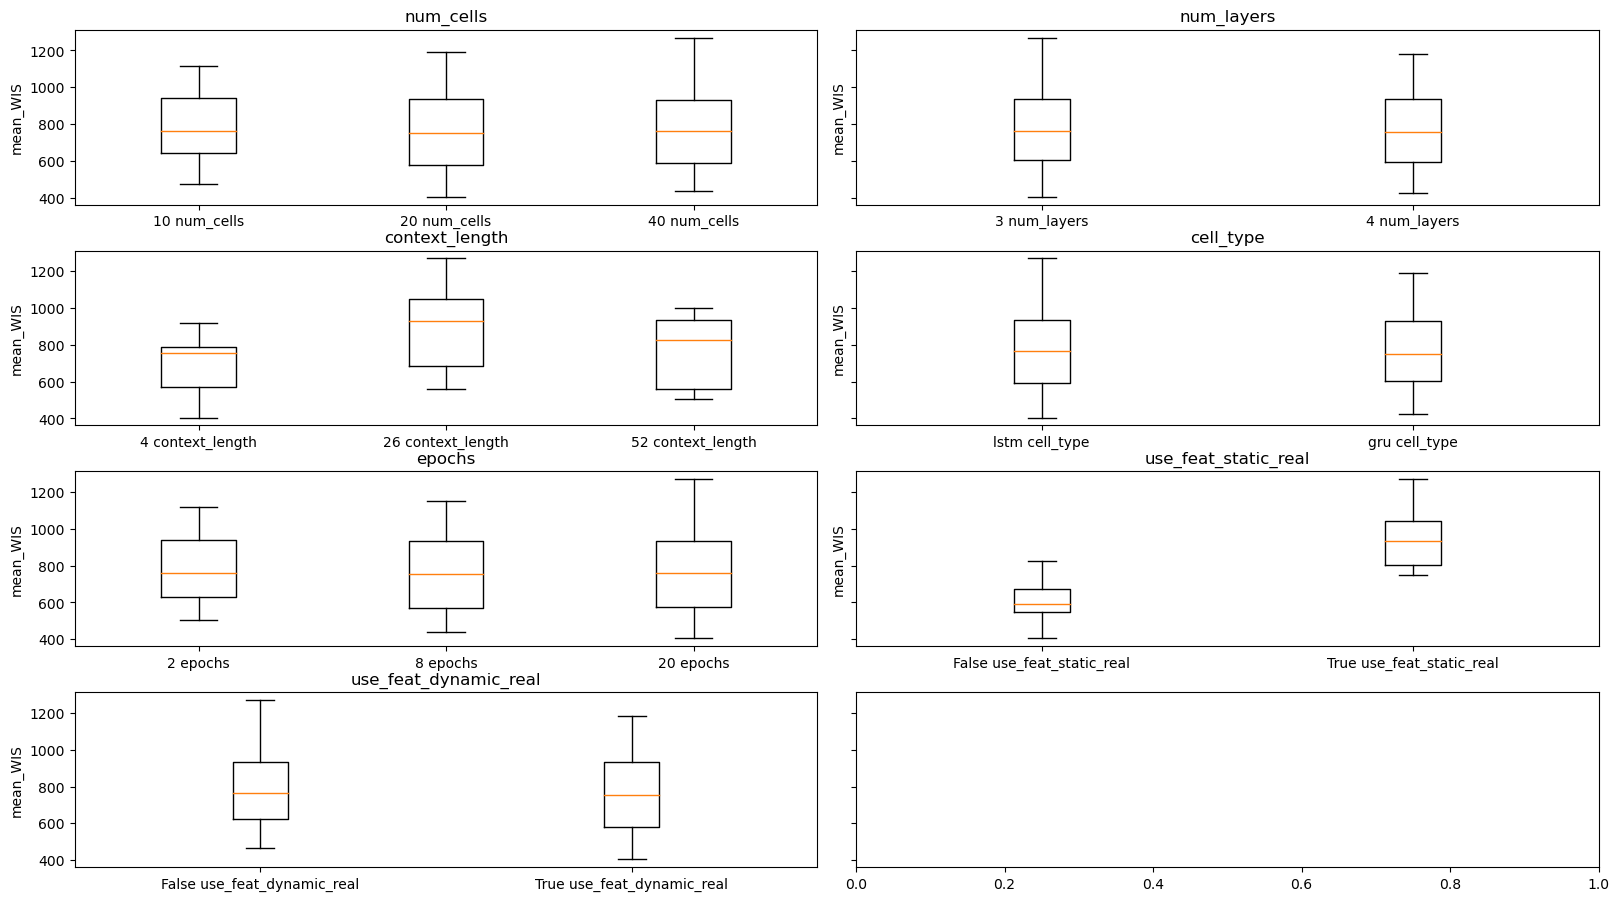

________________


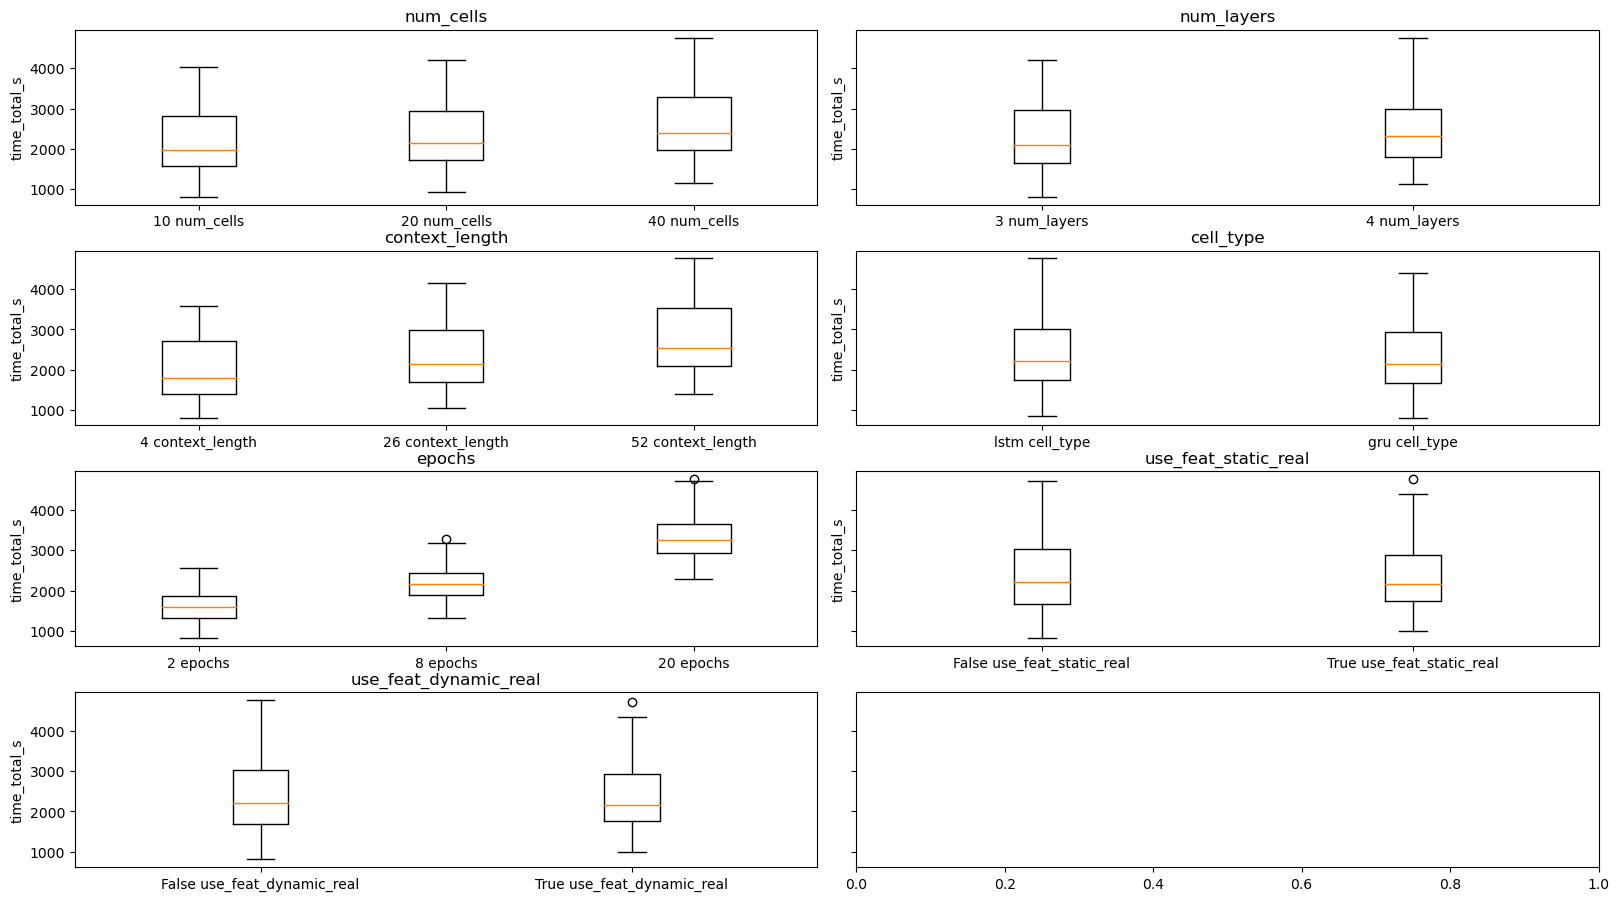

In [107]:
hp_search_space = {
    "num_cells": tune.grid_search([10, 20, 40]),
    "num_layers": tune.grid_search([3, 4]),
    "context_length":tune.grid_search([4, 26, 52]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([2, 8, 20]),
    "use_feat_static_real":tune.grid_search([False,True]),
    "use_feat_dynamic_real":tune.grid_search([False,True]),
    "use_feat_static_cat":True,
    "cardinality":[2]*411,
}
hyperparameter_boxplots(results_df, hp_search_space, col="mean_WIS")
print("________________")
hyperparameter_boxplots(results_df, hp_search_space, col="time_total_s")

In [ ]:
hp_search_space = {
    "num_cells": tune.grid_search([20, 40]),
    "num_layers": tune.grid_search([3, 4]),
    "context_length":4,
    "cell_type":"lstm",
    "epochs":8,
    "batch_size":32,
    "use_feat_static_real":tune.grid_search([False,True]),
    "use_feat_dynamic_real":tune.grid_search([False,True]),
    "use_feat_static_cat":False,
    "cardinality":None,
}
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]

tuner = tune.Tuner(
    tune.with_parameters(objective, train=train, test=test),
    tune_config=tune.TuneConfig(
        metric="mean_WIS",
        mode="min",
    ),
    param_space=hp_search_space,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result().config)

# Showing that the mean_WIS of aggregated is the same as the mean_WIS of the forecast_by_week output

In [20]:
deeparestimator = config.deeparestimator
training_data = data_splits_dict["without_features_2010"][0]
test_data = data_splits_dict["without_features_2010"][1]
forecasts, tss = model(training_data, test_data, deeparestimator)

100%|██████████| 50/50 [00:02<00:00, 23.02it/s, epoch=8/8, avg_epoch_loss=0.76]


Ende make_evaluation_prediction: 2023-03-24 14:21:44.822386
Ende umformen in Listen: 2023-03-24 14:23:16.613937


In [4]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# Evaluation with the quantiles of the configuration
evaluator = Evaluator(quantiles=config.quantiles)    
agg_metrics_OHNE = evaluator(tss, forecasts)[0]
print(agg_metrics_OHNE["mean_absolute_QuantileLoss"])


NameError: name 'tss' is not defined

In [22]:
# Splitting the forecasts into their weekly contribution
split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]
forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
# Evaluation with the quantiles of the configuration
evaluator = Evaluator(quantiles=config.quantiles)
evaluator_df = pd.DataFrame()         
# iterate over the 4 different week-aheads
for forecast in forecast_dict.values():
    agg_metrics, item_metrics = evaluator(split_tss, forecast)
    d = {key for key in forecast_dict if forecast_dict[key] == forecast}
    for location in locations[:]:
        #rename location id to differentiate between the weekahead predictions and concat
        item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
        evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
    agg_metrics["item_id"] = f"aggregated {d}"
    evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics, index=[0])])
# produce the average Quantile Loss metric by dividing the mean absolute QL through the number of involved locations per weekahead, which is usually 411 (each district)
included_locations = [item_id for item_id in evaluator_df.item_id.unique() if "aggregated" not in item_id if "1" in item_id]
evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]), "mean_WIS"] = evaluator_df.loc[evaluator_df.item_id.isin([item_id for item_id in evaluator_df.item_id if "aggregate" in item_id]),"mean_absolute_QuantileLoss"]/len(included_locations)
print(evaluator_df.loc[evaluator_df["mean_WIS"]>0])

Running evaluation: 411it [00:02, 187.13it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 185.65it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 185.67it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 193.75it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT   416.909681   227557.0        470669.0   
0  aggregated {2}            NaT   725.857245   295589.0        470669.0   
0  aggregated {3}            NaT  1022.739788   348505.0        470669.0   
0  aggregated {4}            NaT  1290.569961   385900.0        470669.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  ...  \
0        11.685511        1.191142  4.898491  0.846006  1.072384  ...   
0        11.685511        1.191142  6.204089  0.981873  1.207706  ...   
0        11.685511        1.191142  7.218122  1.108654  1.333179  ...   
0        11.685511        1.191142  7.929070  1.199417  1.440336  ...   

   wQuantileLoss[0.25]  wQuantileLoss[0.5]  wQuantileLoss[0.75]  \
0             0.334183            0.483476             0.429703   
0             0.396395            0.628019             0.645618   
0             0.441978            0.740446          

In [23]:
print(evaluator_df.loc[evaluator_df["mean_WIS"]>0,"mean_WIS"].mean())
print(agg_metrics_OHNE["mean_absolute_QuantileLoss"]/(4*411))

491.3754344803615
491.58945081682305
